In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        #初边界点数据
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        #配位点数据
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        #测试点数据
        self.x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        self.t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #测试点真实数据
        self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        #loss的一个系数
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error
        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        self.test_error.append(error_test)

        # 计算 MAE
        mae = torch.mean(torch.abs(self.u_star - u_real_pred))
        # 计算 MSE
        mse = torch.mean((self.u_star - u_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)

        return loss
      
    
    def train(self, nIter, nIterLBFGS):

        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        # #使用SGD优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='SGD'):
        #     u_pred = self.net_u(self.x_u, self.t_u)
        #     f_pred = self.net_f(self.x_f, self.t_f)
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)

        #     # record the test error
        #     with torch.no_grad():
        #         u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        #     error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        #     self.test_error.append(error_test)


        #     # 记录每一层的权重矩阵
        #     epoch_weights = []
        #     for layer in self.dnn.layers:
        #         if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
        #             epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
        #     self.weights.append(epoch_weights)

        #     W = self.weights



        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # record the test error
            self.dnn.eval() #将神经网络切换为评估模式
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u
            # batch_size = 100  # 设置批次大小
            # n = len(self.x_star)
            # u_real_pred = []
            # for i in range(0, n, batch_size):
            #     x_star_batch = self.x_star[i:i+batch_size]
            #     t_star_batch = self.t_star[i:i+batch_size]
            #     u_real_pred_batch = self.net_u(x_star_batch, t_star_batch)
            #     u_real_pred.append(u_real_pred_batch)
            # u_real_pred = torch.cat(u_real_pred)


            error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            self.test_error.append(error_test)

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)

            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights


    
        
        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


  


    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval()
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
        hidden_output_x = hidden_output[:, 0]
        hidden_output_t = hidden_output[:, 1]
        hidden_output_x = hidden_output_x.detach().cpu().numpy()
        hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output_x, hidden_output_t

In [6]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

def caiyang(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [8]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter):
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    
    # 迭代预测
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    # 迭代预测（扰动后）
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    #对distances进行归一化
    # distances = distances / np.linalg.norm(distances)
    # 对distances进行归一化前，检查分母是否接近零
    # norm = np.linalg.norm(distances)
    # if norm < 1e-10:  # 1e-10是一个非常小的数，用于检测norm是否接近于零
    #     distances = np.zeros_like(distances)  # 如果分母接近0，将distances设置为全零数组，因为范数为0时，distances中的值想对于彼此几乎没有差异，意味着所有点都几乎处于同一混沌度水平
    # else:
    #     distances = distances / norm

    # 现在可以安全地根据distances对点进行排序，即使在所有值都相同的情况下

    return distances

In [9]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 2500
nIter = 50000 #设置迭代次数为10000
nIterLBFGS = 500 #设置LBFGS迭代次数为500


#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)
    

#1.生成初值边界值训练数据，以及测试数据

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.linspace(0, X_u_train_all.shape[0] - 1, N_u, dtype=int) #生成一个等差数列，从0到X_u_train的行数，间隔为1，赋值给idx
# idx = np.random.choice(X_u_train_all.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train


error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值


i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子


    #2.生成配位点并进行训练

    num_iter = 100 #chaos迭代次数

    #先训练500次
    #采样配位点10个
    N_f_1 = N_f//100 #N_f_1=50
    X_f_train = caiyang(N_f_1, "LHS") #生成50个样本点，每个样本点都是一个二维点，即50*2的数据点

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100,0)


    #训练结束后，每500次迭代重采样一次100个点，并选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练50000次
    for iter in range(nIter//100+1, nIter+1, nIter//100): #每500次迭代
        N_f_new = N_f_1 * 10 #重新采样100个点
        # 生成新的X_f_train数据
        X_f_train_new = caiyang(N_f_new, "LHS") #生成500个样本点，每个样本点都是一个二维点，即500*2的数据点


        #计算混沌度
        distances = calculate_chaos(model, X_f_train_new, num_iter)

        #计算残差
        _, residual = model.predict(X_f_train_new)
        # 计算残差的绝对值
        abs_residual = np.abs(residual)
        #将二维数组转换为一维数组
        abs_residual = abs_residual.flatten()


        # 对distances进行归一化
        epsilon = 1e-5
        norm_distances = np.linalg.norm(distances)
        if norm_distances > epsilon:
            distances = distances / norm_distances
        else:
            distances = np.zeros_like(distances)

        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)

        xinxi = 0.9*distances + 0.1*abs_residual #将三个归一化后的数组相加，得到新的数组xinxi

        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.x_f = torch.tensor(X_f_train[:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f_train[:, 1:2], requires_grad=True).float().to(device)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100,0)



    model.train(0,nIterLBFGS) #使用LBFGS训练500次
    #所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    # 训练结束后，再次使用模型进行预测，并计算误差
    u_pred, f_pred = model.predict(X_star)
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:49,  9.98it/s]

Adam:   6%|▌         | 28/500 [00:00<00:02, 160.21it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 204.75it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 221.00it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 229.27it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 233.71it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 248.99it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 254.96it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 257.34it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:00, 264.19it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 265.12it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 269.20it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 262.06it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 262.07it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 265.94it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 269.31it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 270.79it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 274.41it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 266.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 194.15it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 204.96it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 232.00it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 248.39it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 257.00it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 263.97it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 268.74it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 264.85it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 258.81it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 267.43it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 269.88it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 273.76it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 267.34it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 253.14it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 253.82it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 256.86it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 235.12it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 236.31it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 29/500 [00:00<00:01, 283.71it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:01, 273.84it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 271.48it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 256.26it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 251.17it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 252.35it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 214.69it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 226.89it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 226.94it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 230.23it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 232.56it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 239.73it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 241.79it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 245.48it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 240.74it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 248.82it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 254.06it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 250.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.62it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.45it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 245.99it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 262.45it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 271.54it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 260.11it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 270.44it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 271.05it/s]

Adam:  50%|████▉     | 249/500 [00:00<00:00, 267.73it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 269.43it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 264.45it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 262.93it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 252.62it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 257.56it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 257.25it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 252.84it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 248.67it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 245.57it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 227.27it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 240.16it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 254.48it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 252.45it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 258.10it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 246.83it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 257.92it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 260.45it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 259.38it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 243.26it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 251.18it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 260.93it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 256.14it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 252.31it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 253.24it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 253.09it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 238.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 275.62it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 250.10it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 255.52it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 246.66it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 250.14it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 258.44it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 248.19it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 259.23it/s]

Adam:  49%|████▉     | 246/500 [00:00<00:00, 264.93it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 271.87it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 266.87it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 261.86it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 244.46it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 240.77it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 239.84it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 247.66it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 254.54it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 265.25it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 275.80it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 273.20it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 278.10it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 267.17it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 260.61it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 265.55it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 253.19it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 256.78it/s]

Adam:  50%|████▉     | 249/500 [00:00<00:00, 260.33it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 267.51it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 271.98it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 270.94it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 266.69it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 262.27it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 270.81it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 275.06it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 272.08it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 265.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.98it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.63it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 260.98it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 267.06it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 273.78it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 260.72it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 247.64it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 254.93it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 249.85it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 260.18it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 269.17it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 274.21it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 276.46it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 265.30it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 262.58it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 257.59it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 265.43it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 246.69it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.11it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 243.87it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 233.88it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 237.80it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 244.45it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 256.03it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 260.94it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 250.82it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 256.02it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 258.08it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 255.08it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 246.32it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 250.17it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 257.85it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 261.26it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 266.35it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 259.27it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 253.11it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.92it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 268.43it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 250.95it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 261.85it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 258.05it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 261.82it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 266.69it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 272.48it/s]

Adam:  50%|████▉     | 249/500 [00:00<00:00, 273.58it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 277.34it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 277.05it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 269.49it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 270.19it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 257.55it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 265.15it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 263.61it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 258.51it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 265.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.43it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.83it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.78it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 257.25it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 248.62it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 246.60it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 235.90it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 237.54it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 232.70it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 240.00it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 247.79it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 259.03it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 261.97it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 266.02it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 272.27it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 256.82it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 252.17it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 263.47it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 273.43it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 269.49it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 246.03it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 252.20it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 245.63it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 258.33it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 264.03it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 251.76it/s]

Adam:  49%|████▉     | 246/500 [00:00<00:01, 246.31it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 253.00it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 248.91it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 257.53it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 259.28it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 264.97it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 270.07it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 273.66it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 276.99it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 276.34it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 262.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 273.46it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 259.35it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 235.92it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 234.41it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 227.25it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 235.72it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 239.07it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 244.72it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 248.69it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 250.52it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 251.19it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 251.57it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 261.93it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 267.80it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 265.51it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 242.35it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 241.27it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 240.54it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 245.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.87it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 259.95it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 253.24it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 251.00it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 253.75it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 265.44it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 272.76it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 270.53it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 272.03it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 272.77it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 271.84it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 273.79it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 262.44it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 266.27it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 261.36it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 262.25it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 267.74it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 261.32it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 263.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 177.78it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 201.34it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 204.19it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 214.86it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 213.85it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 222.57it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 239.36it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 240.93it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 247.52it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 255.28it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 263.75it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 266.24it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 267.22it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 270.54it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 261.17it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 261.78it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 255.94it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 255.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 221.17it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 216.82it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 215.50it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 218.18it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 236.71it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 249.99it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 246.95it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 247.86it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 258.16it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 255.97it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 263.76it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 256.64it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 251.45it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 245.58it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 240.78it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 249.30it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 257.20it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 251.45it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 268.47it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 251.80it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 256.21it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 264.55it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 246.24it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 234.39it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 230.39it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 234.19it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 232.25it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 245.49it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 254.36it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 262.79it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 260.67it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 264.92it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 252.95it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 250.89it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 260.29it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 246.98it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.77it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.34it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 237.75it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 254.23it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 262.43it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 255.43it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 259.27it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 244.31it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 226.88it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 238.58it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 239.54it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 250.55it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 256.33it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 257.46it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 259.45it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 264.37it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 243.03it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 247.19it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.42it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 240.79it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 248.79it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 262.49it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 258.59it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 263.78it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 270.39it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 253.91it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 252.85it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 260.79it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 265.16it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 257.97it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 259.62it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 267.31it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 261.88it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 249.86it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 234.33it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 235.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.75it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 209.59it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 208.34it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 225.41it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 244.00it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 252.00it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 249.29it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 243.78it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 254.46it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 252.06it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 237.76it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 234.72it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 227.32it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 228.41it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 242.84it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 250.20it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 255.65it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 259.11it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 265.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.57it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 222.44it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 241.05it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 243.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 245.72it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 253.17it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 264.81it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 267.40it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:00, 269.04it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 263.78it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 270.18it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 273.52it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 266.94it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 270.17it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 271.54it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 263.41it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 269.12it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 266.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 260.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 232.56it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 225.44it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 236.98it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 252.87it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 263.00it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 245.58it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 241.15it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 245.86it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 252.72it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 259.59it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 263.10it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 261.83it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 249.96it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 257.44it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 264.87it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 267.97it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 264.07it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.35it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 217.71it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 247.32it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 241.84it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 254.03it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 261.23it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 269.66it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 272.89it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 262.47it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 244.14it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 244.48it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 256.03it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 260.86it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 261.03it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 256.36it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 261.33it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 265.33it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 257.72it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.66it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 255.97it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 241.80it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 250.15it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 256.92it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 265.81it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 266.18it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 265.65it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 252.26it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 255.02it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 261.54it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 267.57it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 267.57it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 272.02it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 275.99it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 276.71it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 276.96it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 278.83it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 266.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.81it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.15it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.43it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 252.25it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 250.37it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 259.53it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 245.11it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 243.42it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 230.58it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 233.24it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 241.00it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 253.32it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 251.79it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 242.99it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 247.12it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 255.41it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 235.90it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 243.77it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 245.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.20it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 267.58it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 263.28it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 265.43it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 267.97it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 271.58it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 255.80it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 260.52it/s]

Adam:  49%|████▉     | 247/500 [00:00<00:00, 259.76it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 267.53it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 273.51it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 275.30it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 264.09it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 257.70it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 260.98it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 264.24it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 271.98it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 265.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.96it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 258.85it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 237.50it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 212.95it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 228.24it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 240.87it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 243.55it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 249.28it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 255.76it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 253.07it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 257.65it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 245.79it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 253.52it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 252.55it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 262.21it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 268.50it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 268.93it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 257.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.40it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 232.93it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 244.06it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 255.38it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 246.25it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 253.73it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 251.03it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 260.88it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 266.40it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 270.34it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 267.20it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 269.07it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 272.17it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 273.19it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 275.17it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 255.67it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 248.61it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 249.61it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.40it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.36it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 248.08it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 262.69it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 269.85it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 272.03it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 273.24it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 265.56it/s]

Adam:  49%|████▉     | 247/500 [00:00<00:00, 258.98it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 264.91it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 262.80it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 259.98it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 251.25it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 252.61it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 259.90it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 263.96it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 258.78it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 250.94it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.46it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 226.91it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 244.60it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 246.21it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 247.01it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 258.99it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 264.13it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 267.29it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 266.59it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 270.39it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 264.14it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 254.46it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 263.77it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 243.64it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 252.80it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 255.79it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 244.24it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 238.12it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.80it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 219.42it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 236.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 248.74it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 255.86it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 234.14it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 242.55it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 253.82it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 257.22it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 266.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 268.12it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 262.96it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 244.07it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 246.99it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 243.45it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 251.55it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 247.97it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 258.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 187.51it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 211.93it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 228.39it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 225.96it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 225.30it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 215.91it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 223.12it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 229.48it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 229.45it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 222.53it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 238.49it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 251.65it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 241.22it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 255.13it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 261.22it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 257.28it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 262.18it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 263.99it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 259.10it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.91it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 227.35it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 248.74it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 262.21it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 257.36it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 264.30it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 267.95it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 258.18it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 251.96it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 261.95it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 261.88it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 266.32it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 265.00it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 266.95it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 271.52it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 266.45it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 248.09it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 242.35it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.13it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 255.67it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 264.92it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 268.57it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 250.37it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 246.85it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 259.42it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 267.57it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 265.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 251.82it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 247.39it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 248.83it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 234.06it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 242.70it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 226.72it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 225.12it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 222.64it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 237.21it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 235.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.54it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 244.72it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 238.53it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 246.29it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 244.39it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 235.72it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 242.62it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 249.44it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 246.38it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 247.98it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 235.59it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 230.23it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 245.84it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 243.98it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 252.19it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 257.33it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 251.54it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 251.78it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 258.36it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 274.14it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:01, 279.16it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 283.01it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 284.80it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 285.74it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 273.00it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 265.29it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:00, 272.09it/s]

Adam:  52%|█████▏    | 259/500 [00:00<00:00, 276.50it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 238.29it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 243.39it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 245.25it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 243.80it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 252.78it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 256.47it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 263.72it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 254.05it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.73it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.01it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 260.36it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 263.26it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 268.57it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 267.16it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 269.81it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 274.59it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 272.22it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 270.83it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 274.93it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 265.77it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 267.55it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 271.28it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 275.69it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 276.68it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 274.66it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 267.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 271.22it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 275.12it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 279.81it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 282.99it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 284.99it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 280.20it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 266.76it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 270.15it/s]

Adam:  52%|█████▏    | 258/500 [00:00<00:00, 275.48it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 279.72it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 273.43it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 261.22it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 262.02it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 244.15it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 240.99it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 245.36it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 255.08it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 265.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 249.13it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 256.59it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 249.01it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 257.58it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 257.57it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 253.24it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 263.39it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 245.77it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 243.76it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 245.57it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 246.11it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 250.05it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 243.34it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 229.34it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 233.14it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 245.78it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 253.31it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 260.20it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 271.43it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:01, 279.58it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 228.88it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 224.93it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 221.82it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 239.75it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 241.62it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 236.59it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 236.78it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 251.17it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 259.66it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 242.67it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 243.84it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 249.84it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 254.21it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 261.16it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 259.69it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 258.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.79it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 235.08it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 250.82it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 243.40it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 253.56it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 245.01it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 245.83it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 238.60it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 222.17it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 225.25it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 225.78it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 226.96it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 227.34it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 220.03it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 221.22it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 232.97it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 238.32it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 246.35it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 251.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.41it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 219.01it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 245.89it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 260.32it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 237.55it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 251.19it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 261.56it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 255.26it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 241.12it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 252.08it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 239.12it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 231.59it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 242.05it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 240.36it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 251.35it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 249.98it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 254.04it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 259.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.21it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 256.56it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 261.66it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 258.22it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 249.66it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 258.43it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 266.12it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 270.58it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 272.59it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 260.63it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 250.46it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 244.09it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 239.42it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 243.03it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 197.78it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 217.49it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 225.80it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 243.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.99it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 270.06it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 275.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 276.29it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 275.97it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 278.27it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 278.29it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:00, 277.50it/s]

Adam:  51%|█████     | 254/500 [00:00<00:00, 279.34it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 260.86it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 242.87it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 244.82it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 242.26it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 218.23it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 227.49it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 234.26it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 244.19it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 248.99it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.44it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 229.29it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 240.88it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 244.42it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 252.14it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 245.98it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 246.56it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 240.29it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 251.86it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 239.09it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 240.01it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 248.19it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 253.56it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 251.10it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 251.76it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 258.73it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 267.59it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 240.85it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 232.07it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.87it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 223.61it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 225.83it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 219.85it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 231.76it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 249.52it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 237.69it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 237.45it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 252.50it/s]

Adam:  50%|█████     | 251/500 [00:01<00:00, 249.02it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 253.44it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 259.35it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 251.30it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 258.32it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 259.80it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 266.95it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 266.27it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 272.34it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 273.90it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.42it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.81it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 258.59it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 251.04it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 252.76it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 247.16it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 244.46it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 225.46it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 222.31it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 237.39it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 242.39it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 238.09it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 247.81it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 250.55it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 249.19it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 249.78it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 243.05it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 225.66it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 223.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.97it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 247.96it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 255.64it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 241.56it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 250.67it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 258.91it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 265.16it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 254.36it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 256.89it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 257.17it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 262.98it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 268.52it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 266.34it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 249.34it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 239.63it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 242.35it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 237.21it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 235.78it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.01it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 219.60it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 234.68it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 233.76it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 244.79it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 234.95it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 248.69it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 249.41it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 252.55it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 249.38it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 237.68it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 237.92it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 249.26it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 255.65it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 264.76it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 270.29it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 264.06it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 259.66it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 249.95it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 237.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 253.60it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 261.08it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 263.05it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 268.01it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 264.18it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 258.78it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 261.47it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 245.80it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 241.78it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 235.10it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 236.38it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 247.20it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 248.26it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 240.25it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 251.04it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 245.54it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.02it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 211.26it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 238.90it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 247.70it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 244.48it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 244.52it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 253.86it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 245.09it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 254.59it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 250.67it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.82it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 250.61it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 242.84it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 243.03it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 241.44it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 247.96it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 232.58it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 246.55it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 245.13it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.18it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 247.46it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 247.45it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 234.95it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 247.02it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 251.35it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 249.61it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 249.04it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 238.04it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 245.39it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 254.56it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 260.37it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 266.05it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 267.05it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 256.42it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 247.36it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 226.88it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 239.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.72it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 244.06it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 231.17it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 247.80it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 232.82it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 230.09it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 234.05it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 242.90it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 243.15it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 243.23it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 228.46it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 240.20it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 232.41it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 237.32it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 239.54it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 235.77it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 237.64it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 235.08it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 235.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.99it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 236.34it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 250.83it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 253.96it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 246.02it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 235.67it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 234.19it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 240.22it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 244.44it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 251.54it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 231.69it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 246.16it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 256.10it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 245.73it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 238.52it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 251.63it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 252.82it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 248.36it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 246.26it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 242.00it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 241.12it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 223.13it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 243.44it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 242.36it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 253.03it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 252.25it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 233.90it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 240.99it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 242.81it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 233.30it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 232.17it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 229.33it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 217.00it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 224.68it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 231.24it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 242.86it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 250.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.68it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.65it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 256.24it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 252.93it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 239.08it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 247.62it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 248.22it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 252.67it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 230.56it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 242.51it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 237.84it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 228.01it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 235.23it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 244.38it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 241.37it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 243.10it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 247.25it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 255.52it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 261.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.25it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.42it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 270.10it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 264.57it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 268.88it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 253.46it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 244.52it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 235.01it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 233.91it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 248.55it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 251.45it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 247.21it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 248.88it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 244.64it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 249.81it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 257.11it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 262.34it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 266.26it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.29it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 229.51it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 220.28it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 207.33it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 210.22it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 219.03it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 232.50it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 248.67it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 241.41it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 245.22it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 250.06it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 252.23it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 238.03it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 239.67it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 244.19it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 251.44it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 233.05it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 237.41it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 250.12it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 193.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.87it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 249.37it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 243.82it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 221.43it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 239.30it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 241.56it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 238.93it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 237.64it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 247.14it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 251.78it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 235.76it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 243.58it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 241.58it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 234.91it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 230.79it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 238.23it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 251.03it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 257.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.11it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 218.28it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 220.42it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 227.38it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 218.22it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 224.20it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 242.93it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 243.98it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 239.89it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 238.86it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 235.66it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 249.54it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 236.07it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 243.85it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 250.07it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 255.23it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 258.75it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 262.64it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 267.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.78it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 226.40it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 219.85it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 231.50it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 224.38it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 208.41it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 225.45it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 235.38it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 223.62it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 230.21it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 238.15it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 251.12it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 257.52it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 256.33it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 261.49it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 257.09it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 261.79it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 257.00it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 247.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.88it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 233.18it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 241.36it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 230.90it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 225.80it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 217.91it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 208.85it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 212.05it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 214.03it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 220.29it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 218.28it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 231.38it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 235.82it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 237.55it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 248.91it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 250.80it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 230.07it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 230.51it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 225.74it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 243.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 224.83it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 219.62it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 230.58it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 239.33it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 228.68it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 230.51it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 234.79it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 224.52it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 233.40it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 243.91it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 248.59it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 249.65it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 248.34it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 255.94it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 248.89it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 238.46it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 243.25it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 246.33it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 253.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.80it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 249.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 262.99it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 255.51it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 251.75it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 242.03it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 247.94it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 253.33it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 248.03it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 256.50it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 259.99it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 193.24it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 212.12it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 221.01it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 234.57it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 249.36it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 248.62it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 248.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 274.44it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 256.59it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 262.11it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 266.34it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 265.38it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 271.67it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 256.12it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 250.37it/s]

Adam:  50%|█████     | 250/500 [00:00<00:00, 259.65it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 263.44it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 256.44it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 252.90it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 234.98it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 243.80it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 236.22it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 234.39it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 233.87it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 242.19it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 200.77it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 231.41it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 246.77it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 234.40it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 231.75it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 230.82it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 212.62it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 220.55it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 220.04it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 220.47it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 224.43it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 229.60it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 233.58it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 230.79it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 232.09it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 239.77it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 250.38it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 253.30it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 261.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 258.80it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.73it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 261.20it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 260.13it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 255.17it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 246.89it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 237.71it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 247.53it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 252.17it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 241.07it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 248.37it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 255.49it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 247.88it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 252.34it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 254.37it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 257.14it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 234.61it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 234.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.94it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 270.20it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 275.01it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 253.31it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 248.64it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 256.43it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 254.81it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 263.93it/s]

Adam:  49%|████▉     | 247/500 [00:00<00:00, 264.40it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 268.06it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 272.34it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 265.93it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 265.02it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 259.43it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 247.26it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 235.10it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 233.82it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 240.49it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.01it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 227.48it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 242.23it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 249.97it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 256.65it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 255.50it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 247.23it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 258.41it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 260.85it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 257.65it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 259.64it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 258.65it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 250.13it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 233.43it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 230.99it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 219.78it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 232.54it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 238.31it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 246.45it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 238.12it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 201.89it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 231.72it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 245.03it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 250.97it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 240.85it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 243.56it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 230.92it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 240.32it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 246.68it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 242.03it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 249.23it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 243.41it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 252.79it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 251.90it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 252.36it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 256.04it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 233.50it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 232.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.78it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.22it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 262.26it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 267.85it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 264.53it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 256.58it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 224.07it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 233.61it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 244.40it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 247.18it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 249.95it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 231.00it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 238.89it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 227.80it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 229.25it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 233.03it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 242.79it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 232.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.77it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.62it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 249.34it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 234.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 247.31it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 240.62it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 220.77it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 230.04it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 244.39it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 254.70it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.55it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 260.26it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 253.10it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 239.76it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 246.30it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 247.96it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 242.52it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 241.43it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 251.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.51it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 253.14it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 249.60it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 249.65it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 254.12it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 258.62it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 229.13it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 222.78it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 231.69it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 242.91it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 246.78it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 246.46it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 226.34it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 234.97it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 240.54it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 230.02it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 235.58it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 247.24it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 249.22it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 182.92it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 208.28it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 205.72it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 230.14it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 234.91it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 233.50it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 227.90it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 235.20it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 237.33it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 239.25it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 241.72it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 240.21it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 234.25it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 233.04it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 233.83it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 237.08it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 237.23it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 243.91it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 240.11it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 247.12it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.48it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 233.08it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 245.73it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 249.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 248.44it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 244.20it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 238.31it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 246.53it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 246.63it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 249.14it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 241.73it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 238.04it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 246.82it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 255.64it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 259.57it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 263.85it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 266.12it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 269.11it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 265.88it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 214.90it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 206.28it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 231.54it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 229.99it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 241.61it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 234.42it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 239.93it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 235.45it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 237.48it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 239.93it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 240.21it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 238.33it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 244.64it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 239.01it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 244.44it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 246.91it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 243.44it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 241.88it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 246.90it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.68it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 229.58it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 244.09it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 250.64it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 255.44it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 250.49it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 250.80it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 254.93it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 250.96it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 247.66it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 255.85it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 232.50it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 227.88it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 234.71it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 239.94it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 236.23it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 241.98it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 244.11it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 251.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.39it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 261.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 253.70it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 229.63it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 223.98it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 236.40it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 241.21it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 245.05it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 251.19it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 255.50it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 253.34it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 245.12it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 226.92it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 224.50it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 215.60it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 221.57it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 231.30it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 235.62it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 243.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.97it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.06it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 259.50it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 262.81it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 263.08it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 249.36it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 254.29it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 253.34it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 257.74it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 261.36it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 261.97it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 260.46it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 261.79it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 254.93it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 259.26it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 261.19it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 251.99it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 256.18it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.24it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 201.43it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 208.07it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 212.30it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 231.37it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 243.37it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 249.47it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 253.93it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 246.62it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 251.42it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 246.00it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 250.92it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 231.90it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 231.53it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 232.37it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 236.39it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 245.36it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 248.48it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 246.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.47it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.99it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.71it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 252.72it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 247.38it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 245.40it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 220.25it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 220.36it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 230.56it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 228.81it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 229.93it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 240.72it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 242.89it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 243.06it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 237.01it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 229.53it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 230.36it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 240.07it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 236.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 189.76it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 204.47it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:01, 221.68it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 238.45it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 238.57it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 238.59it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 248.25it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 253.35it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 257.99it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 237.01it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 245.34it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 243.85it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 225.74it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 230.48it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 234.23it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 234.11it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 237.66it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 242.33it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 237.25it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 236.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.93it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 242.43it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 230.45it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 230.89it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 237.66it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 245.96it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 250.73it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 256.32it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 256.05it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 260.05it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 255.28it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 249.76it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 253.06it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 245.24it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 243.38it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 235.14it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 243.02it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 250.10it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 255.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.82it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 237.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 236.16it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 233.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 218.92it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 233.16it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 242.71it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 239.55it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 247.94it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 253.55it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 254.71it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 238.46it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 236.77it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 224.21it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 234.25it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 241.01it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 238.86it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 237.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.45it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 210.57it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 227.34it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 234.75it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 245.89it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 248.87it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 254.54it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 234.29it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 235.65it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 229.40it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 232.01it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 232.06it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 229.04it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 230.00it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 238.08it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 242.19it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 246.33it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 237.13it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 240.90it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 221.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.40it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 225.99it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 241.86it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 228.59it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 240.37it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 245.96it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 239.61it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 247.03it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 244.86it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 239.21it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 230.25it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 239.28it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 231.33it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 240.85it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 245.08it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 249.28it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 251.27it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 246.87it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 246.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.31it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 213.66it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 223.18it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 238.58it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 242.72it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 249.01it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 249.17it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 245.39it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 241.54it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 244.51it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 249.01it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 245.76it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 251.68it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 253.76it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 247.20it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 247.65it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 228.30it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 233.90it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 242.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.81it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 224.81it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 233.00it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 230.82it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 240.21it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 247.58it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 252.47it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 253.24it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 250.92it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 247.26it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 251.06it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 252.55it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 253.09it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 226.50it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 217.18it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 214.26it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 222.83it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 231.86it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 231.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 236.19it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 236.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 232.63it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 243.00it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 248.76it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 251.04it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 239.69it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 217.69it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 216.43it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 217.66it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 209.95it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 212.73it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 219.31it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 219.76it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 229.49it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 217.21it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 223.49it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 219.97it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 208.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 223.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.28it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 233.31it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 241.71it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 245.35it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 228.67it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 222.05it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 233.35it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 230.05it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 233.98it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 233.53it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 236.95it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 234.62it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 218.04it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 228.66it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 236.40it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 223.52it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 232.24it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 224.40it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 228.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 217.49it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 203.91it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 200.72it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 220.88it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 220.42it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 216.58it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 224.21it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 226.45it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 233.72it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 240.06it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 240.71it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 228.12it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 236.66it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 227.79it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 224.76it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 234.26it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 232.92it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 236.83it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 228.94it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 227.62it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 218.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.81it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 247.73it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 239.35it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 240.36it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 233.26it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 239.75it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 231.77it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 233.59it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 163.12it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 182.95it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 201.77it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 214.68it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 226.43it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 232.71it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 237.99it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 227.83it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 223.06it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 228.50it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 225.13it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 222.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.77it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 205.07it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 215.96it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 231.27it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 224.06it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 224.14it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 209.81it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 220.02it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 231.52it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 239.53it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 245.23it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 234.04it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 239.54it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 243.26it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 248.04it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 247.33it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 246.67it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 250.42it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 250.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.06it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 194.05it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 211.19it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:01, 225.29it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 229.45it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 235.88it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 228.12it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 237.10it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 243.62it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 240.47it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 223.23it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 231.15it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 234.88it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 227.17it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 234.50it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 237.72it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 230.08it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 218.06it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 220.41it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 226.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 225.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 194.31it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 213.51it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 229.56it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 235.93it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 228.87it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 209.53it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 222.19it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 231.88it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 236.32it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 236.04it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 234.35it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 220.21it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 222.62it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 227.30it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 222.07it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 207.24it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 218.92it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 216.90it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 215.95it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 224.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 223.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.03it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 203.45it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 226.76it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 233.58it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 233.05it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 235.48it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 223.68it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 230.34it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 220.33it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 214.57it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 220.56it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 225.15it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 222.23it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 220.83it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 221.31it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 231.86it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 228.88it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 237.58it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 232.32it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 235.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.48it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 226.52it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 215.03it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 222.24it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 230.13it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 237.41it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 241.10it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 238.91it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 234.22it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 227.73it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 228.87it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 229.56it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 236.56it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 234.88it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 227.47it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 232.76it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 237.12it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 235.72it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 236.92it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 237.80it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.81it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 227.97it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 211.99it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 216.08it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 226.57it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 225.22it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 225.83it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 234.04it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 240.32it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 244.43it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 247.31it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 246.36it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 228.63it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 235.86it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 238.41it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 229.78it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 228.98it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 236.55it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 231.66it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 214.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.10it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 201.91it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 220.30it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 213.37it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 225.98it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 222.54it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 223.74it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 213.07it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 220.63it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 217.68it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 228.44it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 234.07it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 235.19it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 240.87it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 242.19it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 245.63it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 247.31it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 246.07it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 226.73it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 219.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.58it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 206.72it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:01, 225.90it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:01, 229.65it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 236.68it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 236.98it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 220.11it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 221.30it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 230.69it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 237.18it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 241.60it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 234.92it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 234.68it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 230.32it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 235.31it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 240.02it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 240.05it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 241.84it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 245.05it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 244.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:17<2:29:15, 17.95s/it]

LBFGS:   0%|          | 2/500 [00:20<1:14:54,  9.02s/it]

LBFGS:   1%|          | 3/500 [00:21<43:08,  5.21s/it]  

LBFGS:   1%|          | 4/500 [00:21<26:42,  3.23s/it]

LBFGS:   1%|          | 5/500 [00:21<17:44,  2.15s/it]

LBFGS:   1%|          | 6/500 [00:22<12:51,  1.56s/it]

LBFGS:   5%|▍         | 23/500 [00:22<01:22,  5.75it/s]

LBFGS:   8%|▊         | 38/500 [00:22<00:39, 11.68it/s]

LBFGS:  10%|█         | 52/500 [00:22<00:23, 18.81it/s]

LBFGS:  13%|█▎        | 66/500 [00:22<00:15, 27.68it/s]

LBFGS:  16%|█▌        | 79/500 [00:22<00:11, 37.37it/s]

LBFGS:  18%|█▊        | 91/500 [00:22<00:08, 47.20it/s]

LBFGS:  21%|██▏       | 107/500 [00:22<00:06, 63.30it/s]

LBFGS:  25%|██▍       | 123/500 [00:23<00:04, 79.86it/s]

LBFGS:  27%|██▋       | 137/500 [00:23<00:03, 91.03it/s]

LBFGS:  31%|███       | 155/500 [00:23<00:03, 109.44it/s]

LBFGS:  34%|███▍      | 170/500 [00:23<00:02, 116.24it/s]

LBFGS:  37%|███▋      | 186/500 [00:23<00:02, 126.57it/s]

LBFGS:  40%|████      | 201/500 [00:23<00:02, 131.74it/s]

LBFGS:  43%|████▎     | 216/500 [00:23<00:02, 135.87it/s]

LBFGS:  47%|████▋     | 233/500 [00:23<00:01, 142.70it/s]

LBFGS:  50%|████▉     | 249/500 [00:23<00:01, 145.57it/s]

LBFGS:  53%|█████▎    | 265/500 [00:24<00:01, 136.12it/s]

LBFGS:  56%|█████▌    | 280/500 [00:24<00:01, 132.10it/s]

LBFGS:  59%|█████▉    | 295/500 [00:24<00:01, 135.95it/s]

LBFGS:  62%|██████▏   | 311/500 [00:24<00:01, 142.53it/s]

LBFGS:  65%|██████▌   | 326/500 [00:24<00:01, 143.64it/s]

LBFGS:  68%|██████▊   | 341/500 [00:24<00:01, 141.60it/s]

LBFGS:  71%|███████   | 356/500 [00:24<00:01, 139.11it/s]

LBFGS:  74%|███████▍  | 371/500 [00:24<00:00, 137.67it/s]

LBFGS:  77%|███████▋  | 386/500 [00:24<00:00, 141.08it/s]

LBFGS:  80%|████████  | 401/500 [00:25<00:00, 138.24it/s]

LBFGS:  84%|████████▎ | 418/500 [00:25<00:00, 146.94it/s]

LBFGS:  87%|████████▋ | 433/500 [00:25<00:00, 143.36it/s]

LBFGS:  90%|████████▉ | 449/500 [00:25<00:00, 146.20it/s]

LBFGS:  93%|█████████▎| 465/500 [00:25<00:00, 147.96it/s]

LBFGS:  96%|█████████▌| 480/500 [00:25<00:00, 146.73it/s]

LBFGS:  99%|█████████▉| 496/500 [00:25<00:00, 149.70it/s]

LBFGS: 100%|██████████| 500/500 [00:25<00:00, 19.48it/s] 

Training time: 244.7257
当前为第1次循环，种子为0
Error u : 2.661129e-03
MAE: 5.694960e-04
MSE: 2.672674e-06


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.64it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 235.52it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 238.26it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 249.64it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 260.14it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 255.13it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 261.65it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 260.96it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 260.87it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 260.87it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 266.48it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 265.21it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 267.94it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 272.61it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 276.00it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 278.73it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 265.78it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 267.73it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.20it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 231.86it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 246.26it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 248.30it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 258.73it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 254.29it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 263.83it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 256.74it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:00, 263.30it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 262.31it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 255.80it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 251.68it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 245.84it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 250.26it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 248.71it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 259.16it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 261.40it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 265.16it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 249.93it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 225.18it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 210.99it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 227.92it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 222.05it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 239.83it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 247.99it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 255.20it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 249.38it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 260.68it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 238.29it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 222.93it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 239.54it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 237.63it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 230.95it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 241.72it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 239.65it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 251.00it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 247.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.64it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 251.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 232.01it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 243.09it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 254.33it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 251.73it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 257.99it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 264.01it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 267.27it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 272.08it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 255.60it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 251.94it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 250.26it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 259.47it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 254.77it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 261.28it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 266.44it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 265.82it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.46it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 268.11it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 260.65it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 269.83it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 264.07it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 264.96it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 271.10it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 271.24it/s]

Adam:  50%|█████     | 250/500 [00:00<00:00, 273.20it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 270.21it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 248.69it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 251.38it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 252.56it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 262.19it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 264.31it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 268.73it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 261.76it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 265.08it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 263.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.33it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 268.35it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 241.16it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 253.92it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 249.17it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 256.53it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 262.57it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 254.56it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:00, 263.78it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 270.64it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 250.09it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 256.93it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 247.30it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 248.02it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 258.04it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 264.15it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 267.11it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 272.39it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.00it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 255.04it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 266.91it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 252.14it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 241.30it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 253.22it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 260.94it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 268.31it/s]

Adam:  49%|████▉     | 246/500 [00:00<00:00, 270.88it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 249.03it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 247.86it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 256.81it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 262.19it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 237.77it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 227.08it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 228.12it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 229.87it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 240.65it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.43it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 252.80it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 231.63it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 245.07it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 245.39it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 239.10it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 250.89it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 253.87it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 239.48it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 253.04it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 254.16it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 253.78it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 259.93it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 267.13it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 269.81it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 258.50it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 254.83it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 264.29it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.59it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.03it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 265.49it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 255.38it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 260.55it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 265.08it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 264.16it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 247.40it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 232.01it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 231.05it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 230.39it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 238.66it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 248.54it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 247.33it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 253.80it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 255.43it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 253.95it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 231.86it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 225.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.56it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 246.15it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 224.49it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 232.81it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 243.11it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 244.48it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 240.74it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 238.21it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 231.03it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 229.48it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 233.82it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 243.20it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 240.33it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 244.40it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 230.90it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 241.89it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 234.28it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 245.99it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 253.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.56it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.35it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 263.09it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 245.29it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 255.86it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 242.17it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 250.49it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 258.29it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 236.32it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 248.08it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 253.32it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 249.97it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 248.61it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 232.10it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 236.92it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 242.40it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 253.38it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 260.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.30it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.20it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 256.44it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 252.06it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 255.49it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 239.63it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 247.68it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 253.57it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 260.30it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 246.58it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 250.41it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 233.96it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 221.12it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 224.31it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 237.94it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 236.38it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 241.86it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 229.05it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 234.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.66it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.76it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 238.36it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 249.63it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 252.77it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 253.25it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 256.07it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 260.35it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 252.62it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 241.77it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 236.23it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 249.16it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 254.57it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 231.86it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 239.73it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 238.54it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 243.77it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 252.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.13it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 245.60it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 218.91it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 227.38it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 240.53it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 253.65it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 253.56it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 246.60it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 244.35it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 239.04it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 237.78it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 243.98it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 250.64it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 255.16it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 261.84it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 257.75it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 263.47it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 253.96it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 246.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.44it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.77it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 238.08it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 247.13it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 254.42it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 241.82it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 229.67it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 236.93it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 246.93it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 254.41it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 253.59it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 252.74it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 255.99it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 263.99it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 266.63it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 264.45it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 259.27it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 261.55it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.77it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 199.25it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 201.45it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 227.28it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 246.80it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 232.78it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 249.35it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 253.02it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 244.54it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 235.26it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 236.13it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 233.52it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 238.62it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 246.43it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 244.67it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 244.13it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 240.55it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 222.14it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 227.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.05it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 213.43it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 214.12it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 217.57it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 232.79it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 225.55it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 236.51it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 248.20it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 233.38it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 246.19it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 235.61it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 242.04it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 245.78it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 238.93it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 250.94it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 261.29it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 268.64it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 262.58it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 242.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.93it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 252.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 247.47it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 241.08it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 246.07it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 234.73it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 239.93it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 252.38it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 241.72it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 235.70it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 248.07it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 254.08it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 261.87it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 251.73it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 256.53it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 256.35it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 245.07it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 222.68it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.80it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 221.81it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 240.24it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 252.75it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 256.89it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 262.26it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 268.51it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 254.57it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:00, 260.69it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 265.12it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 259.65it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 261.44it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 266.04it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 269.21it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 269.39it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 272.88it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 257.76it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 257.89it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.09it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 236.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 251.92it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 246.73it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 249.63it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 232.68it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 236.49it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 245.89it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 247.02it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 249.05it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 245.13it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 250.39it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 251.01it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 253.32it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 261.73it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 265.79it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 269.12it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 266.32it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.66it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 193.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 192.64it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 220.76it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 238.68it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 250.10it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 257.78it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 255.40it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 259.16it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 260.33it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 252.83it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 250.46it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 253.34it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 260.23it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 267.10it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 255.08it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 260.20it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 254.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.64it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.56it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 241.29it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 244.23it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 254.06it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 239.57it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 241.17it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 249.81it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 252.24it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 250.77it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 243.84it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 252.89it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 257.07it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 252.41it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 248.80it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 254.18it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 239.30it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 227.36it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 163.23it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 206.25it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 214.18it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 205.89it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 229.31it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 234.46it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 247.52it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 256.02it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 261.30it/s]

Adam:  50%|█████     | 250/500 [00:01<00:00, 250.52it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 258.81it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 258.79it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 261.16it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 255.09it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 252.13it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 254.91it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 246.72it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 243.24it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 252.07it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.10it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 269.72it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 224.00it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 227.20it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 238.03it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 249.94it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 259.28it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 266.14it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 249.62it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 258.29it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 257.92it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 247.83it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 253.40it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 262.13it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 257.45it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 263.19it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 261.64it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 267.51it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.53it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 245.37it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 254.79it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 256.20it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 257.54it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 208.62it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 224.74it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 235.54it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 227.90it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 238.88it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 241.10it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 247.18it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 239.36it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 238.70it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 241.68it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 250.64it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 228.21it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 235.65it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.78it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 219.76it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 244.76it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 249.44it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 257.68it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 241.33it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 234.19it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 240.19it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 250.82it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 237.31it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 247.55it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 253.60it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 246.62it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 242.80it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 245.29it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 238.89it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 231.18it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 228.86it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 228.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.03it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 239.50it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 234.47it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 238.18it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 239.58it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 239.77it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 246.45it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 244.99it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 254.33it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 261.19it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 264.56it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 269.71it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 270.65it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 267.80it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 264.11it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 265.60it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 254.74it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 240.77it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.77it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 209.76it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 217.72it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 236.15it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 241.03it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 238.67it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 245.23it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 253.40it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 259.05it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 256.22it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 260.17it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 261.80it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 265.03it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 252.77it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 249.36it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 247.71it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 251.70it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 260.41it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 254.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.78it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 217.59it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 234.26it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 240.14it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 245.10it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 255.41it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 259.29it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 255.25it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 256.23it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 240.13it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 248.65it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 243.35it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 238.65it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 248.73it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 252.10it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 252.09it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 253.12it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 253.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 258.01it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 225.02it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 239.56it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 227.53it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 237.83it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 238.35it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 240.27it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 248.91it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 253.26it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 236.73it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 228.77it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 237.47it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 245.73it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 242.74it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 252.15it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 246.55it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 219.04it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 225.72it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 237.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 248.73it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 256.20it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 250.49it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 251.55it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 225.11it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 218.50it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 234.40it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 245.31it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 232.81it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 223.59it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 239.71it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 237.16it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 245.82it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 243.58it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 240.68it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 250.91it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 246.74it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 251.43it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 253.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.11it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 221.74it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 238.74it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 249.35it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 247.62it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 245.25it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 235.98it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 233.84it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 238.55it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 241.33it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 234.78it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 217.21it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 213.25it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 217.90it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 215.61it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 224.19it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 230.52it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 242.85it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 236.06it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 242.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 193.34it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 222.63it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 232.20it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 245.20it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 253.70it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 261.08it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 259.25it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 248.61it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 239.97it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 249.77it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 252.29it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 238.07it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 242.17it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 240.01it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 246.98it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 228.37it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 239.05it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 234.89it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 226.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.01it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 246.37it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 255.50it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 262.19it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 266.84it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 256.08it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 262.26it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 267.28it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 262.74it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 245.80it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 250.45it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 250.98it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 226.88it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 237.97it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 242.64it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 250.37it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 258.24it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 238.51it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.56it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 226.64it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 241.99it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 232.38it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 244.05it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 241.16it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 235.29it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 236.27it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 238.74it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 250.77it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 254.05it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 254.30it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 256.21it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 256.38it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 249.59it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 251.63it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 254.92it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 252.03it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 250.53it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.28it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 233.91it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 243.71it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 246.90it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 250.86it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 254.89it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 250.70it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 246.50it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 255.78it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 257.97it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.94it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 256.35it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 252.20it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 235.46it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 233.43it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 233.03it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 236.11it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 234.13it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 237.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 172.35it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 218.35it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 195.17it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 217.27it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 221.97it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 228.39it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 223.13it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 231.21it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 222.91it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 220.21it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 227.71it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 233.95it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 233.45it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 242.36it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 237.15it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 245.91it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 252.16it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 259.68it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 262.07it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.05it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.44it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 253.75it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 228.47it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 236.96it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 241.86it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 248.01it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 242.67it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 252.02it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 256.15it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 231.91it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 233.63it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 239.47it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 244.23it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 225.40it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 228.49it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 226.64it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 214.71it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 218.36it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.25it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 165.49it/s]

Adam:  11%|█         | 53/500 [00:00<00:02, 173.54it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 183.11it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 210.31it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 232.02it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 244.28it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 250.09it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.69it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 258.73it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 266.17it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 265.11it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 250.12it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 234.05it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 234.83it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 234.66it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 235.05it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 226.16it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 230.33it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 217.51it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.30it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 215.07it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 232.68it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 248.18it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 252.61it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 238.76it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 248.62it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 238.92it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 228.19it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 243.48it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 235.77it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 246.74it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 252.85it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 259.57it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 257.65it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 260.93it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 230.76it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 241.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.08it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.16it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.33it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 254.95it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 261.24it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 261.21it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 251.03it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 238.82it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 248.43it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 256.44it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 262.91it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 266.66it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 257.34it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 262.96it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 265.95it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 255.62it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 249.44it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 256.26it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.29it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 251.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 248.03it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 244.16it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 250.22it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 256.44it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 260.14it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 262.84it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 266.95it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 263.62it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 263.48it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 259.43it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 255.60it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 250.41it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 237.12it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 223.00it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 239.50it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 246.65it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 244.69it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 254.11it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 262.06it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 249.71it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 242.98it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 247.83it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 238.65it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 238.32it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 225.48it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 237.60it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 228.44it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 242.11it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 236.30it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 235.40it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 236.46it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 226.26it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 236.75it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 239.83it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 228.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.95it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.79it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 233.48it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 239.08it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 215.54it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 228.98it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 231.56it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 226.06it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 233.64it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 229.53it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 228.14it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 241.16it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 248.17it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 251.91it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 257.02it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 257.03it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 253.84it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 238.59it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 245.06it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.04it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.45it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 217.12it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 226.04it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 234.30it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 232.60it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 224.91it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 221.63it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 221.95it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 236.92it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 244.21it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 252.95it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 255.90it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 243.40it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 239.06it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 230.27it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 218.40it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 223.77it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 229.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.52it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 249.86it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 240.30it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 233.56it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 236.09it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 250.12it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 252.88it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 249.14it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 256.23it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 254.52it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 247.43it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 255.00it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 256.25it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 239.11it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 238.74it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 247.25it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 249.75it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 242.29it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 235.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.57it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.86it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 245.11it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 252.54it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 255.10it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 251.36it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 245.88it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 231.49it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 231.69it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 240.77it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 228.95it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 229.76it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 230.21it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 219.09it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 235.40it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 236.18it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 236.08it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 232.70it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 234.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 189.60it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 206.91it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 229.72it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 234.69it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 243.40it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 254.25it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 254.87it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 238.63it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 226.23it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 240.07it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 250.98it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 255.63it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 251.53it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 244.64it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 233.90it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 236.20it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 237.08it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 235.79it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 231.06it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.36it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 216.80it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 220.32it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 225.33it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 214.05it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 214.96it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 232.45it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 234.32it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 231.29it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 236.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 238.73it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 232.01it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 241.82it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 238.69it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 238.53it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 247.02it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 245.31it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 242.46it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 243.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.57it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.75it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 248.14it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 244.74it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 251.85it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 232.10it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 241.64it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 226.76it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 223.03it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 229.11it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 237.95it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 242.88it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 249.15it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 256.62it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 261.01it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 244.66it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 248.74it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 245.10it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 248.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.67it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 256.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 254.85it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 250.06it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 257.89it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 250.86it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 242.67it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 247.01it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 250.69it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 229.16it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 238.58it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 246.95it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 253.00it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 243.36it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 237.38it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 229.84it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 231.50it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 234.31it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 246.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.09it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 263.61it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 264.41it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 254.56it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 243.12it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 249.66it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 246.17it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 246.44it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 249.11it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 233.92it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 235.09it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 244.41it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 254.16it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 257.78it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 254.59it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 260.02it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 253.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.18it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 234.72it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 233.99it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 241.63it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 250.02it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 250.04it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 247.30it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 237.57it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 236.53it/s]

Adam:  50%|█████     | 252/500 [00:01<00:00, 248.20it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 238.71it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 238.92it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 237.39it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 239.80it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 241.30it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 250.43it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 252.89it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 250.45it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 244.39it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.86it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 206.00it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 224.98it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 244.29it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 254.53it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 260.71it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 262.06it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 264.92it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 269.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 246.85it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 235.55it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 232.64it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 227.11it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 222.94it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 228.79it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 222.53it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 238.14it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 233.78it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 242.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.41it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 253.45it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 261.07it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 249.97it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 240.53it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 231.19it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 227.23it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 241.11it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 247.16it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 250.01it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 254.69it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 261.49it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 246.94it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 252.59it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 257.79it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 248.32it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 257.06it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 245.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.34it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 258.24it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.07it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 260.27it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 239.80it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 250.99it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 253.93it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 228.61it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 226.85it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 238.27it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 233.39it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 238.56it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 248.47it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 246.12it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 248.67it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 255.32it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 256.20it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 249.49it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.95it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.23it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 267.85it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 264.78it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 268.10it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 256.83it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 256.47it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 235.50it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 244.06it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 224.14it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 233.32it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 244.18it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 242.40it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 251.89it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 250.34it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 259.45it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 245.15it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 244.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 211.28it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 208.89it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 199.39it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:01, 208.96it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 207.54it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 227.71it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 240.69it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 252.58it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 257.74it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 242.71it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 249.14it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 252.75it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 254.81it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 263.91it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 269.42it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 251.19it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 243.66it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 253.08it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 257.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.33it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 251.36it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 258.61it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 262.87it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 259.57it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 256.49it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 240.07it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 240.70it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 251.53it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 255.85it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 257.23it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 261.37it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 259.70it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 260.30it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 257.55it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 249.09it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 248.44it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 246.14it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.28it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 255.15it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 239.66it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 169.32it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 199.06it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 209.75it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 229.04it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 241.84it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 235.10it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 235.52it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 230.77it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 221.15it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 220.54it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 225.48it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 231.09it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 243.78it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 242.17it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 230.64it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 242.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 188.62it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 215.87it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 221.52it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 229.36it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 229.25it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 232.72it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 237.46it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 240.27it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 249.00it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 230.22it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 240.60it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 251.51it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 256.06it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 250.71it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 228.63it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 235.93it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 247.67it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 241.64it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 237.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.57it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.16it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 215.09it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 239.68it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 248.53it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 257.31it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 244.12it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 249.33it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 249.29it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 237.95it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 250.54it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 242.94it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 235.26it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 249.25it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 237.20it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 240.70it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 233.75it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 239.41it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 240.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.19it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.45it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 260.43it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 265.05it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 263.87it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 263.99it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 269.60it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 273.08it/s]

Adam:  49%|████▉     | 246/500 [00:00<00:01, 251.14it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 258.66it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 252.44it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 255.21it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 251.74it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 255.33it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 261.00it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 266.49it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 266.70it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 246.33it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.72it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 241.90it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 253.83it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 256.85it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 258.83it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 253.86it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 260.21it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 246.01it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 243.30it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 232.15it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 236.88it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 249.64it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 259.34it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 252.86it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 240.68it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 241.39it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 249.29it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 234.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.57it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.44it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 252.70it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 242.77it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 253.86it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 258.58it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 265.05it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 269.30it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:01, 252.05it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 256.17it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 255.02it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 249.85it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 259.04it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 252.21it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 259.50it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 258.51it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 263.16it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 267.75it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.88it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 269.86it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 273.26it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 273.60it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 276.77it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 268.89it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 252.42it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 260.81it/s]

Adam:  50%|█████     | 251/500 [00:00<00:00, 265.19it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 249.72it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 248.84it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 226.63it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 235.04it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 240.64it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 253.24it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 257.36it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 242.71it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 230.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.12it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 245.64it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 257.99it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 254.94it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 260.50it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 254.25it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 236.10it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 240.61it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 247.69it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 239.80it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 233.47it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 217.86it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 231.13it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 244.13it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 254.15it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 261.76it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 250.87it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 247.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.67it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 171.44it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 192.98it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 221.74it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 240.04it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 241.49it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 221.73it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 232.22it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 244.15it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 246.52it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 236.47it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 229.29it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 237.85it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 224.23it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 221.07it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 238.40it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 243.15it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 248.43it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 241.39it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 250.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.54it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 212.04it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 240.26it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 252.52it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 262.00it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 263.39it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 256.23it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 240.80it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 237.74it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 229.51it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 229.28it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 239.35it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 249.14it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 240.90it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 234.03it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 234.48it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 225.11it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 234.01it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 232.90it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.23it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.37it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 255.14it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 263.32it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 260.91it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 258.44it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 236.77it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 224.03it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 233.74it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 227.66it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 242.25it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 249.22it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 255.96it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 250.34it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 236.04it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 248.69it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 246.67it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 239.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 268.84it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 273.29it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 266.48it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 253.48it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 238.74it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 244.80it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 239.53it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 229.95it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 240.57it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 245.53it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 249.37it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 255.64it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 261.28it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 243.18it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 249.74it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 257.79it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 262.91it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 264.20it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.33it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.90it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 267.12it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 258.22it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 263.75it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 256.58it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 263.07it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 258.18it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 251.20it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 257.10it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 257.47it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 251.17it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 248.17it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 242.57it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 247.33it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 242.05it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 240.97it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 226.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.30it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 246.73it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 256.17it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 261.31it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 241.52it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 245.30it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 252.10it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 251.46it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 258.76it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 256.50it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 259.41it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 255.99it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 259.75it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 263.93it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 256.86it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 256.11it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 259.73it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 258.61it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.83it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 269.04it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 268.88it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 257.36it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 239.32it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 249.83it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 246.73it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 233.01it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 241.83it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 235.64it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 237.72it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 248.35it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 248.67it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 245.93it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 243.11it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 252.24it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 254.35it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 258.86it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.93it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 226.07it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 236.63it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 241.67it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 247.01it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 250.46it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 245.44it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 250.84it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 250.33it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 242.65it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 217.62it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 228.72it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 230.10it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 230.94it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 219.58it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 233.93it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 244.64it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 242.58it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 238.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.31it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 239.27it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 251.79it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 246.39it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 227.91it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 227.43it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 228.68it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 220.24it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 223.95it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 216.77it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 222.71it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 236.31it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 247.59it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 250.20it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 232.94it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 227.06it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 236.95it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 239.89it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 240.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 229.36it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 225.98it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 225.68it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 243.58it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 253.68it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 238.21it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 247.85it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 243.33it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 225.10it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 230.79it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 233.42it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 239.96it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 247.26it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 251.88it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 253.23it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 254.36it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 237.01it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 231.51it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 240.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.84it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 240.94it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 221.10it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 226.15it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 238.19it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 246.85it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 243.23it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 246.52it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 246.05it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 248.78it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 242.37it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 249.81it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 240.02it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 245.63it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 250.25it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 248.72it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 255.75it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 250.53it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 255.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 232.70it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 245.91it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 252.75it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 257.47it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 247.43it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 252.89it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.77it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 253.40it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 256.79it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 253.73it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 251.95it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 253.05it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 255.99it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 259.95it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 259.82it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 262.84it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 262.16it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.59it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 236.80it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 222.40it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 230.50it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 237.51it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 245.70it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 251.04it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 251.36it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 250.47it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 256.67it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 248.70it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 248.28it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 243.10it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 224.40it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 215.97it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 211.62it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 218.69it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 225.23it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 232.07it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.13it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 195.13it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 226.03it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 236.95it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 246.70it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 251.20it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 250.20it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 252.18it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 221.17it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 231.19it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 236.77it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 230.02it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 239.40it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 246.21it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 248.92it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 254.06it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 254.21it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 258.29it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 255.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.11it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.13it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.19it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 256.10it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 256.20it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 255.15it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 256.87it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 256.94it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 255.54it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 230.40it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 232.30it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 235.03it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 242.09it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 243.52it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 237.14it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 243.41it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 240.55it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 246.43it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 238.13it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.13it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 244.98it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 246.86it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 244.21it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 232.84it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 229.16it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 233.89it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 232.62it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 232.91it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 231.95it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 226.61it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 230.88it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 218.66it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 225.64it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 235.97it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 237.79it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 231.82it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 239.43it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 241.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.24it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 211.13it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 217.20it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 228.17it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 235.91it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 231.59it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 232.59it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 224.89it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 220.93it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 225.49it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 232.60it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 240.28it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 243.77it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 245.64it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 237.91it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 245.00it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 247.36it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 244.93it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 250.55it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 236.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.28it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.61it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.27it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 229.93it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 240.96it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 228.19it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 225.38it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 227.24it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 235.87it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 228.50it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 236.06it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 240.92it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 228.22it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 237.06it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 239.42it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 238.04it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 234.90it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 243.72it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 249.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 188.16it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 200.07it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 207.46it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 203.51it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 198.08it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 213.09it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 227.48it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 236.35it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 241.50it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 239.01it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 244.77it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 245.06it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 244.31it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 238.57it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 232.55it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 239.31it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 228.87it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 231.32it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 234.77it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 243.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.15it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 225.60it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 235.94it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 244.14it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 247.92it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 246.95it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 249.89it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 236.02it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 231.96it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 240.03it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 238.69it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 242.68it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 238.11it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 222.64it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 232.76it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 238.72it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 241.90it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 245.34it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 246.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.98it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 228.46it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 239.45it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 226.43it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 212.08it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 218.31it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 232.04it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 240.87it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 245.44it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 239.12it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 244.79it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 244.66it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 233.06it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 220.45it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 222.66it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 207.56it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 212.74it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 224.65it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 232.44it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 232.65it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 203.32it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 225.28it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 236.98it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 242.82it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 244.91it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 247.22it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 246.49it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 249.93it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 233.83it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 226.03it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 219.38it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 226.32it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 229.19it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 238.03it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 237.89it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 237.97it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 237.20it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 237.69it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 240.96it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 243.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.24it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 232.14it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 227.26it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 213.68it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 217.11it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 223.64it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 229.20it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 235.17it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 240.80it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 238.10it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 228.84it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 236.00it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 232.16it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 229.19it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 224.01it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 233.16it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 239.37it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 225.48it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 231.47it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 239.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.17it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 219.23it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 213.89it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 228.98it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 236.64it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 232.38it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 235.62it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 236.81it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 230.06it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 225.99it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 229.36it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 217.67it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 228.51it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 231.16it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 228.61it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 226.42it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 234.84it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 233.31it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 236.06it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 240.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.14it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 241.36it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 243.95it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 245.96it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 247.66it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 238.49it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 228.89it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 229.30it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 225.54it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 221.20it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 223.61it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 217.47it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 211.50it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 222.19it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 216.50it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 217.11it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 227.71it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 231.87it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 235.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 224.90it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 229.50it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 215.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 228.08it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 237.68it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 237.76it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 231.97it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 219.74it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 218.30it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 207.80it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 217.86it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 219.59it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 205.46it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 212.76it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 216.55it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 218.12it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 229.55it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 234.71it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 235.29it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 240.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 225.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.15it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.86it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 245.47it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 244.76it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 234.15it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 227.74it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 227.19it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 212.33it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 206.32it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 202.47it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 204.55it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 210.99it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 223.58it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 217.23it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 221.39it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 227.74it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 161.00it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 176.24it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 190.07it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 206.36it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 210.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 211.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.12it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 244.56it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 247.05it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 248.63it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 249.93it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 244.10it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 243.35it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 241.55it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 223.64it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 220.20it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 224.15it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 218.43it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 228.90it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 234.82it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 223.55it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 212.72it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 216.08it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 218.92it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 227.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.99it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 218.20it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 233.42it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 240.76it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 228.56it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 231.05it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 237.77it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 233.01it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 224.90it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 229.27it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 235.19it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 240.58it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 236.33it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 231.22it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 237.74it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 241.04it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 243.59it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 243.95it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 235.87it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 227.68it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 226.04it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 213.05it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 206.62it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 213.97it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 219.52it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 228.90it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 232.13it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 236.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 240.72it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 241.85it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 227.81it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 223.95it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 223.33it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 217.78it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 225.81it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 223.30it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 210.69it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 207.92it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 218.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 216.22it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 222.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 212.32it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 200.07it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 213.24it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 223.36it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 218.28it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 226.93it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 233.54it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 222.02it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 209.06it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 220.17it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 223.95it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 228.30it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 235.49it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 240.20it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 242.30it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 244.97it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 229.34it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 229.98it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 226.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 241.14it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 244.88it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 236.56it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 233.23it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 237.96it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 223.62it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 217.03it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 222.08it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 221.53it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 219.53it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 222.09it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 216.81it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 227.00it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 232.14it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 237.33it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 238.44it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 236.25it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 241.36it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 231.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.06it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 240.99it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 244.47it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 246.15it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 243.31it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 243.70it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 243.03it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 235.96it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 234.42it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 236.05it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 233.99it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 234.31it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 233.87it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 233.73it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 228.58it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 234.57it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 239.40it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 239.47it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 224.90it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 227.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:12<1:42:35, 12.33s/it]

LBFGS:   0%|          | 2/500 [00:12<42:41,  5.14s/it]  

LBFGS:   1%|          | 3/500 [00:13<27:17,  3.29s/it]

LBFGS:   1%|          | 4/500 [00:13<17:22,  2.10s/it]

LBFGS:   4%|▍         | 20/500 [00:13<01:43,  4.65it/s]

LBFGS:   7%|▋         | 37/500 [00:14<00:43, 10.59it/s]

LBFGS:  11%|█         | 53/500 [00:14<00:25, 17.83it/s]

LBFGS:  14%|█▍        | 69/500 [00:14<00:15, 26.99it/s]

LBFGS:  17%|█▋        | 83/500 [00:14<00:11, 36.50it/s]

LBFGS:  20%|█▉        | 99/500 [00:14<00:08, 49.59it/s]

LBFGS:  23%|██▎       | 116/500 [00:14<00:05, 65.40it/s]

LBFGS:  27%|██▋       | 133/500 [00:14<00:04, 81.63it/s]

LBFGS:  30%|██▉       | 149/500 [00:14<00:03, 93.71it/s]

LBFGS:  33%|███▎      | 164/500 [00:14<00:03, 101.83it/s]

LBFGS:  36%|███▌      | 179/500 [00:14<00:02, 107.67it/s]

LBFGS:  39%|███▉      | 195/500 [00:15<00:02, 118.75it/s]

LBFGS:  42%|████▏     | 211/500 [00:15<00:02, 127.17it/s]

LBFGS:  45%|████▌     | 227/500 [00:15<00:02, 135.54it/s]

LBFGS:  48%|████▊     | 242/500 [00:15<00:01, 136.47it/s]

LBFGS:  52%|█████▏    | 258/500 [00:15<00:01, 141.73it/s]

LBFGS:  55%|█████▍    | 273/500 [00:15<00:01, 140.68it/s]

LBFGS:  58%|█████▊    | 289/500 [00:15<00:01, 145.69it/s]

LBFGS:  61%|██████    | 304/500 [00:15<00:01, 145.51it/s]

LBFGS:  64%|██████▍   | 320/500 [00:15<00:01, 149.56it/s]

LBFGS:  67%|██████▋   | 336/500 [00:16<00:01, 149.29it/s]

LBFGS:  70%|███████   | 352/500 [00:16<00:01, 143.42it/s]

LBFGS:  73%|███████▎  | 367/500 [00:16<00:00, 137.37it/s]

LBFGS:  76%|███████▋  | 382/500 [00:16<00:00, 139.27it/s]

LBFGS:  79%|███████▉  | 397/500 [00:16<00:00, 141.83it/s]

LBFGS:  82%|████████▏ | 412/500 [00:16<00:00, 140.98it/s]

LBFGS:  86%|████████▌ | 428/500 [00:16<00:00, 145.67it/s]

LBFGS:  89%|████████▊ | 443/500 [00:16<00:00, 136.31it/s]

LBFGS:  92%|█████████▏| 458/500 [00:16<00:00, 137.93it/s]

LBFGS:  94%|█████████▍| 472/500 [00:17<00:00, 134.78it/s]

LBFGS:  98%|█████████▊| 489/500 [00:17<00:00, 142.96it/s]

LBFGS: 100%|██████████| 500/500 [00:17<00:00, 29.04it/s] 

Training time: 240.0454
当前为第2次循环，种子为1
Error u : 4.022278e-03
MAE: 6.233243e-04
MSE: 6.106019e-06


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:23, 20.82it/s]

Adam:   1%|          | 6/500 [00:00<00:23, 21.08it/s]

Adam:   2%|▏         | 9/500 [00:00<00:23, 20.88it/s]

Adam:   2%|▏         | 12/500 [00:00<00:22, 22.10it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 91.71it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 146.25it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 179.01it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 197.83it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:01, 196.09it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:01, 212.36it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 216.40it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 229.84it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 228.45it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 238.92it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 248.73it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 232.55it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 239.83it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 222.90it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 223.84it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 231.76it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 239.66it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 245.82it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 240.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 193.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.38it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 217.03it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 211.70it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 229.32it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 244.25it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 234.49it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 242.92it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 248.27it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 243.99it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 231.06it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 233.43it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 241.45it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 250.39it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 252.74it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 246.95it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 245.22it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 244.01it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 251.11it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 257.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 230.63it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.09it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 260.21it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 232.22it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 223.07it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 225.18it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 226.26it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 233.69it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 243.74it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 240.85it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 241.55it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 240.56it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 250.14it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 225.89it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 234.05it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 244.70it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 252.87it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 250.39it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 250.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.28it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 239.76it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 256.44it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 249.28it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 236.25it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 230.36it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 244.63it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 250.43it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 244.09it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 246.45it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 253.08it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 257.37it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 239.95it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 244.78it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 241.07it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 250.78it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 258.72it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 255.21it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 248.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 270.93it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 252.54it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 244.87it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 232.41it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 246.19it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 256.58it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 264.60it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 254.84it/s]

Adam:  49%|████▉     | 246/500 [00:00<00:00, 258.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 257.24it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 246.22it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 251.05it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 250.98it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 258.13it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 260.83it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 260.93it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 246.96it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 249.81it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.13it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.28it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 252.14it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 228.12it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 237.52it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 248.45it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 256.76it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 260.48it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 264.16it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 266.64it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 259.70it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 256.26it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 256.41it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 253.90it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 227.64it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 242.08it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 243.79it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 237.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.22it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.74it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 256.93it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 250.00it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 253.50it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 259.17it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 264.85it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 251.27it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 234.74it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 246.02it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 250.52it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 254.30it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 258.12it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 255.01it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 249.70it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 251.98it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 251.63it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 253.10it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.13it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 212.03it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 236.88it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 247.13it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 250.83it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 243.62it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 246.62it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 254.55it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 260.41it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 265.28it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 261.87it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 266.33it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 269.57it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 268.38it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 265.30it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 264.38it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 270.33it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 267.23it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<07:23,  1.13it/s]

Adam:   1%|▏         | 7/500 [00:00<00:53,  9.23it/s]

Adam:   5%|▍         | 23/500 [00:01<00:14, 34.00it/s]

Adam:   8%|▊         | 40/500 [00:01<00:07, 58.81it/s]

Adam:  11%|█▏        | 57/500 [00:01<00:05, 81.96it/s]

Adam:  14%|█▍        | 72/500 [00:01<00:04, 86.23it/s]

Adam:  17%|█▋        | 85/500 [00:01<00:05, 72.46it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:03, 106.59it/s]

Adam:  26%|██▌       | 131/500 [00:01<00:02, 128.28it/s]

Adam:  31%|███▏      | 157/500 [00:02<00:02, 158.65it/s]

Adam:  37%|███▋      | 183/500 [00:02<00:01, 182.77it/s]

Adam:  42%|████▏     | 208/500 [00:02<00:01, 200.06it/s]

Adam:  46%|████▋     | 232/500 [00:02<00:01, 210.49it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 226.19it/s]

Adam:  57%|█████▋    | 286/500 [00:02<00:00, 238.46it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:00, 248.52it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 252.67it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 247.50it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 239.64it/s]

Adam:  84%|████████▎ | 418/500 [00:03<00:00, 227.54it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 234.16it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 242.94it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 244.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 236.15it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 223.45it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 203.68it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 197.69it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 219.39it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 233.11it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 236.04it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 228.80it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 227.37it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 238.99it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 248.96it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 242.32it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 241.14it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 241.46it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 246.65it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 251.80it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 244.06it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 244.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.87it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.57it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 239.94it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 246.47it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 253.82it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 241.19it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 235.00it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 242.26it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 242.56it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 249.67it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 254.45it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 251.74it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 250.62it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 256.49it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 260.09it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 254.64it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 243.00it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 241.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 272.09it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 249.26it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 232.79it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 215.35it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 221.19it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 228.45it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 231.41it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 231.77it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 242.88it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 242.76it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 244.98it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 239.92it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 247.84it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 243.51it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 245.85it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 252.25it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 243.01it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 219.56it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 233.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.66it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.16it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 246.18it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 233.99it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 224.89it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 233.68it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 233.76it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 235.44it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 244.41it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 247.03it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 238.19it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 230.85it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 237.77it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 236.40it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 215.14it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 231.60it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 244.29it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 244.95it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 252.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.35it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.24it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 266.95it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 259.44it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 258.31it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 245.56it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 249.17it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 239.17it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 249.97it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 255.27it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 258.77it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 248.32it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 249.52it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 250.35it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 254.80it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 248.49it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 254.36it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 243.99it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.70it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 267.39it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 262.56it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 265.76it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 259.59it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 261.64it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 262.85it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 265.89it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 256.31it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 262.75it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 263.74it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 247.92it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 250.57it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 247.63it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 254.48it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 258.37it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 264.86it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 246.19it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.35it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.81it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 243.43it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 242.07it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 227.98it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 228.03it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 241.37it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 249.67it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 248.00it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 253.83it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 260.19it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 244.36it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 252.76it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 256.54it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 261.29it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 260.45it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 247.59it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 253.61it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.76it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.22it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 251.20it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 238.42it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 243.81it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 241.29it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 246.45it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 233.04it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 233.77it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 235.41it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 233.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 243.62it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 234.87it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 237.74it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 240.82it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 251.33it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 239.24it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 234.52it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 225.28it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.12it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 240.12it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 240.93it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 227.12it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 224.94it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 230.45it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 219.58it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 225.23it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 231.88it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 232.26it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 237.40it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 247.46it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 241.70it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 215.71it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 228.65it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 227.62it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 232.68it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 238.65it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 247.65it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.48it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 219.25it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 241.12it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 247.08it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 256.60it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 259.68it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 256.75it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 258.35it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 244.90it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 227.02it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 233.35it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 234.76it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 245.51it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 237.77it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 243.72it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 249.55it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 252.35it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 231.20it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 231.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.06it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 231.39it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 246.42it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 257.60it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 256.68it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 250.19it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 254.45it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 255.18it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 252.67it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 246.94it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 249.33it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 233.76it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 223.64it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 229.68it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 232.12it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 237.40it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 239.53it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 250.99it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 249.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.17it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.44it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.26it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 244.27it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 251.74it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 255.73it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 255.49it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 259.24it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:00, 262.47it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 266.44it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 262.90it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 260.18it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 247.95it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 253.34it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 237.46it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 238.67it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 227.89it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 240.67it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 214.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 240.87it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 255.54it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 258.79it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 226.92it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 226.53it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 221.81it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 220.81it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 235.88it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 244.43it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 251.16it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 255.33it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 256.01it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 246.21it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 245.58it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 231.39it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 220.64it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 221.50it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 230.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.46it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.68it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 253.96it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 253.61it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 245.20it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 251.52it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 251.57it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 256.87it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 256.54it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 246.86it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 237.45it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 245.55it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 254.75it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 242.39it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 249.40it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 255.43it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 257.29it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 254.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.49it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 237.76it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 224.97it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 229.38it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 238.39it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 248.33it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 247.36it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 244.47it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 244.91it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 243.25it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 239.80it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 246.11it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 246.65it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 249.53it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 240.28it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 240.94it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 226.24it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 239.18it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 236.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.71it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.12it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 242.48it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 240.32it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 248.36it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 255.00it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 242.29it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 234.40it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 244.34it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 250.97it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 230.65it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 242.04it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 251.87it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 250.31it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 254.51it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 256.78it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 254.43it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 244.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.03it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 260.17it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 249.70it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 241.62it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 238.31it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 217.05it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 183.70it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 205.00it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 215.28it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 217.32it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 229.21it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 217.37it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 222.97it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 234.07it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 240.14it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 243.67it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 253.56it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 252.00it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 234.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 187.61it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 214.33it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 235.63it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 233.14it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 244.51it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 246.10it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 233.65it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 237.24it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 246.62it/s]

Adam:  50%|█████     | 251/500 [00:01<00:00, 252.27it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 255.39it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 248.86it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 244.12it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 246.10it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 244.06it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 249.64it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 235.91it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 245.29it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 228.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 230.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 231.05it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 238.43it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 230.10it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 204.78it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 217.83it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 208.16it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 223.70it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 236.00it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 242.82it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 247.96it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 246.45it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 249.55it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 246.69it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 240.42it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 242.08it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 246.97it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 250.91it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 247.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.00it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 245.37it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 228.45it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 236.83it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 239.40it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 244.11it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 253.84it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 258.94it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 248.75it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 253.45it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 238.18it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 239.33it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 238.72it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 246.69it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 255.15it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 249.20it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 245.26it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 243.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.19it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 218.99it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 237.41it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 248.88it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 233.22it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 233.83it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 227.83it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 237.57it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 235.16it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 221.35it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 220.55it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 227.82it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 219.15it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 228.77it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 238.91it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 236.41it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 236.26it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 242.99it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 251.29it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 254.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 240.24it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 249.59it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 251.05it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 241.42it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 246.84it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 252.97it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 246.25it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 238.23it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 233.34it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 230.15it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 223.75it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 229.64it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 239.58it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 245.32it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 247.64it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 240.78it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 233.52it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 237.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.64it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 248.77it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 236.76it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 250.69it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 245.75it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 243.91it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 241.17it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 251.81it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 255.47it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 261.39it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 240.49it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 233.53it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 231.89it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 233.10it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 230.05it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 220.07it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 231.59it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 234.11it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 229.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.79it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 259.74it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.66it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 238.68it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 240.87it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 234.58it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 242.35it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 240.61it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 232.88it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 234.12it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 243.38it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 232.98it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 230.45it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 216.89it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 227.38it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 227.41it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 232.31it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 244.58it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 252.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.21it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 224.86it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 236.53it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 248.16it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 254.70it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 245.30it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 240.89it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 250.56it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 242.77it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 242.89it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 236.25it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 227.92it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 229.31it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 231.30it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 229.13it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 227.05it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 234.42it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 243.12it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 250.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.20it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 182.92it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 187.29it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 215.34it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 231.09it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 234.04it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 243.57it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 241.00it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 252.61it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 254.56it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 249.50it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 252.58it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 249.99it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 251.62it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 256.63it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 259.01it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 257.92it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 243.00it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 248.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 232.86it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 240.16it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 249.95it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 232.08it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 219.89it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 207.61it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 224.34it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 235.26it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 227.05it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 240.94it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 243.16it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 250.77it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 256.59it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 245.65it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 252.05it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 249.52it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 240.48it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 242.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.88it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 214.43it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 226.76it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 230.24it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 244.25it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 246.60it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 243.57it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 242.36it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 243.85it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 247.64it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 234.81it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 238.47it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 237.99it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 233.09it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 234.66it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 241.05it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 227.01it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 239.79it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 232.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 237.92it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 211.40it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 230.56it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 243.54it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 248.41it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 239.24it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 249.08it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 255.91it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 260.91it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 246.26it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 245.66it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 244.16it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 247.00it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 253.11it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 257.99it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 250.32it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 247.36it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 245.87it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 248.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.76it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 216.16it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 236.71it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 248.28it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 249.79it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 255.16it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 247.33it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 234.03it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 231.75it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 229.50it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 240.76it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 240.33it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 247.52it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 252.45it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 259.66it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 262.66it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 266.24it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 269.60it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 268.73it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 258.56it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.43it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 225.85it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 241.14it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 246.25it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 232.29it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 239.22it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 243.04it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 236.73it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 238.60it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 239.73it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 247.90it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 255.00it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 256.14it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 253.71it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 250.13it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 247.12it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 246.14it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 244.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.59it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 252.99it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 254.58it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 248.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 246.80it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 252.78it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 238.74it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 232.08it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 239.27it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 240.05it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 243.98it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 249.04it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 252.02it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 258.90it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 255.76it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 241.82it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 243.21it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 248.63it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 245.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.05it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 240.61it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 236.16it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 212.14it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 221.09it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 218.69it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 230.42it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 241.83it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 249.42it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 245.27it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 245.37it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 221.23it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 224.42it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 217.21it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 216.91it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 232.84it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 237.66it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 227.87it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 237.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.98it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 236.39it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 249.44it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 251.83it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 260.88it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 262.72it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 261.52it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 256.75it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 259.65it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 258.81it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 234.29it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 242.60it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 245.05it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 244.69it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 245.56it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 251.09it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 242.10it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.92it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 244.85it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 244.18it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 246.37it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 247.07it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 255.79it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 255.66it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 249.88it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 254.91it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 252.96it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 254.81it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 260.62it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 266.61it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 247.78it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 242.71it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 248.67it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 234.37it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 243.72it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.12it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 222.63it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 220.72it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 226.66it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 222.42it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 233.73it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 228.44it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 232.36it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 246.53it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 253.60it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 243.26it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 243.67it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 247.65it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 252.41it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 255.17it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 261.50it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 256.04it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 256.47it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 258.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.69it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.97it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.06it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 259.68it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 251.15it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 253.28it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 241.48it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 250.38it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 256.80it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 249.01it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 242.69it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 224.14it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 235.19it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 246.25it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 236.29it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 232.82it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 243.84it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 241.04it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 247.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.62it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.51it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 243.30it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 245.36it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 224.82it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 239.47it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 229.81it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 227.08it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 234.81it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 244.91it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 241.82it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 233.88it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 239.22it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 237.31it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 239.85it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 250.91it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 242.84it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 249.78it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 257.22it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 219.53it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 190.16it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 209.22it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 226.07it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 238.11it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 244.52it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 248.57it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 250.53it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 234.59it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 238.36it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 242.68it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 242.10it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 249.42it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 255.42it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 247.42it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 248.09it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 237.83it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 240.81it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 241.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.92it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 245.98it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 232.69it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 228.51it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 229.41it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 238.86it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 241.08it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 246.06it/s]

Adam:  50%|█████     | 251/500 [00:01<00:00, 252.53it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 252.72it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 246.49it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 232.33it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 239.86it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 248.85it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 255.51it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 257.77it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 263.37it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 262.49it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.02it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 237.39it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.11it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 260.27it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 259.56it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 244.55it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 236.11it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 234.58it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 243.62it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 246.69it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 237.34it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 230.08it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 232.00it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 241.67it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 239.94it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 217.86it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 231.21it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 241.05it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 248.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.96it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 233.69it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 245.09it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 244.56it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 244.08it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 254.42it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 257.62it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 248.22it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 248.33it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 243.97it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 249.07it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 241.02it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 236.35it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 237.13it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 249.32it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 252.86it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 260.53it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 251.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 271.20it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 236.44it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 237.33it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 226.21it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 231.40it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 239.16it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 238.30it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 243.37it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 231.05it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 230.55it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 228.80it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 231.00it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 235.02it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 246.90it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 247.21it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 246.25it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 252.64it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 255.22it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 248.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.95it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 206.07it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 215.08it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 229.89it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 244.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 237.75it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 249.85it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 254.82it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 249.33it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 257.07it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 263.27it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 248.78it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 240.64it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 250.28it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 255.81it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 261.75it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 266.55it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 270.83it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.35it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 201.16it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 227.30it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 227.60it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 238.18it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 235.00it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 238.64it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 247.85it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 248.43it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 252.28it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 256.98it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 240.57it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 230.32it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 239.76it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 222.40it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 225.30it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 239.60it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 229.55it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 230.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 230.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 225.53it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 237.19it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 253.36it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 258.61it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 265.74it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 253.59it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 258.42it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 243.20it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 250.94it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 256.09it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 254.32it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 259.48it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 259.99it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 263.89it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 266.43it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 254.44it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 263.13it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.46it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 258.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 267.29it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 256.21it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 254.07it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 235.66it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 248.40it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 258.47it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 260.91it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 257.43it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 253.71it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 243.49it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 245.97it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 246.79it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 239.43it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 252.16it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 258.80it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 263.80it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.36it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.69it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 251.03it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 255.82it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 250.52it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 259.27it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 254.76it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 258.40it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 264.15it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 266.43it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 263.57it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 268.65it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 254.78it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 246.17it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 240.23it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 244.44it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 247.08it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 257.30it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.09it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 239.05it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 248.66it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 258.86it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 262.28it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 266.89it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 262.43it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:00, 267.22it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 271.83it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 271.48it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 258.75it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 257.73it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 264.99it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 270.10it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 265.90it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 256.92it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 263.19it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.05it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 236.16it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 252.48it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 242.38it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 244.63it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 238.36it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 247.59it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 256.97it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 246.64it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 242.06it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 245.76it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 246.73it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 252.70it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 261.49it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 267.17it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 260.39it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 266.33it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 267.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.63it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.91it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 242.95it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 246.35it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 256.15it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 255.64it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 254.80it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 255.22it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 258.42it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 259.48it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 263.09it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 250.87it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 258.28it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 264.03it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 268.17it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 245.98it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 254.17it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 262.57it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.92it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 237.73it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 242.36it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 239.45it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 232.39it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 236.06it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 246.51it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 255.53it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 255.15it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 253.76it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 248.44it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 256.89it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 259.22it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 257.46it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 264.10it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 266.50it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 263.58it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 257.84it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 242.99it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 252.50it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 172.87it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 191.06it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 212.67it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 225.56it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 237.80it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 250.70it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 259.93it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 266.01it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 268.32it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 269.20it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 244.85it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 240.96it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 252.40it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 250.94it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 251.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.12it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 232.11it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 217.64it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 237.54it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 248.84it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 237.59it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 230.86it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 233.19it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 230.30it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 237.98it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 238.44it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 235.17it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 241.11it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 253.72it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 262.41it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 266.52it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 256.24it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 252.52it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 251.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.60it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 257.34it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 264.64it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 269.29it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 271.39it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 273.92it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 258.19it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 257.68it/s]

Adam:  49%|████▉     | 246/500 [00:00<00:00, 257.33it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 264.58it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 249.82it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 251.96it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 255.60it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 256.99it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 259.66it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 261.47it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 253.19it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 246.70it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.89it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.31it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 267.73it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 245.82it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 239.47it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 249.79it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 251.68it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 259.02it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 253.56it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 250.10it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 248.33it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 251.07it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 254.81it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 250.42it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 249.90it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 253.59it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 252.05it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 257.08it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.83it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 267.49it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 249.54it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 246.66it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 250.06it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 259.27it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 265.57it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 270.06it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 270.96it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 256.89it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 247.18it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 251.37it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 250.88it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 252.40it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 240.20it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 225.38it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 233.01it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 235.76it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 248.26it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 259.61it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 246.13it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 253.59it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 256.86it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 252.26it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 251.22it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 257.59it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 259.14it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 259.06it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 246.02it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 256.69it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 257.06it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 261.69it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 262.36it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 263.13it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 239.76it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 193.48it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 211.81it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 237.36it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 244.36it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 245.97it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 255.04it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 260.54it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 241.60it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 248.88it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 233.85it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 246.21it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 250.85it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 257.77it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 264.05it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 266.59it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 267.52it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 266.48it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 259.24it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.81it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.54it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.04it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 259.81it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 254.76it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 258.64it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 263.33it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 255.27it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 246.92it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 241.28it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 233.82it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 239.12it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 249.26it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 250.34it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 256.83it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 262.17it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 253.94it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 260.08it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.58it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.95it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 252.27it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 246.06it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 228.98it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 224.69it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 236.26it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 235.83it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 232.16it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 222.51it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 234.87it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 240.96it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 241.30it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 245.31it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 238.52it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 218.68it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 206.99it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 220.92it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 236.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.51it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 243.02it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 242.14it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 232.38it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 240.24it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 237.69it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 237.49it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 232.66it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 234.04it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 244.36it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 250.54it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 256.04it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 260.82it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 263.99it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 265.63it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 253.55it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 252.44it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 260.31it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 260.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 193.33it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 195.39it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:01, 221.10it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 225.69it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 240.58it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 217.35it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 217.81it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 211.96it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 211.91it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 213.12it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 226.47it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 222.54it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 237.68it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 242.89it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 247.33it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 254.84it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 261.81it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 243.89it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 248.28it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 253.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.03it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 253.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 231.16it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 234.88it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 238.88it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 239.73it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 250.89it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 258.94it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 263.65it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 262.45it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 258.63it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 236.60it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 238.18it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 244.82it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 241.33it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 239.34it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 243.71it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 232.07it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 237.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 214.68it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 246.83it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 235.38it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 228.43it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 231.27it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 240.25it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 231.46it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 236.38it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 235.94it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 239.61it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 242.44it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 241.76it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 243.95it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 243.96it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 251.97it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 251.76it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 249.65it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 250.49it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 239.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.63it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 211.65it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 235.47it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 246.63it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 250.09it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 252.88it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 257.07it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 262.59it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:00, 265.83it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 260.32it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 256.89it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 255.68it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 260.22it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 263.44it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 259.92it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 263.85it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 264.18it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 267.47it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.03it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 211.32it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 216.28it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 237.03it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 222.50it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 229.54it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 228.57it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 230.08it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 216.24it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 216.13it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 231.11it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 238.72it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 239.02it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 245.94it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 249.77it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 253.04it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 236.47it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 242.14it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 230.88it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 229.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.44it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 224.99it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 205.05it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 197.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 207.94it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 223.05it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 225.04it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 227.75it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 224.02it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 233.05it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 233.32it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 238.21it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 238.53it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 230.02it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 241.50it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 236.50it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 229.76it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 227.84it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 238.42it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 244.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.82it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.79it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 238.99it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 242.80it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 247.29it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 251.35it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 243.91it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 228.93it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 241.43it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 250.31it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 246.20it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 252.59it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 250.07it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 243.03it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 239.55it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 247.36it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 251.53it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 252.82it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 254.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.58it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.50it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 259.56it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 235.12it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 235.53it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 239.60it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 245.18it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 246.40it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 250.78it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 243.78it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 239.32it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 244.30it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 251.99it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 245.52it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 231.68it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 240.50it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 246.04it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 230.79it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 234.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 223.06it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 234.80it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 227.66it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 215.73it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 214.71it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 227.95it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 226.99it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 217.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 227.64it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 227.61it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 236.93it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 245.55it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 252.58it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 245.10it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 249.89it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 241.74it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 247.74it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 241.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.72it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 193.79it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 208.36it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 208.25it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 220.88it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 233.90it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 241.48it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 246.81it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 251.50it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 252.28it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 256.31it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 255.17it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 255.52it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 251.40it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 247.01it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 253.47it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 250.63it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 245.47it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 247.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.68it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 249.89it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 230.21it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 226.58it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 230.91it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 226.79it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 231.89it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 220.82it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 231.54it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 239.91it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 236.44it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 230.22it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 223.94it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 235.42it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 241.81it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 240.18it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 244.71it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 248.42it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 244.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.26it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 240.77it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 243.99it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 242.55it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 226.43it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 237.28it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 246.12it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 251.85it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 225.99it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 228.60it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 220.38it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 230.89it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 235.27it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 237.70it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 232.76it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 225.47it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 232.25it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 228.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.28it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 247.93it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 238.06it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 246.99it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 251.83it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 255.51it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 249.46it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 254.23it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 252.06it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 254.62it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 253.65it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 256.82it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 258.27it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 249.46it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 244.31it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 214.09it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 212.65it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 212.98it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 219.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 196.67it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.05it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 240.67it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 244.57it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 237.67it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 241.06it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 242.27it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 240.29it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 240.22it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 238.66it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 232.90it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 235.92it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 232.44it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 239.00it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 241.52it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 219.96it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 223.45it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 232.60it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 239.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.75it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 187.12it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 196.45it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:01, 218.83it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 224.10it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 230.09it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 220.48it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 227.09it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 234.52it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 241.92it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 246.08it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 251.76it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 253.19it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 256.50it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 258.13it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 258.21it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 260.41it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 253.85it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 232.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.96it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 229.57it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 216.77it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 223.88it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 221.55it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 232.13it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 210.72it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 211.47it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 207.78it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 214.96it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 227.39it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 235.43it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 238.24it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 244.59it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 239.48it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 246.61it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 234.25it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 241.48it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 244.23it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 248.68it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 194.67it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 227.95it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 232.99it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 235.30it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 238.84it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 239.62it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 237.98it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 223.19it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 220.07it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 228.64it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 231.74it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 233.43it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 231.22it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 238.49it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 241.48it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 244.68it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 234.67it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 226.66it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 233.59it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 233.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.61it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 204.77it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 199.17it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 202.72it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 220.81it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 223.37it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 224.51it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 232.16it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 235.20it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 237.24it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 239.73it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 242.74it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 235.86it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 239.54it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 239.88it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 246.23it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 247.46it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 242.01it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 235.80it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 236.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.90it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 229.78it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 230.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 240.25it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 234.35it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 239.05it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 237.61it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 234.55it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 234.10it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 221.03it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 215.75it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 224.18it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 231.81it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 235.47it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 235.76it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 240.76it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 234.85it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 229.89it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 234.72it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 238.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.25it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 206.29it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 216.14it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 196.34it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 212.66it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 215.09it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 221.23it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 212.51it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 225.47it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 231.50it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 232.89it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 224.04it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 231.02it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 230.24it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 234.82it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 232.15it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 227.71it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 234.94it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 226.45it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 232.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 228.35it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 222.91it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 236.46it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 241.34it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 201.26it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 211.97it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 206.60it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 219.89it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 229.06it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 231.35it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 227.46it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 229.41it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 230.28it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 230.27it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 234.40it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 226.56it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 222.11it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 222.30it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 227.77it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 231.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.54it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 230.43it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 237.74it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 240.34it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 240.66it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 244.92it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 248.53it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 251.15it/s]

Adam:  50%|█████     | 251/500 [00:01<00:00, 253.20it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 249.16it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 250.24it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 249.04it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 249.06it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 240.89it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 243.88it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 244.81it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 233.49it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 224.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.07it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 232.74it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 239.85it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 234.98it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 235.47it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 236.32it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 239.30it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 232.15it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 229.61it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 236.86it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 239.65it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 227.20it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 227.90it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 227.89it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 235.16it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 239.83it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 229.19it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 231.21it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 227.56it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.52it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 216.32it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 225.26it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 235.21it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 215.04it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 224.43it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 233.71it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 239.58it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 242.10it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 245.93it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 248.94it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 250.57it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 234.72it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 237.03it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 239.09it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 218.94it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 216.75it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 225.11it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 233.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.43it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 216.34it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 230.56it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 226.37it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 233.12it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 237.93it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 240.75it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 239.66it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 241.25it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 241.36it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 240.31it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 240.92it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 244.72it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 220.40it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 227.77it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 231.67it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 161.87it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 178.76it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 197.78it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 201.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 218.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.46it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.77it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 224.08it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 233.63it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 234.49it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 233.07it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 215.99it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 216.75it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 227.99it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 233.05it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 239.29it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 243.00it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 246.24it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 248.45it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 244.43it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 238.31it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 239.59it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 233.53it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 237.04it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 225.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.81it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 238.97it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 242.56it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 245.49it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 245.53it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 233.42it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 225.23it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 214.08it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 225.43it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 232.94it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 229.70it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 222.35it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 226.40it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 229.12it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 231.51it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 238.10it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 242.57it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 244.88it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 229.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 233.60it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 227.43it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 221.64it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 220.06it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 222.30it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 228.26it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 223.96it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 222.32it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 216.50it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 206.72it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 209.96it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 214.62it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 221.30it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 225.95it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 227.77it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 229.62it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 232.74it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 217.43it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 227.07it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 234.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 223.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.69it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 222.04it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 212.80it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 200.71it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 202.97it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 215.87it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 222.51it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 229.26it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 236.32it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 234.27it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 234.97it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 235.76it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 240.50it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 230.63it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 234.45it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 229.69it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 233.47it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 219.53it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 226.13it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 227.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:11<1:36:07, 11.56s/it]

LBFGS:   0%|          | 2/500 [00:15<1:00:20,  7.27s/it]

LBFGS:   1%|          | 3/500 [00:16<36:35,  4.42s/it]  

LBFGS:   1%|          | 4/500 [00:17<23:14,  2.81s/it]

LBFGS:   1%|          | 5/500 [00:18<19:46,  2.40s/it]

LBFGS:   1%|          | 6/500 [00:20<17:38,  2.14s/it]

LBFGS:   1%|▏         | 7/500 [00:21<14:43,  1.79s/it]

LBFGS:   2%|▏         | 8/500 [00:22<11:37,  1.42s/it]

LBFGS:   2%|▏         | 9/500 [00:23<10:25,  1.27s/it]

LBFGS:   2%|▏         | 10/500 [00:23<08:02,  1.02it/s]

LBFGS:   2%|▏         | 11/500 [00:24<06:50,  1.19it/s]

LBFGS:   2%|▏         | 12/500 [00:24<05:29,  1.48it/s]

LBFGS:   5%|▍         | 24/500 [00:24<00:55,  8.62it/s]

LBFGS:   8%|▊         | 39/500 [00:24<00:23, 19.73it/s]

LBFGS:  10%|█         | 52/500 [00:24<00:14, 30.74it/s]

LBFGS:  13%|█▎        | 65/500 [00:24<00:10, 42.94it/s]

LBFGS:  16%|█▌        | 80/500 [00:24<00:07, 58.95it/s]

LBFGS:  19%|█▉        | 96/500 [00:24<00:05, 76.78it/s]

LBFGS:  22%|██▏       | 112/500 [00:25<00:04, 92.81it/s]

LBFGS:  25%|██▌       | 127/500 [00:25<00:03, 104.15it/s]

LBFGS:  29%|██▉       | 144/500 [00:25<00:02, 119.35it/s]

LBFGS:  32%|███▏      | 159/500 [00:25<00:02, 126.31it/s]

LBFGS:  35%|███▍      | 174/500 [00:25<00:02, 131.91it/s]

LBFGS:  38%|███▊      | 189/500 [00:25<00:02, 135.53it/s]

LBFGS:  41%|████      | 204/500 [00:25<00:02, 135.04it/s]

LBFGS:  44%|████▍     | 219/500 [00:25<00:02, 138.90it/s]

LBFGS:  47%|████▋     | 234/500 [00:25<00:01, 136.67it/s]

LBFGS:  50%|████▉     | 249/500 [00:25<00:01, 136.68it/s]

LBFGS:  53%|█████▎    | 263/500 [00:26<00:01, 127.90it/s]

LBFGS:  56%|█████▌    | 279/500 [00:26<00:01, 135.48it/s]

LBFGS:  59%|█████▊    | 293/500 [00:26<00:01, 132.32it/s]

LBFGS:  62%|██████▏   | 309/500 [00:26<00:01, 137.97it/s]

LBFGS:  65%|██████▍   | 323/500 [00:26<00:01, 136.93it/s]

LBFGS:  67%|██████▋   | 337/500 [00:26<00:01, 136.02it/s]

LBFGS:  71%|███████   | 353/500 [00:26<00:01, 140.64it/s]

LBFGS:  74%|███████▍  | 369/500 [00:26<00:00, 145.66it/s]

LBFGS:  77%|███████▋  | 384/500 [00:26<00:00, 140.75it/s]

LBFGS:  80%|███████▉  | 399/500 [00:27<00:00, 135.61it/s]

LBFGS:  83%|████████▎ | 413/500 [00:27<00:00, 135.79it/s]

LBFGS:  86%|████████▌ | 428/500 [00:27<00:00, 138.97it/s]

LBFGS:  89%|████████▊ | 443/500 [00:27<00:00, 139.44it/s]

LBFGS:  92%|█████████▏| 458/500 [00:27<00:00, 141.47it/s]

LBFGS:  95%|█████████▍| 473/500 [00:27<00:00, 143.70it/s]

LBFGS:  98%|█████████▊| 488/500 [00:27<00:00, 144.87it/s]

LBFGS: 100%|██████████| 500/500 [00:27<00:00, 17.99it/s] 

Training time: 252.7502
当前为第3次循环，种子为12
Error u : 2.211811e-02
MAE: 1.467665e-03
MSE: 1.846334e-04


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.21it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 234.83it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 216.47it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 219.16it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 223.52it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 240.70it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 229.84it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 229.27it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 242.97it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 238.52it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 248.62it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 253.80it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 250.09it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 255.70it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 257.71it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 262.47it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 244.15it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 249.35it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 253.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.66it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 250.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 227.09it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 238.66it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 251.20it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 251.38it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 229.87it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 222.98it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 235.58it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 242.09it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 234.10it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 221.47it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 209.86it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 220.38it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 223.83it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 222.95it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 238.00it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 251.91it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 263.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 276.71it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 240.94it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 259.73it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 247.48it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 240.54it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 246.57it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 239.22it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 236.18it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 233.51it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 233.81it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 246.54it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 219.34it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 222.20it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 225.28it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 240.66it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 231.92it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 242.46it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 250.00it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 258.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.12it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.18it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 245.55it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 253.27it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 261.57it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 270.54it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 270.80it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 260.30it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:01, 244.40it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 229.52it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 230.09it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 237.42it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 240.41it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 237.45it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 228.89it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 239.51it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 248.22it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 250.06it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.74it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.23it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 235.19it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 221.66it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 226.23it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 232.67it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 247.33it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 257.43it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 244.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 223.10it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 223.54it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 221.65it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 234.21it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 241.86it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 245.69it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 252.73it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 256.18it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 265.11it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 264.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.13it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.46it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 230.59it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 243.43it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 227.75it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 220.44it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 238.10it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 238.10it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 246.55it/s]

Adam:  50%|█████     | 252/500 [00:01<00:00, 258.17it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 249.99it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 250.30it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 236.86it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 235.56it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 234.90it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 240.26it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 250.03it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 258.14it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 245.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.26it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.92it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 256.44it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 257.56it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 239.09it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 229.96it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 231.11it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 235.31it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 238.84it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 244.54it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 255.58it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 261.89it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 259.14it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 255.02it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 239.42it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 244.69it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 249.64it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 245.35it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 246.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.50it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 210.55it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 229.06it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 241.05it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 240.58it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 249.50it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 257.11it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 263.66it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 252.92it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 253.90it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 238.45it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 251.22it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 249.43it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 256.48it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 256.67it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 257.57it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 240.77it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 240.21it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 247.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.04it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 245.62it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 246.30it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 237.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 222.78it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 218.58it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 213.37it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 209.99it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 207.08it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 207.58it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 222.69it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 237.83it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 247.15it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 247.83it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 250.98it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 247.28it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 249.21it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 253.92it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 250.12it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:02, 233.45it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 232.81it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 239.39it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 254.45it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 257.97it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.61it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 249.82it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 256.02it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 252.13it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 258.08it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 250.47it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 251.53it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 237.83it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 214.73it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 224.93it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 239.99it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 241.07it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 237.28it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 237.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 275.68it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:01, 279.97it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 262.12it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 252.08it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 251.22it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 239.57it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 226.87it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 234.97it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 232.84it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 247.41it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 255.70it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 263.37it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 267.18it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 272.18it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 271.55it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 275.66it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 276.08it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 269.70it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 230.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.26it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 251.46it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 245.66it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 251.10it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 247.37it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 253.52it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 236.71it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 239.07it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 235.65it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 225.44it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 238.23it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 228.19it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 232.94it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 234.72it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 245.67it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 249.93it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 247.08it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 229.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.66it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 195.02it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 194.64it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:01, 211.22it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 199.87it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 220.92it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 239.24it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 249.23it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 255.46it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 230.06it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 215.67it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:01, 202.57it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 210.93it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 219.99it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 229.18it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 232.74it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 234.42it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 225.89it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 218.12it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 233.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 224.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.68it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 258.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 258.60it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 254.49it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 247.16it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 237.35it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 240.32it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 239.12it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 240.43it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 229.34it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 237.75it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 248.36it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 247.58it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 249.89it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 254.66it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 249.54it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 257.13it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 237.36it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 245.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.66it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 243.34it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 253.57it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 256.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 241.95it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 239.14it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 244.61it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 241.33it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 220.93it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 214.49it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 217.73it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 230.68it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 229.13it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 235.71it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 227.43it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 224.60it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 230.27it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 227.78it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 236.88it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 227.45it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.25it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.50it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 252.07it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 252.39it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 257.87it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 239.42it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 243.15it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 244.93it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 236.94it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 230.84it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 228.24it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 240.35it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 242.63it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 227.84it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 241.59it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 230.81it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 244.11it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 252.13it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 253.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.56it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 235.69it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 246.10it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 253.20it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 258.61it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 263.95it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 255.36it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 252.75it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 260.07it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 254.65it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 240.70it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 250.10it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 258.97it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 255.60it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 257.30it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 255.03it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 239.07it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 244.19it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:02, 233.62it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 243.51it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 229.41it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 226.77it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 239.24it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 245.16it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 246.78it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 241.89it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 250.23it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 255.59it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 261.03it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 265.50it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 267.14it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 215.86it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 233.37it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 239.92it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 242.15it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 244.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.97it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 237.55it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 247.82it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 252.61it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 257.38it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 236.26it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 243.18it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 252.35it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 245.22it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 249.95it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 252.48it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 246.02it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 248.73it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 253.24it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 257.03it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 247.86it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 234.42it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 244.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.16it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 224.51it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 226.67it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 227.54it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 240.79it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 244.45it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 248.92it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 234.67it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 229.63it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 236.09it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 235.58it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 225.49it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 240.53it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 250.99it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 256.45it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 256.94it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 241.35it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 226.64it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 239.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.81it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 239.99it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 248.11it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 253.74it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 250.83it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 259.30it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 249.97it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 254.58it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 257.36it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 250.73it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 250.46it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 250.36it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 248.66it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 257.36it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 263.19it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 268.06it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 264.11it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 260.67it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 201.99it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 209.59it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 226.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 244.68it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 249.40it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 258.42it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 237.62it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 228.16it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 224.42it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 233.03it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 240.32it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 222.45it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 223.12it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 238.58it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 249.20it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 253.98it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 250.05it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 240.10it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 234.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.73it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.64it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 254.48it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 257.82it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 264.94it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 254.84it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 251.14it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 259.07it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 260.06it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 253.38it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 258.16it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 261.05it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 256.42it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 258.54it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 264.38it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 259.31it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 248.34it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 248.26it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.28it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 206.31it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 228.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 232.64it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 235.14it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 237.80it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 239.45it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 231.62it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 229.92it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 229.57it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 235.33it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 247.57it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 243.26it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 234.73it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 232.53it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 244.72it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 254.33it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 251.57it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 246.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.53it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 223.32it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 223.68it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 238.49it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 251.71it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 258.59it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 261.79it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 263.18it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:00, 264.31it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 263.74it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 265.15it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 268.33it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 270.79it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 259.80it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 256.06it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 263.18it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 265.85it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 262.11it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.91it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.44it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 244.60it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 226.36it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 240.81it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 243.37it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 253.57it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 262.35it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 262.35it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 267.09it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 270.92it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 272.74it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 271.72it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 248.59it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 247.69it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 254.56it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 257.97it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 254.20it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.69it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.24it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 240.75it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 248.98it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 255.06it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 258.86it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 259.86it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 266.71it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 256.48it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 259.67it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 261.72it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 259.75it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 245.97it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 243.02it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 239.38it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 250.57it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 259.83it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 265.40it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.30it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 232.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 251.73it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 236.00it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 238.82it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 237.76it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 231.00it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 245.66it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 254.75it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 262.13it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 263.32it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 250.60it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 258.94it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 257.36it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 263.84it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 262.43it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 264.57it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 268.55it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.60it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 235.68it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 235.52it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 243.85it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 255.27it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 255.83it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 263.27it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 261.31it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 267.58it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 265.41it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 269.38it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 272.67it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 266.86it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 264.92it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 265.51it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 266.51it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 254.77it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 259.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 260.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.68it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 265.12it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 260.26it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 263.46it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 258.92it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 256.73it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 252.46it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 260.92it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 239.27it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 231.60it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 236.43it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 246.90it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 248.47it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 237.93it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 221.75it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 230.79it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 237.92it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 249.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 232.51it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 222.88it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 233.04it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 245.96it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 239.10it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 251.38it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 235.43it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 242.42it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 246.28it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 257.28it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 260.67it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 260.89it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 250.86it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 253.41it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 248.84it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 258.33it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 250.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.52it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 231.86it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 230.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 234.24it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 227.07it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 232.08it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 240.26it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 245.60it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 244.90it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:00, 252.06it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 247.56it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 250.59it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 256.32it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 264.23it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 266.35it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 258.32it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 266.25it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 268.74it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 245.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.80it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.28it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 257.41it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 265.85it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 252.19it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 254.35it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 247.75it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 245.14it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 253.22it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 254.36it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 250.57it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 253.17it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 260.48it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 266.25it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 266.47it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 260.83it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 242.21it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 250.21it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.60it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 276.38it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 277.68it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 279.45it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 275.42it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 278.24it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 264.65it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 268.72it/s]

Adam:  51%|█████     | 255/500 [00:00<00:00, 273.14it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 274.47it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 271.44it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 266.24it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 255.35it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 251.93it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 252.93it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 232.01it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 241.86it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.64it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.25it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.82it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 255.98it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 251.49it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 244.08it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 231.80it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 234.24it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 226.42it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 221.60it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 223.91it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 230.72it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 246.31it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 257.65it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 261.14it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 265.73it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 270.28it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 250.78it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 254.05it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 248.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.66it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.68it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 259.83it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 264.33it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 262.49it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 266.86it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 264.11it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 258.50it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 248.69it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 250.38it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 255.31it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 255.53it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 233.65it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 236.68it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 248.83it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 246.50it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 237.90it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 246.83it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.25it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 265.54it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 259.99it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 251.88it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 244.30it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 242.35it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 251.24it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 260.79it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 264.89it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 261.77it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 265.17it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 266.60it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 266.00it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 259.56it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 264.17it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 266.87it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 268.41it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 256.20it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.85it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 271.23it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 248.16it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 228.77it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 236.52it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 234.32it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 233.67it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 237.44it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 232.76it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 239.95it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 192.71it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 209.49it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 227.64it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 226.00it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 231.83it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 225.54it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 233.66it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 227.13it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 239.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 276.32it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 253.61it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 259.09it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 259.00it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 225.20it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 234.91it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 243.25it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 246.24it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 241.16it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 248.09it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 253.04it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 242.89it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 246.82it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 249.29it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 232.54it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 239.81it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 239.66it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 249.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.39it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.75it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 273.90it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 275.05it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 250.56it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 256.39it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 255.37it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 242.01it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 245.45it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 252.57it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 238.97it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 230.75it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 245.07it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 255.41it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 260.94it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 264.16it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 269.80it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 273.62it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.77it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 248.63it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 261.77it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 267.12it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 253.06it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 236.97it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 236.76it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 236.99it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 243.53it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 232.65it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 225.62it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 231.74it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 233.44it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 239.26it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 250.90it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 256.08it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 238.63it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 236.34it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 248.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 208.37it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 213.64it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 229.36it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 244.91it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 257.02it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 251.08it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 245.95it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 250.15it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 259.02it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 265.36it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 262.63it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 259.10it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 246.59it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 252.54it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 261.46it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 263.27it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 260.83it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 261.22it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.43it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 256.53it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 256.01it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 252.31it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 261.95it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 250.17it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 259.42it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 264.66it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 240.97it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 242.92it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 254.58it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 263.42it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 269.84it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 269.33it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 269.41it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 259.03it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 251.73it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 255.28it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.13it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 217.16it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 233.37it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 237.86it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 251.39it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 259.18it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 262.17it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 263.10it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 243.57it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 243.89it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 248.04it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 245.22it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 247.83it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 253.80it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 260.34it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 260.47it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 260.42it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 257.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.15it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.96it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 263.04it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 269.56it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 270.86it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 249.75it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 245.92it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 248.31it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 248.49it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 242.38it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 249.29it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 250.51it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 259.76it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 262.31it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 266.41it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 253.60it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 250.72it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 247.91it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 220.55it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 221.34it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 229.43it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 232.79it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 236.69it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 242.62it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 252.78it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 251.22it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 256.74it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 239.51it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 250.75it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 254.02it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 257.43it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 242.34it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 241.78it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 251.21it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 260.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.25it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.76it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 236.90it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 239.12it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 247.87it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 254.88it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 262.77it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 264.25it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 259.71it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 259.44it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 240.63it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 250.45it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 253.04it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 259.29it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 246.40it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 247.05it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 247.38it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 239.43it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 239.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 194.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 241.11it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 238.10it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 225.93it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 224.42it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 227.72it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 237.34it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 242.95it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 245.50it/s]

Adam:  50%|█████     | 250/500 [00:01<00:00, 255.64it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 233.69it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 233.46it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 236.52it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 240.11it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 238.31it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 239.01it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 223.12it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 216.88it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 224.61it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 227.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.76it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.48it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 235.55it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 231.99it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 246.58it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 239.72it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 233.05it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 228.72it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 224.05it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 239.99it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 248.97it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 249.79it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 259.56it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 264.86it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 260.38it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 243.80it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 244.24it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 248.22it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.75it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 229.87it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 250.40it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 254.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 246.07it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 252.85it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 245.40it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 243.01it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 229.53it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 228.84it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 242.68it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 239.53it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 245.34it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 252.03it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 240.19it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 241.42it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 250.23it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 252.12it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 254.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 204.60it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 206.71it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 212.17it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 225.60it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 235.98it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 247.03it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 253.32it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 249.04it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 255.64it/s]

Adam:  50%|█████     | 252/500 [00:01<00:00, 261.06it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 252.30it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 257.16it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 255.54it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 256.39it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 251.76it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 244.09it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 240.26it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 235.94it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 247.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.77it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 240.90it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 239.28it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 234.12it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 248.41it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 244.35it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 242.96it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 246.28it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 251.19it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 259.75it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 251.22it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 253.76it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 251.85it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 250.70it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 252.39it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 250.87it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 259.79it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 264.10it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.49it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 216.62it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 237.18it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 249.08it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 259.59it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 246.46it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 248.64it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 253.28it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 253.64it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 243.62it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 246.74it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 253.94it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 259.60it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 256.60it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 262.75it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 261.22it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 257.09it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 260.20it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.20it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 260.81it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 267.01it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 254.40it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 242.04it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 248.83it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 257.44it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 253.33it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 249.34it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 235.12it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 247.36it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 238.97it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 241.73it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 252.65it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 244.99it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 254.53it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 260.17it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 266.56it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 214.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.78it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 221.72it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 235.59it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 216.96it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 220.48it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 207.72it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 207.57it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 223.63it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 236.93it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 246.31it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 252.93it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 256.13it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 255.04it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 260.11it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 252.06it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 258.60it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 244.70it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 254.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 233.32it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 224.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 229.48it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 245.08it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 254.29it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 259.38it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 261.13it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 263.40it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 266.29it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 263.35it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 268.02it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 248.30it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 251.12it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 244.51it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 254.20it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 258.77it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 263.43it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.90it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 260.94it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 265.58it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 254.33it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 258.12it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 248.73it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 244.63it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 232.65it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 240.52it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 250.81it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 254.98it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 256.37it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 247.72it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 249.50it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 243.56it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 246.78it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 252.76it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 260.67it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.96it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 199.71it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 215.85it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 233.75it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 240.49it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 250.17it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 248.95it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 250.87it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 236.31it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 234.78it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 234.64it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 240.78it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 241.25it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 245.89it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 238.80it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 235.05it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 233.91it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 236.60it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 240.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.64it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.37it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 263.73it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 266.34it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 259.68it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 246.24it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 252.89it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 261.68it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 265.12it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 254.23it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 256.78it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 262.60it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 266.08it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 263.46it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 263.49it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 249.89it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 248.83it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 251.68it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 227.65it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.52it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 261.37it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 265.74it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 252.57it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 247.51it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 257.31it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 259.76it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 261.93it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 253.55it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 251.21it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 245.06it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 233.09it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 246.67it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 253.84it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 261.08it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 255.34it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 243.93it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.50it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 269.20it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 267.26it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 255.50it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 262.37it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 260.02it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 250.09it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 243.89it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 249.70it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 258.13it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 262.10it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 261.97it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 262.72it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 265.31it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 264.48it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 270.31it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 272.62it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 274.90it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 263.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.14it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 249.51it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 247.65it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 254.16it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 259.17it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 262.29it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 260.44it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 254.98it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 261.94it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 264.45it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 269.17it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 267.80it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 243.81it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 252.86it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 260.15it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 266.62it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 267.69it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 255.75it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.28it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.72it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 248.00it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 229.63it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 217.04it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 220.42it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 213.91it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 223.70it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 226.10it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 230.06it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 240.07it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 240.29it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 251.37it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 250.90it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 251.91it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 260.64it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 255.81it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 248.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.66it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 255.77it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 251.51it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 239.29it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 242.93it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 236.45it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 244.65it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 247.87it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 247.61it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 253.69it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 258.85it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 257.18it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 249.23it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 255.70it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 245.89it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 253.18it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 262.24it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 268.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.88it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.27it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 233.64it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 221.10it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 227.73it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 234.06it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 235.94it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 241.07it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 241.13it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 241.70it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 236.92it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 243.26it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 249.96it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 254.48it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 252.07it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 259.28it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 251.52it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 232.48it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 244.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.26it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 221.74it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 244.21it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 256.47it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 256.76it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 244.98it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 252.49it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 185.39it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 207.17it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 221.56it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 219.25it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 228.95it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 243.79it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 254.43it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 250.97it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 256.02it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 255.46it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 253.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.79it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 236.56it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 239.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 229.98it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 243.23it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 247.11it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 255.83it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 262.62it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 260.00it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 265.72it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 270.54it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 268.91it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 272.05it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 263.46it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 266.10it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 267.79it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 270.28it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 260.97it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.16it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 246.85it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 242.69it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 256.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 257.62it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 251.29it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 245.25it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 256.28it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 259.81it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 261.73it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 259.82it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 241.19it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 241.28it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 233.88it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 238.49it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 239.83it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 246.63it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 236.51it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 245.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.28it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.98it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 263.24it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 263.96it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 263.63it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 268.40it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 263.01it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 249.81it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 252.35it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 257.81it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 253.74it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 252.33it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 235.73it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 235.43it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 246.94it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 243.53it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 253.07it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 233.05it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 252.56it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 257.46it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 259.78it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 258.72it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 259.07it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 256.10it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 256.09it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 239.90it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 249.77it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 230.17it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 234.46it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 227.18it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 224.91it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 233.97it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 245.81it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 233.33it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 228.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.73it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 208.08it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 220.67it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 233.97it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 245.77it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 255.93it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 251.81it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 253.01it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 244.27it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 243.97it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 246.07it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 242.40it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 251.69it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 254.60it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 239.88it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 246.42it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 255.16it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 243.04it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 245.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.86it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 222.87it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 227.79it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 238.63it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 236.22it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 242.88it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 252.49it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 245.84it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 249.99it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 246.48it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 254.81it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 257.97it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 259.34it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 256.60it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 242.22it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 245.83it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 229.33it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 237.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.81it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.48it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 234.03it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 219.44it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 235.99it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 241.75it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 249.00it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 247.07it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 253.21it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 256.69it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 257.66it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 260.72it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 265.48it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 260.75it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 246.97it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 252.61it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 259.19it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 260.10it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 190.65it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 209.31it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 215.85it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 223.31it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 215.67it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 223.02it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 234.86it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 243.47it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 250.20it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 239.15it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 247.57it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 253.46it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 243.86it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 249.06it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 237.17it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 242.49it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 248.11it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 226.55it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 235.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.54it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 230.39it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 245.21it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 238.34it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 248.68it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 256.25it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 261.19it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 265.51it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:00, 265.03it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 258.66it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 250.82it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 257.91it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 250.35it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 257.29it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 260.76it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 259.57it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 250.83it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 237.23it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.92it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 228.63it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 242.87it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 243.88it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 250.18it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 246.48it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 249.28it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 249.43it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 255.65it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 256.63it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 258.12it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 261.22it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 260.41it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 263.01it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 265.41it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 257.52it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 255.74it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 254.76it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 258.62it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.15it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.96it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.80it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 230.71it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 243.72it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 246.81it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 250.05it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 227.10it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 237.91it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 246.92it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 240.30it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 240.87it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 238.10it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 239.09it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 245.34it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 253.22it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 255.07it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 259.08it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 251.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.66it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.96it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 246.80it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 254.99it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 246.88it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 248.57it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 246.19it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 239.09it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 232.94it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 226.10it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 230.66it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 238.05it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 232.49it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 228.60it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 233.48it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 237.97it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 238.19it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 233.58it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 242.12it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.81it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 233.26it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 239.95it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 233.02it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 218.87it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 223.68it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 233.46it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 229.49it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 236.78it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 239.94it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 248.44it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 242.30it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 234.09it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 236.58it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 239.22it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 227.21it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 237.62it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 233.86it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 236.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.09it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 242.09it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 233.06it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 239.84it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 242.48it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 250.06it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 254.38it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 258.17it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 259.92it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 240.00it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 238.86it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 242.07it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 244.15it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 251.88it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 247.68it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 254.41it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 255.17it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 259.17it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 254.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.39it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 217.94it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 211.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 220.10it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 233.28it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 237.50it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 246.03it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 247.71it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 242.59it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 231.94it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 235.96it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 232.49it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 235.67it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 244.00it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 248.11it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 252.06it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 249.70it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 244.83it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 248.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.92it/s]

Adam:  10%|█         | 52/500 [00:00<00:03, 140.35it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 178.85it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 196.87it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 207.99it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 219.02it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 226.88it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 235.30it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 243.83it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 242.18it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 238.62it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 238.04it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 237.94it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 243.34it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 250.45it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 252.55it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 239.95it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 245.64it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 240.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.52it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.14it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 249.34it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 220.93it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 233.54it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 218.57it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 230.45it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 218.96it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 226.90it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 235.56it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 230.32it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 236.57it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 240.20it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 244.14it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 250.30it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 251.34it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 252.75it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 246.24it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 250.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 219.66it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 220.86it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 235.97it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 240.29it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 247.83it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 251.55it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 240.11it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 242.15it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 230.62it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 230.12it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 232.34it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 238.84it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 245.36it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 244.21it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 239.79it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 230.14it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 236.32it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 239.65it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 240.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.70it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 239.68it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.41it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 248.17it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 219.39it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 230.28it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 227.78it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 234.54it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 230.61it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 237.20it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 235.11it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 242.20it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 228.66it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 231.36it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 227.14it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 237.43it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 236.87it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 230.66it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 221.82it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 221.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.40it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 245.97it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.02it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 243.19it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 248.95it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 244.67it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 239.54it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 235.39it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 234.71it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 221.87it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 229.15it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 232.71it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 229.98it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 221.42it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 220.28it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 228.55it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 237.01it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 238.37it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 242.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.19it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 210.06it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 231.40it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 240.76it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 236.85it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 230.01it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 237.16it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 241.29it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 237.37it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 239.78it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 231.92it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 223.93it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 226.27it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 234.81it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 241.61it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 228.54it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 233.44it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 239.85it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 246.26it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 249.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.72it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.02it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.80it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 232.56it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 239.39it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 242.79it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 245.36it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 245.71it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 238.13it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 234.75it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 239.96it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 242.86it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 240.31it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 235.63it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 242.88it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 246.21it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 239.14it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 243.71it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 232.56it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 221.48it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 234.71it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 243.86it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 246.90it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 246.82it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 233.27it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 237.31it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 242.15it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 244.31it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 234.00it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 236.63it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 243.76it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 245.66it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 234.97it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 221.49it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 215.94it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 227.68it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 237.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.26it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 219.28it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 229.62it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 235.49it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 239.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 242.41it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 242.96it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 243.68it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 242.01it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 247.00it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 240.79it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 237.78it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 238.31it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 239.43it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 226.94it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 219.29it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 224.64it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 234.56it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 239.56it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 243.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 237.51it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 240.39it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 241.70it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 242.45it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 244.04it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 241.16it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 243.18it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 226.01it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 232.39it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 239.27it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 239.11it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 244.00it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 248.48it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 230.78it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 236.83it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 233.93it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 238.19it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 238.32it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 229.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 212.20it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 223.45it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 214.27it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 226.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 225.76it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 224.07it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 216.74it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 225.35it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 231.58it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 237.22it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 229.06it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 227.23it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 234.37it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 237.48it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 243.18it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 245.05it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 238.66it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 241.68it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 244.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 230.21it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 237.60it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 244.43it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 236.81it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 242.61it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 247.17it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 223.75it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 227.07it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 223.32it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 219.24it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 226.49it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 234.12it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 232.28it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 236.12it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 238.28it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 243.98it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 246.35it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 245.99it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 243.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 214.93it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 213.63it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 228.77it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 221.30it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 219.60it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 228.30it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 232.25it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 229.02it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 233.85it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 236.64it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 231.89it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 233.97it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 230.33it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 214.84it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 218.91it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 229.14it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 230.28it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 219.39it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 223.79it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 223.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 241.26it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 232.36it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 223.52it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 233.90it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 230.60it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 230.92it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 216.19it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 222.03it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 222.79it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 226.28it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 218.78it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 227.26it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 227.86it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 218.94it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 215.03it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 222.73it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 231.04it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 219.45it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 213.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 223.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 206.57it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 230.44it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 240.53it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 229.04it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 232.25it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 221.42it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 229.19it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 224.04it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 216.11it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 224.75it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 231.86it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 224.94it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 226.19it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 231.17it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 230.92it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 231.53it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 210.72it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 219.29it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 228.96it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 229.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.33it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 242.90it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 237.04it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 231.63it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 233.00it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 234.54it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 224.36it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 230.38it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 235.08it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 239.84it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 221.45it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 211.06it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 210.68it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 217.28it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 217.43it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 222.42it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 224.32it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 224.87it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 230.61it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 233.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.88it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 221.57it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 220.94it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 229.63it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 233.91it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 236.86it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 231.79it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 232.51it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 227.23it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 231.72it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 236.24it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 241.42it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 239.03it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 241.15it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 238.83it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 242.68it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 236.37it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 228.26it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 232.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 228.51it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 236.16it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 240.50it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 232.24it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 236.91it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 236.30it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 236.32it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 228.10it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 230.45it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 233.27it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 234.10it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 239.34it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 239.57it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 224.70it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 222.34it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 219.79it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 209.85it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 219.16it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 228.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 212.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 186.93it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 213.33it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 215.48it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:01, 211.43it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 206.63it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 205.39it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 210.49it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 214.02it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 222.16it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 218.73it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 226.46it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 233.25it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 234.86it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 239.70it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 242.20it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 243.60it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 243.62it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 241.91it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 244.49it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 241.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:37<5:08:44, 37.12s/it]

LBFGS:   0%|          | 2/500 [00:39<2:17:11, 16.53s/it]

LBFGS:   1%|          | 3/500 [00:40<1:18:00,  9.42s/it]

LBFGS:   1%|          | 5/500 [00:40<34:57,  4.24s/it]  

LBFGS:   1%|          | 6/500 [00:41<25:53,  3.15s/it]

LBFGS:   2%|▏         | 8/500 [00:41<15:03,  1.84s/it]

LBFGS:   2%|▏         | 9/500 [00:41<11:54,  1.45s/it]

LBFGS:   2%|▏         | 10/500 [00:42<09:37,  1.18s/it]

LBFGS:   2%|▏         | 12/500 [00:42<06:18,  1.29it/s]

LBFGS:   3%|▎         | 13/500 [00:42<05:07,  1.58it/s]

LBFGS:   3%|▎         | 14/500 [00:43<05:15,  1.54it/s]

LBFGS:   3%|▎         | 15/500 [00:44<05:48,  1.39it/s]

LBFGS:   3%|▎         | 16/500 [00:46<09:25,  1.17s/it]

LBFGS:   3%|▎         | 17/500 [00:47<07:36,  1.06it/s]

LBFGS:   4%|▎         | 18/500 [00:47<05:58,  1.34it/s]

LBFGS:   4%|▍         | 20/500 [00:47<03:40,  2.17it/s]

LBFGS:   5%|▍         | 23/500 [00:47<01:59,  3.98it/s]

LBFGS:   7%|▋         | 36/500 [00:47<00:31, 14.70it/s]

LBFGS:  10%|█         | 52/500 [00:48<00:14, 30.37it/s]

LBFGS:  13%|█▎        | 67/500 [00:48<00:09, 46.33it/s]

LBFGS:  17%|█▋        | 83/500 [00:48<00:06, 64.10it/s]

LBFGS:  19%|█▉        | 97/500 [00:48<00:05, 77.56it/s]

LBFGS:  22%|██▏       | 111/500 [00:48<00:04, 89.81it/s]

LBFGS:  26%|██▌       | 128/500 [00:48<00:03, 106.20it/s]

LBFGS:  29%|██▉       | 145/500 [00:48<00:02, 120.23it/s]

LBFGS:  32%|███▏      | 162/500 [00:48<00:02, 132.23it/s]

LBFGS:  36%|███▌      | 178/500 [00:48<00:02, 139.06it/s]

LBFGS:  39%|███▉      | 194/500 [00:48<00:02, 141.73it/s]

LBFGS:  42%|████▏     | 210/500 [00:49<00:02, 142.89it/s]

LBFGS:  45%|████▌     | 225/500 [00:49<00:01, 138.34it/s]

LBFGS:  48%|████▊     | 241/500 [00:49<00:01, 142.51it/s]

LBFGS:  51%|█████     | 256/500 [00:49<00:01, 142.46it/s]

LBFGS:  54%|█████▍    | 272/500 [00:49<00:01, 145.45it/s]

LBFGS:  58%|█████▊    | 288/500 [00:49<00:01, 147.43it/s]

LBFGS:  61%|██████    | 303/500 [00:49<00:01, 144.67it/s]

LBFGS:  64%|██████▎   | 318/500 [00:49<00:01, 143.93it/s]

LBFGS:  67%|██████▋   | 333/500 [00:49<00:01, 140.44it/s]

LBFGS:  70%|██████▉   | 348/500 [00:50<00:01, 141.55it/s]

LBFGS:  73%|███████▎  | 365/500 [00:50<00:00, 147.71it/s]

LBFGS:  76%|███████▋  | 382/500 [00:50<00:00, 152.82it/s]

LBFGS:  80%|███████▉  | 399/500 [00:50<00:00, 156.13it/s]

LBFGS:  83%|████████▎ | 415/500 [00:50<00:00, 140.98it/s]

LBFGS:  86%|████████▌ | 430/500 [00:50<00:00, 140.22it/s]

LBFGS:  89%|████████▉ | 445/500 [00:50<00:00, 141.83it/s]

LBFGS:  92%|█████████▏| 460/500 [00:50<00:00, 143.45it/s]

LBFGS:  95%|█████████▌| 477/500 [00:50<00:00, 149.54it/s]

LBFGS:  99%|█████████▉| 494/500 [00:51<00:00, 153.57it/s]

LBFGS: 100%|██████████| 500/500 [00:51<00:00,  9.79it/s] 

Training time: 272.3456
当前为第4次循环，种子为33
Error u : 2.465775e-02
MAE: 1.754177e-03
MSE: 2.294675e-04


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 230.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.58it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 246.44it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 249.91it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 244.01it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 236.61it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 240.34it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 238.88it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 236.69it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 229.81it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 240.93it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 251.74it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 250.56it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 238.96it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 233.42it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 234.73it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 237.21it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 246.76it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 255.46it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.05it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 249.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 252.74it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 258.85it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 265.52it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 233.14it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 233.17it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 249.47it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 242.24it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 248.93it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 259.90it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 242.97it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 234.02it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 227.09it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 226.51it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 223.21it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 235.64it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 221.34it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 219.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.68it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 249.48it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 255.36it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 243.77it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 236.31it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 248.76it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 259.96it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 265.44it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 265.64it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 256.45it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 239.91it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 243.69it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 247.31it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 232.76it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 232.24it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 243.97it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 249.60it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 259.22it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.63it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.17it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 241.46it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 244.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 255.72it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 258.05it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 266.46it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 263.39it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 255.88it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 244.66it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 246.43it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 253.23it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 241.25it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 239.61it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 236.45it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 245.30it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 250.38it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 246.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.01it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.16it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 258.46it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 245.88it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 251.95it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 244.24it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 234.13it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 240.54it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 223.14it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 228.83it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 234.38it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 219.21it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 219.16it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 225.97it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 236.91it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 239.48it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 239.93it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 253.17it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 256.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 193.73it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 237.27it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 227.35it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 236.32it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 230.55it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 223.68it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 238.76it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 243.10it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 225.45it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 234.43it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 235.29it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 240.27it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 230.98it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 235.20it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 235.10it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 248.05it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 256.31it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 256.96it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 261.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.16it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 240.97it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 251.83it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 262.50it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 264.27it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 254.37it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 242.06it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 253.08it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 240.09it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 230.95it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 238.34it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 240.03it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 237.99it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 232.98it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 236.11it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 238.99it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 249.65it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 254.95it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 243.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.01it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 217.39it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 235.76it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 217.97it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 228.27it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 232.68it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 234.69it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 236.95it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 239.92it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 222.66it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 227.65it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 229.33it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 244.81it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 249.97it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 247.22it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 255.78it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 251.77it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 260.56it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 263.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.05it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 204.13it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 235.42it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 242.89it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 236.72it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 247.22it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 257.22it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 261.11it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 267.56it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 271.01it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 273.87it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 266.50it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 242.63it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 239.78it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 238.32it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 237.80it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 243.11it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 228.10it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 226.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.67it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.46it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 238.08it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 237.35it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 231.01it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 238.95it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 225.25it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 235.04it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 240.01it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 238.56it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 242.24it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 238.92it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 252.27it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 256.34it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 250.82it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 250.24it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 249.28it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 252.79it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 260.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.34it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.93it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 252.95it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 262.98it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 231.03it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 241.59it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 251.78it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 260.75it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 260.10it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 242.19it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 248.04it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 247.46it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 236.17it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 244.95it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 250.24it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 242.24it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 235.89it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 239.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.34it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 223.71it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 231.98it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 245.03it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 249.49it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 245.07it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 233.18it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 234.64it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 235.39it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 239.01it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 250.98it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 254.70it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 260.22it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 263.94it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 261.33it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 267.95it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 270.72it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 270.53it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 273.48it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.21it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.89it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 239.10it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 221.10it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 226.96it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 224.80it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 217.44it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 214.04it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 221.43it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 219.15it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 221.32it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 228.11it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 225.89it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 220.06it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 235.27it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 240.69it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 248.38it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 249.52it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 238.58it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 248.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.59it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 248.11it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 217.70it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 228.22it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 217.27it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 225.07it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 226.48it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 222.26it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 237.36it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 248.69it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 252.92it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 249.61it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 234.34it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 233.69it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 244.88it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 241.16it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 249.30it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 247.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.56it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 224.70it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 237.59it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 239.06it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 232.78it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 230.91it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 240.65it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 234.35it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 240.86it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 224.28it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 232.15it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 244.12it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 256.59it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 265.24it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 264.97it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 267.51it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 242.63it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 248.07it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.30it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.87it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 224.45it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 229.41it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 226.84it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 228.84it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 225.40it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 232.40it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 239.53it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 223.97it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 224.00it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 223.53it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 234.99it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 247.52it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 255.31it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 264.12it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 262.87it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 262.92it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 253.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.10it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 237.62it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 235.12it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 236.91it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 231.16it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 219.08it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 223.32it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 237.11it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 235.79it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 244.72it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 243.63it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 226.24it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 229.64it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 240.74it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 252.99it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 258.12it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 252.22it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 256.86it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 248.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.31it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.90it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 240.32it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 243.22it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 240.21it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 243.71it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 245.44it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 254.55it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 262.88it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 268.16it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 271.33it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 270.90it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 270.63it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 269.03it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 274.12it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 277.41it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 268.97it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 263.05it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.64it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 272.74it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 262.45it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 264.63it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 251.29it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 259.42it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 261.54it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 265.59it/s]

Adam:  50%|████▉     | 249/500 [00:00<00:00, 270.24it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 267.53it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 257.72it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 242.76it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 236.78it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 248.11it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 253.31it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 250.11it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 252.82it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 247.81it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.26it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 220.63it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 228.86it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 232.83it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 232.57it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 241.53it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 237.73it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 246.90it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 241.25it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 252.05it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 258.26it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 263.04it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 260.67it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 263.77it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 269.24it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 273.80it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 267.55it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 272.35it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.12it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 233.43it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 237.42it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 237.91it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 247.19it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 256.28it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 258.99it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 267.50it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:00, 268.94it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 253.09it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 256.94it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 243.21it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 245.89it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 254.50it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 244.19it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 230.18it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 230.53it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 231.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 194.55it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 218.67it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 238.95it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 256.99it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 257.94it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 250.24it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 250.58it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 254.22it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 255.71it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 254.74it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 254.03it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 244.80it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 249.28it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 241.40it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 250.97it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 246.51it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 240.91it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 239.83it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 245.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.66it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 248.52it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 237.31it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 247.57it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 245.93it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 254.60it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 248.43it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 241.89it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 248.42it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 253.37it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 259.77it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 263.68it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 248.08it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 252.69it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 254.01it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 258.68it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 262.42it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 257.69it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 208.31it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 228.65it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 243.29it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 254.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 233.72it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 231.48it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 244.83it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 240.24it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 247.91it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 242.28it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 246.42it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 245.48it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 252.06it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 251.30it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 255.57it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 246.01it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 253.73it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 246.00it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 250.65it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:02, 228.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 196.29it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 215.75it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 235.29it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 217.55it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 217.49it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 231.81it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 235.75it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 233.91it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 240.56it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 242.52it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 244.14it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 250.04it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 253.20it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 241.49it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 246.45it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 255.43it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 261.81it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 266.10it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.47it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.85it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 225.57it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 236.53it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 241.55it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 238.49it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 249.25it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 239.56it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 240.60it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 246.15it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 249.52it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 254.68it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 247.20it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 250.72it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 233.30it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 237.73it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 244.83it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 253.57it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 254.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 199.47it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 221.53it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 227.49it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 233.23it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 221.49it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 225.65it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 235.38it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 232.81it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 245.60it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 244.18it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 246.53it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 254.82it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 253.18it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 255.75it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 250.24it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 257.53it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 259.34it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 258.19it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 245.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.50it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 271.63it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 247.99it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 244.45it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 226.64it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 228.64it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 237.19it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 245.67it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 247.65it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 249.30it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 255.26it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 258.84it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 249.95it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 247.13it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 244.81it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 248.71it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 256.74it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 249.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.85it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.21it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 248.13it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 242.29it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 230.22it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 245.56it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 247.17it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 243.37it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 253.46it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 257.04it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 237.58it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 246.03it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 249.91it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 234.57it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 221.28it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 233.81it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 243.88it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 255.05it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 246.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.57it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 271.66it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 264.41it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 265.43it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 258.25it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 263.86it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 261.15it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 267.54it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:01, 233.76it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 247.25it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 256.04it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 260.64it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 257.74it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 250.64it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 258.06it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 264.84it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 265.07it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 268.30it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 260.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.55it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 221.45it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 245.43it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 258.63it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 247.09it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 239.19it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 252.56it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 246.14it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 255.94it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 250.58it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 248.31it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 247.67it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 246.82it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 251.29it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 257.78it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 254.55it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 251.61it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 260.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.98it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 252.06it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 259.95it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 267.67it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 263.04it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 241.22it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 249.31it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 249.43it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 243.74it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 246.94it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 246.06it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 236.82it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 247.62it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 251.58it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 251.35it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 253.02it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 245.71it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 254.11it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.46it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 269.47it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 259.09it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 263.75it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 258.63it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 263.33it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 258.57it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 238.46it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 243.36it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 252.07it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 252.27it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 247.45it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 239.03it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 249.04it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 255.01it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 263.50it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 266.75it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 271.78it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.44it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 267.60it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 273.17it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 261.02it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 234.76it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 229.83it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 244.50it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 255.86it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 257.50it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 264.91it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 270.09it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 254.39it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 251.93it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 250.61it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 226.67it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 239.16it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 251.82it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 254.93it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.40it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 248.06it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 258.62it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 264.36it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 217.19it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 234.29it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 234.16it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 243.38it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 251.56it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 249.54it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 240.48it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 252.45it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 251.93it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 260.27it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 260.18it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 262.78it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 267.59it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 255.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.01it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.79it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 238.24it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 243.30it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 237.49it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 238.61it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 236.36it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 242.08it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 242.68it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 239.77it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 245.60it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 252.32it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 257.11it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 242.85it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 247.74it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 244.28it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 247.98it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 250.40it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 256.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.61it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 248.28it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 256.92it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 265.81it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 263.78it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 267.54it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 269.70it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 271.78it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 273.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 264.35it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 253.00it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 249.88it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 251.09it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 242.81it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 234.11it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 231.64it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 239.85it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 250.47it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 272.93it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 275.13it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 266.78it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 257.55it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 245.79it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 230.67it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 236.23it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 239.91it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 231.95it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 237.60it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 236.34it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 243.07it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 246.49it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 224.86it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 229.29it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 244.09it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 253.26it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 256.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.71it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 224.14it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 245.14it/s]

Adam:  21%|██        | 103/500 [00:00<00:02, 182.48it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 194.37it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 211.44it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 216.35it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 230.48it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 209.60it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 222.11it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 237.02it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 233.01it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 233.32it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 238.71it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 248.50it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 252.70it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 259.35it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 263.39it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 268.12it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.70it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 270.13it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 259.56it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 266.68it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 255.13it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 237.23it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 245.41it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 247.82it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 254.80it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 257.43it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 262.89it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 257.57it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 263.24it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 267.63it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 263.53it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 251.72it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 253.19it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 260.27it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.34it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 233.47it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 237.42it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 252.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 261.27it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 259.81it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 262.27it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 265.53it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 259.07it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 252.18it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 254.39it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 254.74it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 251.21it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 248.01it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 246.29it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 253.77it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 252.29it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 225.80it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 231.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:02, 231.65it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 228.92it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 249.44it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 222.90it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 239.57it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 249.30it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 252.21it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 261.56it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 257.35it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 263.64it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 242.17it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 243.75it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 244.71it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 251.58it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 254.81it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 256.15it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 257.11it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 260.66it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 270.63it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 264.27it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 260.74it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 267.69it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 261.85it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 246.72it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 247.77it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 242.98it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 252.51it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 261.16it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 266.45it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 241.89it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 250.53it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 259.81it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 265.71it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 264.76it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 264.14it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 257.45it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.50it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 251.28it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 242.24it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 246.44it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 250.94it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 250.89it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 258.17it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 261.14it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 265.87it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 255.48it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 247.08it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 251.44it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 248.84it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 243.88it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 250.54it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 258.26it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 259.47it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 248.38it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.12it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 199.72it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 227.93it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 246.35it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 251.13it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 248.56it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 243.24it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 240.37it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 240.64it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 248.68it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 254.28it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 248.83it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 252.84it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 258.97it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 261.10it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 255.88it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 257.07it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 259.67it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 244.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 183.93it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 215.52it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 241.87it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 252.18it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 246.29it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 221.44it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 236.78it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 239.11it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 235.85it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 241.54it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 249.79it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 258.14it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 263.53it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 267.74it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 246.63it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 249.81it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 252.20it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 252.71it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 247.21it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.99it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.16it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 260.05it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 254.80it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 237.65it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 246.46it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 255.16it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 261.93it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 264.93it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 263.20it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 256.40it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 262.33it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 268.82it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 273.35it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 265.50it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 267.32it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 271.81it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 255.86it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.98it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.38it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 251.94it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 248.06it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 254.55it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 246.07it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 241.12it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 246.57it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 237.72it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 242.65it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 241.45it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 242.85it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 243.98it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 247.68it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 246.79it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 250.29it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 254.35it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 256.41it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 257.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 271.08it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 244.69it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 251.05it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 242.46it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 245.04it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 240.75it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 250.90it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 259.14it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 252.41it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 243.56it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 243.18it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 242.31it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 242.81it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 254.89it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 256.21it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 249.32it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 253.45it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 256.99it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.19it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 263.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 263.26it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 262.28it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 265.64it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 261.47it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 249.61it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 258.44it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 263.17it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 268.65it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 256.75it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 256.75it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 260.55it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 261.56it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 266.76it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 269.01it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 265.66it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 253.58it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.03it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.27it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 236.08it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 249.05it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 259.00it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 264.72it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 245.24it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 240.84it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 230.04it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 232.61it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 241.84it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 247.77it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 256.15it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 260.92it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 262.99it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 260.59it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 247.99it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 242.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.98it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 258.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 265.37it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 268.49it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 269.31it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 263.90it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 260.13it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 262.53it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 245.94it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 252.31it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 246.11it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 227.91it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 241.57it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 234.15it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 241.30it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 238.31it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 227.20it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 240.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 266.34it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 239.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 229.52it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 217.25it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 219.32it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 227.59it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 237.43it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 238.06it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 242.82it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 242.68it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 249.19it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 252.90it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 260.48it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 266.23it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 270.18it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 272.82it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 257.26it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 257.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.77it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.54it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 256.80it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 254.15it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 245.29it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 226.85it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 238.34it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 250.56it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 257.42it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 243.70it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 249.81it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 238.13it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 239.93it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 250.63it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 260.57it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 253.76it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 260.66it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 258.96it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.69it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 227.89it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 244.63it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 249.18it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 255.15it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 236.94it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 243.60it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 246.81it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 233.52it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 235.19it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 246.17it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 254.81it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 249.24it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 247.59it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 242.23it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 253.06it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 257.63it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 263.19it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 264.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 250.97it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 245.83it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 229.33it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 246.96it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 257.40it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 256.59it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 262.98it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 268.61it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 240.69it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 236.56it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 219.15it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 219.03it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 220.43it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 222.21it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 231.97it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 238.99it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 247.19it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 256.08it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 245.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.48it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 234.05it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 249.09it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 234.17it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 244.51it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 255.16it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 262.73it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 261.75it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 259.10it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 252.08it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 255.16it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 257.33it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 259.59it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 256.08it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 253.44it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 250.82it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 236.60it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 247.56it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 248.30it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 240.95it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 250.94it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 246.47it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 233.51it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 245.99it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 254.17it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 247.41it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 240.97it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 237.37it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 243.33it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 252.32it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 260.80it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 261.88it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 248.80it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 247.86it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 251.87it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 250.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.50it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 223.94it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 244.34it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 246.38it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 251.97it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 241.66it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 246.36it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 249.58it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 244.15it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 242.82it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 240.78it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 248.48it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 256.89it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 240.96it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 249.25it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 251.96it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 258.16it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 256.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 278.69it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 253.54it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 259.42it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 256.07it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 259.24it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 251.07it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 250.98it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 258.47it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 244.61it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 249.87it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 249.61it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 251.30it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 245.40it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 235.08it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 232.11it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 241.38it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 252.91it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 248.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.23it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 263.31it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 237.16it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 244.95it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 248.51it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 246.78it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 252.75it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 258.78it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 250.86it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 256.35it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 258.12it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 257.87it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 254.31it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 248.84it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 240.46it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 242.11it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 242.06it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 254.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 222.51it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 237.70it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.28it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 240.94it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 239.92it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 243.52it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 252.36it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 245.64it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 233.97it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 242.11it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 251.59it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 234.17it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 242.18it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 242.12it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 244.88it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 252.47it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 245.92it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 253.37it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 253.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.41it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 252.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 252.36it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 252.98it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 255.67it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 255.82it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 247.43it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 255.07it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 258.86it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 254.75it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 260.03it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 262.19it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 242.98it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 253.31it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 238.23it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 241.96it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 225.86it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 228.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.20it/s]

Adam:  11%|█         | 54/500 [00:00<00:02, 221.74it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 241.91it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 240.02it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 228.29it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 242.14it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 240.93it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 240.89it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 250.49it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 254.57it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 254.63it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 258.41it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 259.65it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 246.20it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 226.18it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 233.35it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 228.18it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 235.51it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 248.49it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 242.94it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 246.78it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 247.44it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 242.39it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 229.44it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 237.16it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 247.51it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 253.81it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 239.53it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 230.32it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 240.82it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 245.12it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 241.98it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 232.72it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 223.04it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 233.78it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 241.88it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 242.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.07it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 212.05it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 214.47it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 229.38it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 238.12it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 249.71it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 256.79it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 249.77it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 254.11it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 245.34it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 252.47it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 251.28it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 226.78it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 238.20it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 237.29it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 228.93it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 233.48it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 235.94it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 246.39it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.05it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.18it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 237.73it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 241.79it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 241.56it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 232.67it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 241.02it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 244.31it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 250.65it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 254.96it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 253.84it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 249.74it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 256.65it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 263.72it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 264.09it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 240.64it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 244.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 274.39it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 255.01it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 261.19it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 260.65it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 259.86it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 263.14it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 265.79it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 265.94it/s]

Adam:  49%|████▉     | 247/500 [00:00<00:00, 267.46it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 239.20it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 246.33it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 253.19it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 245.63it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 250.89it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 241.68it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 234.27it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 245.25it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 248.59it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.09it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.52it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 250.35it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 256.54it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 232.20it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 243.25it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 232.50it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 240.34it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 243.14it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 234.61it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 230.65it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 238.95it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 233.91it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 224.42it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 230.81it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 239.97it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 238.86it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 247.68it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 248.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.99it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 218.93it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 226.62it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 230.87it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 235.44it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 233.25it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 224.86it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 222.66it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 214.36it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 221.45it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 211.35it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 229.18it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 235.54it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 239.20it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 226.68it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 217.95it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 163.04it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 170.48it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 174.81it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 192.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 211.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.89it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 234.30it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 229.23it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 244.01it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 241.99it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 237.64it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 244.18it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 234.38it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 244.29it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 233.58it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 227.48it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 227.84it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 231.07it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 234.46it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 229.12it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 217.26it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 218.20it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 221.09it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 233.80it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 222.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 206.28it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 205.57it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 193.50it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:01, 206.92it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 213.12it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 232.37it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 243.93it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 247.14it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 249.57it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 253.84it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 252.72it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 259.17it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 255.88it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 243.73it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 235.05it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 224.70it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 214.86it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 230.51it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 237.51it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.38it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 232.22it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 227.76it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 239.49it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 237.32it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 245.71it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 250.60it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 252.76it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 258.82it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 261.55it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 238.90it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 238.90it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 227.25it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 235.70it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 245.83it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 254.31it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 256.77it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 262.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.07it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 243.99it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 252.64it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 237.65it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 246.61it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.23it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 255.10it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 248.82it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 244.80it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 249.84it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 237.21it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 247.81it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 253.13it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 259.31it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 262.65it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 264.16it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 264.20it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 260.60it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.23it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 235.38it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 250.68it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 255.56it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 235.61it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 233.00it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 211.21it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 223.34it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 224.29it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 235.32it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 245.04it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 252.21it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 247.80it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 249.25it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 227.34it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 227.75it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 228.04it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 213.87it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 214.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.68it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 248.10it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 249.34it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 249.86it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 248.70it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 237.06it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 242.81it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 236.19it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 245.48it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 249.24it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 245.07it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 237.74it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 242.65it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 249.01it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 246.52it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 244.78it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 248.22it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 240.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 206.12it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 237.48it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 234.63it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 232.58it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 231.18it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 208.72it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 213.37it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 218.29it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 218.42it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 232.06it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 242.05it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 226.41it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 234.00it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 230.97it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 240.58it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 245.08it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 244.26it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 241.59it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 236.41it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 240.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.09it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 260.69it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 240.22it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 240.60it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 231.94it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 225.31it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 220.94it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 205.42it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 198.25it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 212.02it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 215.06it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 210.22it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 220.15it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 213.81it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 217.38it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 217.53it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 228.37it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 238.77it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 247.22it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 254.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.67it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.83it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 254.15it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 237.58it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 244.09it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 248.76it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 213.94it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 214.74it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 215.32it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 217.15it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 226.22it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 233.68it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 241.49it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 236.90it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 244.07it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 226.14it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 223.95it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 230.76it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 235.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 201.94it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 214.34it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 219.83it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 220.37it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 216.54it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 226.32it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 218.52it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 220.11it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 229.78it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 239.53it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 237.72it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 229.18it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 212.36it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 218.69it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 230.98it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 236.98it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 235.96it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 233.99it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 237.98it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 240.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.07it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 195.25it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 214.34it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 211.47it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 227.28it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 221.80it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 230.43it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 240.01it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 243.21it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 231.63it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 239.46it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 243.05it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 247.22it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 250.56it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 244.06it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 247.01it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 234.23it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 205.27it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 202.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 213.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.14it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 207.71it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 205.74it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 190.24it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 203.27it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 220.01it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 219.36it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 219.41it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 216.69it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 203.59it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 212.43it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 225.52it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 220.20it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 216.44it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 224.87it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 233.14it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 242.07it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 247.09it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 250.73it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 236.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 224.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 248.35it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.43it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 226.97it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 226.87it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 219.20it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 199.87it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 215.76it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 225.19it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 237.17it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 237.54it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 228.97it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 220.14it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 221.65it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 218.79it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 219.37it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 228.77it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 231.08it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 233.59it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 228.55it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 236.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.07it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.47it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 246.31it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 218.61it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 228.80it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 232.11it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 217.17it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 217.58it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 207.32it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 218.42it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 223.53it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 226.94it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 235.41it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 228.73it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 238.83it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 235.92it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 220.99it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 231.78it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 233.73it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 239.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 214.06it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 210.79it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 217.54it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 224.75it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 214.26it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 217.89it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 212.04it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 216.07it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 228.04it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 234.50it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 233.18it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 221.67it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 218.68it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 228.73it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 222.12it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 228.85it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 224.25it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 217.02it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 229.99it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 238.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.06it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 230.44it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 236.38it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 228.99it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 231.13it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 226.24it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 229.95it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 235.86it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 244.32it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 235.96it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 235.35it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 221.74it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 219.08it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 230.08it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 238.51it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 242.21it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 228.51it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 219.99it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 210.17it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 223.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.40it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 238.87it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 236.13it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 208.24it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 222.49it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 230.30it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 220.07it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 220.68it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 226.26it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 229.98it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 230.75it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 239.01it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 224.10it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 229.98it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 239.92it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 235.79it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 230.99it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 226.52it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 230.08it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 230.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.47it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 220.66it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 196.62it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 184.97it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 203.72it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 210.95it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 216.40it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 215.04it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 209.69it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 222.76it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 231.09it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 229.80it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 227.97it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 213.18it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 207.68it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 218.38it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 221.24it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 227.76it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 232.11it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 236.04it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 222.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 218.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 196.77it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 203.13it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 227.15it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 235.34it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 220.39it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 230.47it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 217.74it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 228.89it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 233.78it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 221.45it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 225.36it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 212.01it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 200.53it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 212.17it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 216.37it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 214.50it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 227.81it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 233.19it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 237.04it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 233.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 223.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.19it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 243.74it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 219.61it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 208.42it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 221.86it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 227.45it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 229.79it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 231.10it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 234.56it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 239.50it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 235.22it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 240.31it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 220.35it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 216.52it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 225.14it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 228.62it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 230.64it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 232.69it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 216.20it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 221.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 226.14it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 216.09it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 208.26it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 204.98it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 203.90it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 211.25it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 215.55it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 217.87it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 225.15it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 230.46it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 232.43it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 227.86it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 231.99it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 237.86it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 241.89it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 244.21it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 244.72it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 241.67it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 228.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.53it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 221.04it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 221.54it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 222.42it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 201.31it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 206.15it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 208.22it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 211.33it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 215.92it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 218.26it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 226.03it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 232.82it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 236.83it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 230.91it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 237.68it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 234.00it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 239.09it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 242.22it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 232.95it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 237.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 187.20it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 220.74it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 233.02it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 223.69it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 215.33it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 222.04it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 230.93it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 236.76it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 230.53it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 217.68it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 217.76it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 228.06it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 223.98it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:01, 149.03it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 170.01it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 190.39it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 206.72it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 216.26it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 222.97it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 230.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 214.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.10it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 219.19it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 233.97it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 230.89it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 236.83it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 241.46it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 241.55it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 243.70it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 239.21it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 227.26it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 231.86it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 216.43it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 220.33it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 216.64it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 225.09it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 217.67it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 218.32it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 216.65it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 227.62it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 225.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 209.99it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 226.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 216.26it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 225.47it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 232.71it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 238.93it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 239.86it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 240.97it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 233.48it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 237.81it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 222.69it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 210.21it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 216.64it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 226.65it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 202.58it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 216.20it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 226.10it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 234.08it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 239.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 203.01it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 228.78it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 238.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 242.66it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 245.03it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 221.92it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 206.05it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 186.85it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 203.51it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 214.52it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 216.89it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 221.79it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 227.58it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 225.44it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 231.18it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 234.95it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 233.98it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 239.21it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 238.22it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 238.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 225.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.91it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 208.16it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 218.36it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 223.90it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 232.85it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 226.29it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 220.66it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 215.20it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 220.13it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 227.82it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 233.86it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 227.63it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 231.67it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 237.57it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 241.70it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 238.21it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 230.21it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 237.28it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 217.05it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 227.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 230.02it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 234.74it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 239.14it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 233.85it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 238.96it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 238.83it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 238.46it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 242.37it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 243.60it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 232.89it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 236.85it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 241.85it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 245.66it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 245.94it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 247.64it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 243.93it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 243.38it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 246.19it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.94it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 233.11it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 232.14it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 211.66it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 204.10it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 212.96it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 213.73it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 220.38it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 204.29it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 198.87it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 197.69it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 203.00it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 198.19it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 205.27it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 214.12it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 198.26it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 203.75it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 208.23it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 212.75it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 213.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 210.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.09it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 198.74it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 211.04it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 222.45it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 227.37it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 230.49it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 222.47it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 223.68it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 231.41it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 224.00it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 227.06it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 229.28it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 226.85it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 233.36it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 238.23it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 236.71it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 232.96it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 238.75it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 242.29it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 244.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:11<1:32:40, 11.14s/it]

LBFGS:   0%|          | 2/500 [00:13<48:28,  5.84s/it]  

LBFGS:   1%|          | 3/500 [00:15<32:56,  3.98s/it]

LBFGS:   1%|          | 4/500 [00:15<20:22,  2.46s/it]

LBFGS:   1%|          | 6/500 [00:15<10:17,  1.25s/it]

LBFGS:   1%|▏         | 7/500 [00:15<07:50,  1.05it/s]

LBFGS:   2%|▏         | 9/500 [00:16<05:07,  1.60it/s]

LBFGS:   5%|▌         | 25/500 [00:16<00:52,  9.13it/s]

LBFGS:   9%|▊         | 43/500 [00:16<00:22, 19.96it/s]

LBFGS:  12%|█▏        | 60/500 [00:16<00:13, 32.17it/s]

LBFGS:  15%|█▌        | 75/500 [00:16<00:09, 44.31it/s]

LBFGS:  18%|█▊        | 91/500 [00:16<00:06, 59.25it/s]

LBFGS:  21%|██▏       | 107/500 [00:16<00:05, 74.51it/s]

LBFGS:  25%|██▍       | 124/500 [00:16<00:04, 91.72it/s]

LBFGS:  28%|██▊       | 141/500 [00:16<00:03, 106.60it/s]

LBFGS:  31%|███▏      | 157/500 [00:17<00:02, 117.86it/s]

LBFGS:  35%|███▍      | 173/500 [00:17<00:02, 127.43it/s]

LBFGS:  38%|███▊      | 190/500 [00:17<00:02, 137.96it/s]

LBFGS:  42%|████▏     | 208/500 [00:17<00:01, 147.15it/s]

LBFGS:  45%|████▌     | 225/500 [00:17<00:01, 148.22it/s]

LBFGS:  48%|████▊     | 241/500 [00:17<00:01, 150.71it/s]

LBFGS:  52%|█████▏    | 258/500 [00:17<00:01, 152.75it/s]

LBFGS:  55%|█████▍    | 274/500 [00:17<00:01, 148.86it/s]

LBFGS:  58%|█████▊    | 291/500 [00:17<00:01, 152.46it/s]

LBFGS:  62%|██████▏   | 308/500 [00:18<00:01, 154.74it/s]

LBFGS:  65%|██████▍   | 324/500 [00:18<00:01, 150.77it/s]

LBFGS:  68%|██████▊   | 341/500 [00:18<00:01, 152.04it/s]

LBFGS:  71%|███████▏  | 357/500 [00:18<00:00, 154.24it/s]

LBFGS:  75%|███████▍  | 373/500 [00:18<00:00, 153.62it/s]

LBFGS:  78%|███████▊  | 391/500 [00:18<00:00, 159.42it/s]

LBFGS:  81%|████████▏ | 407/500 [00:18<00:00, 157.19it/s]

LBFGS:  85%|████████▌ | 425/500 [00:18<00:00, 159.61it/s]

LBFGS:  88%|████████▊ | 441/500 [00:18<00:00, 153.65it/s]

LBFGS:  92%|█████████▏| 458/500 [00:18<00:00, 156.06it/s]

LBFGS:  95%|█████████▌| 476/500 [00:19<00:00, 160.62it/s]

LBFGS:  99%|█████████▊| 493/500 [00:19<00:00, 162.44it/s]

LBFGS: 100%|██████████| 500/500 [00:19<00:00, 26.01it/s] 

Training time: 242.9549
当前为第5次循环，种子为123
Error u : 3.003491e-03
MAE: 4.507192e-04
MSE: 3.404605e-06


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.26it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 222.68it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 229.85it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 248.68it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 259.33it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 262.33it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 262.21it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 253.59it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 244.72it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 252.57it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 244.86it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 238.77it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 241.16it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 245.98it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 248.63it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 259.49it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 257.58it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 257.62it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 254.70it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 273.04it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:01, 280.02it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:01, 284.78it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 281.83it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 280.71it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 265.32it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 267.82it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 268.01it/s]

Adam:  51%|█████▏    | 257/500 [00:00<00:00, 264.82it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 256.65it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 265.79it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 265.38it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 259.64it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 261.67it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 262.42it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 262.60it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 259.21it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 265.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.44it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 227.46it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 219.53it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 236.68it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 253.49it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 256.10it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 244.51it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 250.13it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 248.10it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 259.08it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 260.55it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 264.86it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 265.90it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 264.49it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 256.19it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 251.92it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 244.44it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 245.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.96it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 249.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 264.50it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 264.35it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 228.42it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 221.88it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 239.64it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 255.32it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 261.24it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 267.72it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 272.20it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 261.24it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 264.92it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 272.01it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 277.16it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 277.67it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 279.35it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 263.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.99it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.13it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 259.30it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 262.48it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 242.90it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 247.79it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 251.85it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 251.08it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 248.98it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 248.18it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 247.22it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 240.77it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 241.37it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 252.58it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 250.60it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 261.21it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 261.93it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 267.66it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.00it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 244.29it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 255.38it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 264.62it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 234.40it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 234.09it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 250.00it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 255.74it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 260.46it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 261.06it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 262.88it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 256.87it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 245.24it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 256.06it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 253.73it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 254.12it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 257.48it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 257.64it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.19it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 264.69it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 255.31it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 244.30it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 254.69it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 236.53it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 224.59it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 204.96it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 211.58it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 219.30it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 232.86it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 238.88it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 246.58it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 246.25it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 255.58it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 256.81it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 251.83it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 257.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 169.31it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 197.12it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:01, 224.17it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 243.70it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 250.02it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 245.60it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 251.66it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 239.15it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 249.22it/s]

Adam:  50%|█████     | 252/500 [00:01<00:00, 250.72it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 252.52it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 255.08it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 257.14it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 250.68it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 249.29it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 257.90it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 265.66it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 263.08it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 268.42it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.51it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.76it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 265.85it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 269.13it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 253.70it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 253.98it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 261.25it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 248.36it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 256.66it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 264.01it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 260.15it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 260.99it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 265.17it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 270.12it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 272.03it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 261.00it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 259.21it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 257.59it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.52it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 243.13it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 254.81it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 249.13it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 239.02it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 240.54it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 249.53it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 257.83it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 252.18it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 237.42it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 245.92it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 249.38it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 237.77it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 230.74it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 239.46it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 234.24it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 243.55it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 255.35it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 255.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 244.30it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 229.56it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 248.36it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 259.20it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 266.44it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 270.88it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 272.89it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 259.38it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:00, 255.09it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 248.29it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 255.18it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 259.01it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 259.90it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 249.55it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 243.98it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 242.96it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 230.90it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 241.68it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.90it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 233.57it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 243.91it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 257.91it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 262.16it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 251.84it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 258.62it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 261.70it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 264.79it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 248.03it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 253.75it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 242.56it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 239.93it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 239.62it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 238.00it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 248.37it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 257.20it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 263.33it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.81it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 248.64it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 248.08it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 232.41it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 236.00it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 250.27it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 244.69it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 250.34it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 235.14it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 239.13it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 245.61it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 247.53it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 246.48it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 241.46it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 244.46it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 238.68it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 234.24it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 239.75it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 249.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.52it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.42it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 263.23it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 270.77it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 275.24it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 269.82it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 273.70it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 261.42it/s]

Adam:  50%|█████     | 250/500 [00:00<00:00, 255.67it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 263.29it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 269.37it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 250.35it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 243.32it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 254.23it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 256.32it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 262.36it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 244.30it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 268.65it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 266.66it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 271.51it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 273.89it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 272.49it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 275.82it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 269.85it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 261.40it/s]

Adam:  50%|█████     | 251/500 [00:00<00:00, 265.72it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 256.31it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 242.70it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 253.89it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 258.31it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 256.46it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 253.79it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 257.09it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 261.55it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 260.66it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 139.67it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 159.66it/s]

Adam:  11%|█▏        | 57/500 [00:00<00:02, 195.30it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 210.15it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 222.74it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 231.01it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 236.66it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 236.38it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 241.61it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 252.28it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 254.86it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 260.49it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 264.98it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 265.73it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 269.34it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 259.79it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 259.75it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 256.17it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 255.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 217.60it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 233.19it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 249.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 244.66it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.70it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 257.65it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 262.34it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 266.73it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 269.96it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 269.18it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 252.87it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 251.79it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 256.80it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 265.02it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 265.91it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 256.87it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 262.50it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.21it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.96it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 255.27it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 259.46it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 264.88it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 266.89it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 270.55it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 269.06it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:00, 270.97it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 266.41it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 267.47it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 262.10it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 260.42it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 266.81it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 271.42it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 269.55it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 262.17it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 260.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 263.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 255.61it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 254.33it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.00it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 249.77it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 232.79it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 236.22it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 246.56it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 255.60it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 264.07it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 268.84it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 254.91it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 245.63it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 234.00it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 226.22it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 237.80it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 237.95it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 248.25it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 240.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.31it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 242.41it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 238.23it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 249.28it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 255.12it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 262.89it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 263.56it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 260.51it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 250.15it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 257.63it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 259.59it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 257.86it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 258.41it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 256.82it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 257.09it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 263.80it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 260.93it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 265.28it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.91it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 233.56it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 239.75it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 245.10it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 236.55it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 235.36it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 232.75it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 244.67it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 251.11it/s]

Adam:  50%|█████     | 252/500 [00:01<00:00, 252.73it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 259.90it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 264.71it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 265.87it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 268.56it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 272.07it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 273.69it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 261.51it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 261.26it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.87it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 250.62it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 261.46it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 254.18it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 218.55it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 227.20it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 221.79it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 229.49it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 234.37it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 230.74it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 219.04it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 234.59it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 229.56it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 223.25it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 240.69it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 233.34it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 248.15it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 258.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.02it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.88it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 238.68it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 250.15it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 259.10it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 263.24it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 265.10it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 265.48it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 266.13it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 271.09it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 249.34it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 252.93it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 252.19it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 247.48it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 253.56it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 250.26it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 247.45it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 258.56it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.65it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.61it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 246.14it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 256.53it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 264.21it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 270.14it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 257.98it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 244.07it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 246.17it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 246.95it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 250.41it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 260.44it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 237.01it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 231.85it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 234.91it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 246.06it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 243.89it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 251.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.41it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 229.79it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 232.82it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 226.25it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 207.19it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 215.18it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 228.72it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 227.90it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 235.20it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 247.46it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 256.40it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 259.99it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 266.20it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 268.75it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 271.81it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 251.01it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 249.22it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 251.74it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 248.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.76it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 272.59it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 260.01it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 239.04it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 249.69it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 246.15it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 254.29it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 260.11it/s]

Adam:  50%|████▉     | 249/500 [00:00<00:00, 265.62it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 270.07it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 246.01it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 239.48it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 229.86it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 233.24it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 238.71it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 244.45it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 253.17it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 261.61it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.71it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 254.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 250.43it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 244.09it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 251.75it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 248.01it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 257.20it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 265.02it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 263.47it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 264.33it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 233.70it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 243.41it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 254.56it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 260.50it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 206.27it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 207.67it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 212.97it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 231.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.80it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 217.25it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 240.84it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 253.08it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 260.53it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 260.76it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 266.25it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 260.37it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:00, 261.65it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 253.10it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 248.43it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 238.77it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 249.33it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 254.11it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 254.56it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 259.74it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 258.80it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 246.10it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.34it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 258.96it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 242.73it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 241.01it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 229.09it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 239.44it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 252.95it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 261.17it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 235.01it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 239.11it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 235.41it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 246.55it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 255.57it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 251.69it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 244.61it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 238.31it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 234.51it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 234.09it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 236.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.55it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 239.76it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 252.83it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 246.22it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 250.25it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 239.61it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 237.53it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 249.62it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 253.35it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 249.45it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 253.11it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 248.33it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 244.94it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 256.21it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 243.36it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 247.60it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 256.47it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 261.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 220.92it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 219.41it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 225.55it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 247.45it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 260.04it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 230.10it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 227.93it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 234.15it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 240.29it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 237.88it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 248.71it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 254.61it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 260.52it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 247.16it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 250.13it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 247.27it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 247.81it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 256.48it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 256.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.23it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 220.21it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 231.79it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 232.65it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 223.25it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 226.59it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 233.12it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 245.89it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 250.89it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:00, 256.62it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 255.61it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 260.61it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 265.77it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 268.26it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 249.18it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 250.60it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 244.61it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 245.35it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 245.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.37it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 244.98it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 259.25it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 265.38it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 266.80it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 264.60it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 265.75it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 252.11it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 254.84it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 255.19it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 253.41it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 253.56it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 250.25it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 243.63it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 247.46it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 249.60it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 253.32it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 253.24it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.42it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 260.89it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 249.34it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 252.71it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 256.00it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 258.90it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 262.25it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 239.95it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 241.26it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 252.38it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 261.54it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 263.70it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 261.13it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 258.55it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 265.62it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 259.15it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 256.35it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 256.25it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.43it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 263.49it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 257.62it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 261.17it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 241.25it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 252.55it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 255.92it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 261.61it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:01, 249.45it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 251.81it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 249.59it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 252.02it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 250.89it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 245.47it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 243.54it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 244.26it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 251.31it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 260.91it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 240.79it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 243.94it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 253.48it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 261.03it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 263.69it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 262.75it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 256.56it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 247.24it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 256.02it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 262.05it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 252.02it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 256.67it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 264.23it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 260.00it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 266.49it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 263.90it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 257.57it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 229.99it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 229.78it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 240.84it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 215.74it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 228.01it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 241.52it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 253.70it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 258.23it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 254.21it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 250.39it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 244.31it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 256.17it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 261.33it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 263.55it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 268.00it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 268.04it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 263.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 245.37it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 238.26it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 237.80it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 230.91it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 239.10it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 244.83it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 251.00it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 237.20it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 219.37it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 224.56it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 238.30it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 239.26it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 242.06it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 253.58it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 257.24it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 257.81it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 247.16it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 250.82it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 250.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.82it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 245.76it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 251.14it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 246.23it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 248.65it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 257.39it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 263.98it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 260.15it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 236.91it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 234.48it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 244.99it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 251.55it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 247.27it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 252.10it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 259.69it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 266.64it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 250.56it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 243.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.11it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 265.13it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 267.15it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 264.00it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 265.82it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 242.77it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 249.59it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 257.06it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 259.20it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 253.83it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 257.88it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 253.75it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 248.99it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 235.79it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 247.66it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 236.43it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 224.46it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 227.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.62it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 264.86it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 268.39it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 269.21it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 271.37it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 270.89it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 261.77it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 258.62it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:00, 263.82it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 247.96it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 253.05it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 257.37it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 259.61it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 257.49it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 264.40it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 259.65it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 266.79it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 251.94it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.77it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.08it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 251.96it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 244.70it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 243.90it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 252.26it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 260.83it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 264.60it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:00, 267.67it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 239.79it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 237.79it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 241.65it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 226.90it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 221.17it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 228.23it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 232.55it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 246.59it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 256.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 259.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.76it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 248.33it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 256.42it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 248.69it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 249.90it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 250.39it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 256.57it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 261.99it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 240.92it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 216.13it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 216.89it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 218.19it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 236.06it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 216.16it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 207.51it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 223.74it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 232.09it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 237.02it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 236.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.76it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.61it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.28it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 245.32it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 253.62it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 246.11it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 253.47it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 242.68it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 246.64it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 256.80it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 247.87it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 256.43it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 232.18it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 245.59it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 254.43it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 260.67it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 257.26it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 261.45it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.88it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 232.75it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 255.38it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 264.81it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 267.92it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 255.93it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 259.67it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 264.34it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 250.53it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 252.31it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 251.64it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 248.67it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 249.64it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 255.51it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 252.48it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 249.61it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 255.83it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 248.16it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.32it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.94it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 252.00it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 249.28it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 245.21it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 245.04it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 244.43it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 250.04it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 252.87it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 245.50it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 241.14it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 244.80it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 194.50it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 196.27it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 201.13it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 221.04it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 236.48it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 247.00it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 254.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.81it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 206.47it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 215.62it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 219.57it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 239.68it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 242.06it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 248.66it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 257.03it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 235.08it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 231.98it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 230.77it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 243.28it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 250.89it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 252.35it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 258.37it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 257.96it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 253.64it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 250.10it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 244.76it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 230.30it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.45it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 225.93it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 241.32it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 242.83it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 231.63it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 243.14it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 247.78it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 256.46it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 258.50it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 258.18it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 260.06it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 260.30it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 254.71it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 261.10it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 247.25it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 248.26it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 254.23it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.53it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 249.28it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.84it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 253.70it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 250.39it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 237.20it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 237.66it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 239.82it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 234.22it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 227.18it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 238.77it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 238.06it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 247.52it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 244.28it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 236.62it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 246.83it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 251.35it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 245.15it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 252.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.08it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.96it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 262.63it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 263.80it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 246.72it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 254.16it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 260.03it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 263.72it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 261.76it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 261.46it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 256.14it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 237.20it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 248.11it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 257.71it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 236.59it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 233.48it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 241.47it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 242.79it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.55it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 246.21it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 255.21it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 252.35it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 259.07it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 257.54it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 261.89it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 249.02it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 232.53it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 218.97it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 235.14it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 238.17it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 228.41it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 224.17it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 235.33it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 244.12it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 242.81it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 244.51it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 238.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.74it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 245.39it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 225.02it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 232.42it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 243.72it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 240.35it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 248.95it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 248.80it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 245.98it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 239.44it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 231.88it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 240.41it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 245.65it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 239.75it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 225.86it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 224.53it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 211.63it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 215.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.24it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 247.15it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 254.19it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 256.26it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 257.38it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 254.01it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 255.94it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 247.81it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 252.48it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 250.40it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 251.93it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 247.41it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 247.71it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 246.20it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 249.66it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 251.94it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 257.20it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 261.36it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.38it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 255.25it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 263.55it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 263.38it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 267.33it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 253.06it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 260.89it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 258.62it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 264.35it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 266.03it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 271.26it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 272.40it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 267.39it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 244.89it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 234.75it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 234.93it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 239.97it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 248.29it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.39it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 261.64it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 268.93it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 265.05it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 259.08it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 253.16it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 258.01it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 251.82it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 258.72it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 264.90it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 263.27it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 251.48it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 253.76it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 249.69it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 257.01it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 264.43it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 260.00it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 250.98it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.71it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 249.63it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 248.15it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 240.34it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 246.57it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 241.82it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 253.65it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 258.58it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 242.48it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 250.08it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 259.62it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 262.58it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 259.63it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 246.83it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 254.28it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 254.53it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 261.60it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 264.04it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 206.03it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 244.52it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 257.04it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 213.78it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 211.72it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 227.06it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 242.64it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 252.43it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 237.70it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 226.05it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 233.86it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 233.86it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 238.33it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 237.05it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 231.21it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 245.05it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 253.13it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 249.19it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 250.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.19it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.84it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 234.31it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 237.61it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 251.15it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 252.01it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 259.55it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 255.00it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 254.10it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 249.86it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 243.16it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 247.79it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 257.12it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 254.60it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 237.86it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 244.69it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 255.47it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 245.36it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.98it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.51it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.74it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 254.57it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 250.64it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 249.82it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 249.14it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 254.95it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 258.67it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 256.42it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 257.84it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 255.18it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 258.52it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 253.68it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 242.85it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 245.83it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 247.72it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 254.65it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 252.90it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 232.14it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 226.78it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 246.62it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 244.41it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 254.20it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 260.37it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 262.00it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:00, 265.93it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 265.30it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 268.16it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 257.28it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 240.98it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 242.43it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 236.19it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 244.24it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 251.86it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 258.58it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 246.52it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 242.45it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.65it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 262.39it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 246.74it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 246.04it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 241.74it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 227.52it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 224.32it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 234.91it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 224.89it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 225.56it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 230.43it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 227.28it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 223.57it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 235.01it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 246.45it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 255.56it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 260.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.99it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 258.94it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 226.63it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 241.78it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 253.59it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 262.74it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 267.80it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 264.96it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 262.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 250.23it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 242.07it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 251.72it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 256.30it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 255.07it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 255.97it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 253.16it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 237.80it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 236.64it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.45it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 259.28it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 261.79it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 259.05it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 257.48it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 256.47it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 262.40it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 260.49it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 247.08it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 253.15it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 258.80it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 260.87it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 255.98it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 246.18it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 241.93it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 253.02it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 236.47it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 242.16it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.96it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 230.22it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 227.35it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 233.87it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 232.16it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 239.07it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 250.86it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 240.69it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 237.52it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 238.95it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 231.73it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 234.70it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 242.96it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 251.19it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 247.48it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 238.84it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 247.63it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 256.55it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 249.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.02it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 227.63it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 206.26it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 226.77it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 240.03it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 240.45it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 237.73it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 249.15it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 244.94it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 247.38it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 252.45it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 259.56it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 262.62it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 268.33it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 254.41it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 261.71it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 268.10it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 271.93it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.93it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 246.31it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 240.12it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 249.51it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 259.43it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 246.26it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 234.25it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 241.54it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 250.77it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 260.20it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 262.72it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 252.54it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 234.34it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 237.77it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 238.92it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 237.69it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 245.56it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 251.90it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 257.19it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.11it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.70it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 244.35it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 235.30it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 240.06it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 241.62it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 253.15it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 248.05it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 242.33it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 244.00it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 245.19it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 249.06it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 237.19it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 239.23it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 246.85it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 245.79it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 256.72it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 247.09it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 257.26it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 211.03it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 217.87it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 234.51it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 246.37it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 240.54it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 236.53it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 224.42it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 227.58it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 229.04it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 241.10it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 238.66it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 247.41it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 253.11it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 253.16it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 253.80it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 237.92it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 227.30it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 216.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.54it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 267.77it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 258.08it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 259.95it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 259.62it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 246.59it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 251.32it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 255.11it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 258.76it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 248.67it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 245.48it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 243.85it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 248.67it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 251.08it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 248.07it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 252.37it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 260.73it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 253.91it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.15it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 258.59it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 254.69it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 223.07it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 233.93it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 236.25it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 245.29it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 245.32it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 249.46it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 254.11it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 262.22it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 267.89it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 254.07it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 253.84it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 256.03it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 260.53it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 253.21it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 255.58it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.42it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 244.37it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 229.53it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 244.10it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 241.07it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 250.91it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 254.90it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 251.87it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 229.73it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 237.92it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 243.64it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 245.24it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 250.62it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 250.17it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 249.40it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 257.67it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 261.04it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 265.80it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 265.55it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.28it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 232.76it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 229.73it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 217.57it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 222.93it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 237.15it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 233.19it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 244.25it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 166.31it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 178.21it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 189.29it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 207.05it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 222.66it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 230.13it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 234.76it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 222.31it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 219.47it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 224.76it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 226.84it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 225.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 218.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.92it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 225.66it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 223.35it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 226.68it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 232.16it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 224.73it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 198.49it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 216.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 224.36it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 236.57it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 239.78it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 242.33it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 248.94it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 252.99it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 255.59it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 262.07it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 240.07it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 233.21it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 236.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.66it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 241.99it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 254.61it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 234.51it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 239.25it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 234.65it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 234.23it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 237.87it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 245.45it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 243.67it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 242.36it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 248.32it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 252.89it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 256.18it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 261.26it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 263.56it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 259.17it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 261.57it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 240.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.15it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 237.90it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 219.98it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 236.74it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 232.55it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 233.82it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 237.52it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 223.34it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 223.54it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 230.20it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 236.91it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 238.90it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 236.39it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 236.98it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 235.96it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 228.09it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 235.03it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 241.31it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 250.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.15it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 233.78it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 225.81it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 220.12it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 225.53it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 211.08it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 221.79it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 232.69it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 231.57it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 225.82it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 238.85it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 241.66it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 243.48it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 249.53it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 249.85it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 253.76it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 253.97it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 257.87it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 251.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.03it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 218.12it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 235.24it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 237.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 241.69it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 239.85it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 241.75it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 225.48it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 210.35it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 212.49it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 210.32it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 215.12it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 221.23it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 222.99it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 233.29it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 234.55it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 234.13it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 245.43it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 237.43it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 216.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 180.52it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 195.59it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 199.05it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 195.91it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 213.80it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 208.68it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 225.70it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 232.35it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 225.01it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 235.82it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 222.24it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 218.25it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 220.14it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 216.34it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 205.59it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 216.20it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 227.37it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 237.21it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 226.60it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 230.35it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 230.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 221.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.17it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 245.02it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 229.49it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 210.49it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 224.04it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 237.33it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 223.38it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 227.07it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 220.18it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 217.24it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 218.19it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 201.33it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 213.70it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 226.50it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 229.57it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 218.82it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 224.50it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 230.75it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 239.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 202.49it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 195.83it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 206.81it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 206.75it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 214.92it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 222.98it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 223.45it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 232.56it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 229.74it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 222.85it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 230.48it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 235.13it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 228.67it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 228.86it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 230.45it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 220.30it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 217.13it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 217.43it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 225.50it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 233.00it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 211.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 220.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.35it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 198.54it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 205.39it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 209.43it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 225.76it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 235.22it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 235.48it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 243.05it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 236.90it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 233.94it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 243.14it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 238.53it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 238.36it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 237.29it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 227.01it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 235.47it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 243.77it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 239.30it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 232.56it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 240.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 214.00it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.79it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 238.52it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 247.85it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 244.66it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 224.59it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 230.56it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 228.13it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 229.24it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 238.75it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 236.00it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 229.59it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 235.22it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 230.49it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 225.70it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 224.43it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 234.11it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 233.79it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 233.59it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 239.65it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 193.77it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 216.57it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 214.69it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 217.74it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 223.41it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 224.29it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 223.12it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 223.39it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 210.94it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 223.68it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 229.64it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 214.08it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 222.40it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 215.03it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 217.51it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 226.58it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 210.09it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 212.50it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 225.10it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 213.49it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 222.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 219.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 189.01it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 207.15it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 204.87it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:01, 219.40it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 232.14it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 240.82it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 237.13it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 237.71it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 236.91it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 232.75it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 230.20it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 234.15it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 240.37it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 242.33it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 228.56it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 225.59it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 224.01it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 232.33it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 238.40it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 240.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.09it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.36it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 236.99it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 243.27it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 241.39it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 230.70it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 226.35it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 224.81it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 231.15it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 223.51it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 210.43it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 215.60it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 216.58it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 222.90it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 222.49it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 231.04it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 236.15it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 239.22it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 223.39it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 232.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.87it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 223.06it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 213.34it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 227.54it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 236.99it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 231.75it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 237.92it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 242.14it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 245.27it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 245.51it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 233.58it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 238.73it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 237.66it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 226.32it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 235.15it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 235.70it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 233.09it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 223.29it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 222.75it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 228.26it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 202.85it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 212.06it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 205.04it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 225.70it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 237.19it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 230.51it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 236.21it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 241.22it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 241.17it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 237.28it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 236.39it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 220.51it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 212.57it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 224.80it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 223.96it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 221.87it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 219.55it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 222.35it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 231.28it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 238.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 203.32it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 212.89it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 229.26it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 203.26it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 201.10it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 214.36it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 212.20it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 199.22it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 189.68it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 200.31it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 215.30it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 223.11it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 221.32it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 209.88it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 223.39it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 220.69it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 216.82it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 214.10it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 217.23it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 226.40it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 229.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 216.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.62it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 218.05it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 225.99it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 223.67it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 207.28it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 209.40it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 205.32it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 198.34it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 205.06it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 212.17it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 208.03it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 213.70it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 212.31it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 219.07it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 227.87it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 231.99it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 235.55it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 225.92it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 235.27it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 217.79it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 226.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 218.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 167.35it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 176.75it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 203.87it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 217.90it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 231.08it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 234.34it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 235.19it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 227.94it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 233.24it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 231.66it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 234.53it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 236.82it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 225.27it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 224.14it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 226.72it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 234.97it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 238.91it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 240.11it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 242.17it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 234.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.35it/s]

Adam:   7%|▋         | 35/500 [00:00<00:02, 177.32it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 212.79it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 216.78it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 208.37it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 215.74it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 225.34it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 221.09it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 223.72it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 233.36it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 235.71it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 234.07it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 234.38it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 221.53it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 223.04it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 210.41it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 215.52it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 204.64it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 208.11it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 222.24it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 213.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 218.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.38it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 225.16it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 214.32it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 203.09it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 206.18it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 219.69it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 224.00it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 212.04it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 219.26it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 226.56it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 223.39it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 225.65it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 232.63it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 219.34it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 221.45it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 222.07it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 226.22it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 227.98it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 222.37it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 228.48it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 229.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 222.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 206.91it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 192.23it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 203.51it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:02, 205.43it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 216.16it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 228.41it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 215.15it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 215.90it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 227.03it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 220.63it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 215.00it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 223.90it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 230.99it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 229.62it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 231.30it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 222.34it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 230.00it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 235.18it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 232.79it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 221.87it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 225.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 221.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 222.44it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 206.24it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 206.20it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 201.95it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 206.85it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 219.83it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 228.72it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 235.12it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 233.15it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 235.18it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 217.93it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 222.89it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 219.02it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 219.45it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 214.95it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 224.62it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 230.34it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 238.26it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 240.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 225.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.35it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 219.21it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 221.11it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 224.81it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 230.88it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 206.39it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 209.65it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 218.22it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 228.50it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 219.88it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 221.66it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 229.62it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 227.18it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 231.66it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 233.18it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 233.41it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 220.76it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 229.28it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 231.37it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 232.77it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.87it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 220.37it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 206.00it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 215.81it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 216.34it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 207.30it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 219.27it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 202.26it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 201.31it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 210.23it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 211.09it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 209.26it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 220.07it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 228.91it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 230.93it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 232.31it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 236.38it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 219.61it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 223.57it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 226.73it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 230.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 219.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 233.71it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 235.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 212.20it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 210.09it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 203.48it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 206.19it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 215.08it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 209.64it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 206.20it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 211.62it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 220.43it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 225.58it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 233.36it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 238.21it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 234.31it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 237.82it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 237.04it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 238.72it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 242.42it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.97it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 242.37it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 245.46it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 239.23it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 220.26it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 226.44it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 234.14it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 238.03it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 239.20it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 238.98it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 227.00it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 226.97it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 230.38it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 214.13it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 213.89it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 208.01it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 206.10it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 215.59it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 223.55it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 229.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.30it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 221.04it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 228.55it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 229.55it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 218.78it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 222.83it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 206.91it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 201.58it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 201.80it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 202.00it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 200.99it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 209.07it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 199.14it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 194.38it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 206.40it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 216.25it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 217.77it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 212.26it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 203.82it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 206.86it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 211.29it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 205.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 208.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 184.49it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 219.35it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 230.10it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 227.01it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 224.84it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 201.50it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 216.31it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 216.41it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 219.14it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 224.03it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 210.23it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 206.59it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 207.19it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 214.82it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 225.77it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 233.10it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 221.22it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 226.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 211.49it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 204.66it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 205.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 215.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:18<2:36:04, 18.77s/it]

LBFGS:   0%|          | 2/500 [00:21<1:17:35,  9.35s/it]

LBFGS:   1%|          | 3/500 [00:24<54:36,  6.59s/it]  

LBFGS:   1%|          | 4/500 [00:28<43:56,  5.32s/it]

LBFGS:   1%|          | 5/500 [00:30<34:15,  4.15s/it]

LBFGS:   1%|▏         | 7/500 [00:31<19:18,  2.35s/it]

LBFGS:   2%|▏         | 8/500 [00:31<14:42,  1.79s/it]

LBFGS:   2%|▏         | 10/500 [00:32<09:40,  1.19s/it]

LBFGS:   2%|▏         | 11/500 [00:32<07:35,  1.07it/s]

LBFGS:   2%|▏         | 12/500 [00:32<05:58,  1.36it/s]

LBFGS:   3%|▎         | 13/500 [00:33<04:56,  1.65it/s]

LBFGS:   3%|▎         | 14/500 [00:33<04:03,  1.99it/s]

LBFGS:   3%|▎         | 16/500 [00:33<03:21,  2.41it/s]

LBFGS:   3%|▎         | 17/500 [00:34<02:53,  2.78it/s]

LBFGS:   4%|▍         | 19/500 [00:34<01:53,  4.26it/s]

LBFGS:   4%|▍         | 20/500 [00:34<01:39,  4.83it/s]

LBFGS:   5%|▍         | 24/500 [00:34<00:54,  8.70it/s]

LBFGS:   8%|▊         | 40/500 [00:34<00:14, 31.09it/s]

LBFGS:  11%|█         | 53/500 [00:34<00:09, 48.06it/s]

LBFGS:  13%|█▎        | 67/500 [00:34<00:06, 66.00it/s]

LBFGS:  17%|█▋        | 83/500 [00:34<00:04, 86.55it/s]

LBFGS:  20%|██        | 100/500 [00:34<00:03, 106.00it/s]

LBFGS:  23%|██▎       | 115/500 [00:35<00:03, 114.69it/s]

LBFGS:  26%|██▌       | 129/500 [00:35<00:03, 116.62it/s]

LBFGS:  29%|██▊       | 143/500 [00:35<00:02, 122.13it/s]

LBFGS:  32%|███▏      | 158/500 [00:35<00:02, 129.66it/s]

LBFGS:  35%|███▍      | 174/500 [00:35<00:02, 136.50it/s]

LBFGS:  38%|███▊      | 191/500 [00:35<00:02, 144.27it/s]

LBFGS:  42%|████▏     | 208/500 [00:35<00:01, 148.36it/s]

LBFGS:  45%|████▌     | 225/500 [00:35<00:01, 154.07it/s]

LBFGS:  48%|████▊     | 241/500 [00:35<00:01, 151.47it/s]

LBFGS:  51%|█████▏    | 257/500 [00:35<00:01, 153.17it/s]

LBFGS:  55%|█████▌    | 275/500 [00:36<00:01, 158.64it/s]

LBFGS:  58%|█████▊    | 291/500 [00:36<00:01, 155.85it/s]

LBFGS:  62%|██████▏   | 308/500 [00:36<00:01, 159.28it/s]

LBFGS:  65%|██████▍   | 324/500 [00:36<00:01, 150.45it/s]

LBFGS:  68%|██████▊   | 340/500 [00:36<00:01, 147.05it/s]

LBFGS:  72%|███████▏  | 358/500 [00:36<00:00, 153.57it/s]

LBFGS:  75%|███████▍  | 374/500 [00:36<00:00, 145.11it/s]

LBFGS:  78%|███████▊  | 389/500 [00:36<00:00, 144.20it/s]

LBFGS:  81%|████████▏ | 407/500 [00:36<00:00, 151.75it/s]

LBFGS:  85%|████████▍ | 423/500 [00:37<00:00, 147.46it/s]

LBFGS:  88%|████████▊ | 440/500 [00:37<00:00, 152.29it/s]

LBFGS:  91%|█████████▏| 457/500 [00:37<00:00, 155.90it/s]

LBFGS:  95%|█████████▌| 475/500 [00:37<00:00, 160.36it/s]

LBFGS:  98%|█████████▊| 492/500 [00:37<00:00, 157.07it/s]

LBFGS: 100%|██████████| 500/500 [00:37<00:00, 13.31it/s] 

Training time: 260.4968
当前为第6次循环，种子为321
Error u : 1.816347e-02
MAE: 1.624439e-03
MSE: 1.245121e-04


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:23, 20.83it/s]

Adam:   1%|          | 6/500 [00:00<00:23, 20.64it/s]

Adam:   2%|▏         | 9/500 [00:00<00:23, 20.58it/s]

Adam:   2%|▏         | 12/500 [00:00<00:23, 20.49it/s]

Adam:   8%|▊         | 38/500 [00:00<00:05, 86.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 135.10it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 167.85it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 171.22it/s]

Adam:  25%|██▌       | 127/500 [00:01<00:02, 173.61it/s]

Adam:  30%|███       | 151/500 [00:01<00:01, 191.86it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:01, 199.69it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 217.08it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 211.24it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 195.90it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 199.57it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 209.65it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 219.59it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:00, 233.18it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 233.62it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 244.01it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 251.54it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 256.52it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 261.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 187.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.47it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 264.81it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 269.10it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 256.29it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 257.18it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 252.88it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 244.19it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 214.37it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 227.78it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 237.46it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 192.05it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 203.04it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 214.14it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 223.41it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 235.14it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 247.14it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 247.09it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 245.17it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 251.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 274.74it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 243.36it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 252.69it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 256.24it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 259.14it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 251.61it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 247.84it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 244.15it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 249.23it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 252.24it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 251.69it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 256.59it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 261.19it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 263.34it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 246.67it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 252.86it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 252.42it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 245.70it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 270.69it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 239.26it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 240.08it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 249.48it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 261.04it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 267.85it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 260.14it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 265.61it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:00, 265.34it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 240.24it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 237.90it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 245.91it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 232.22it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 243.54it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 251.39it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 252.84it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 259.69it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 260.34it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.72it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.78it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 266.45it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 269.55it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 264.60it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 263.01it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 254.51it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 250.28it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 258.14it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 265.06it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 254.46it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 245.59it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 248.08it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 239.45it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 235.49it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 244.47it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 245.54it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 237.10it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.36it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 218.48it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 241.88it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 215.16it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 209.24it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 229.86it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 242.63it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 226.69it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 227.64it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 231.73it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 227.25it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 211.05it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 228.16it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 219.84it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 232.03it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 237.45it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 250.01it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 252.80it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 247.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 249.23it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.06it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 258.71it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 259.67it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 250.93it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 246.34it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 242.27it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 252.12it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 254.02it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 250.28it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 257.57it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 256.43it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 265.37it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 259.63it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 267.10it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 272.40it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 265.23it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 264.94it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.27it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.19it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 267.23it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 249.65it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 244.63it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 246.84it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 240.04it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 242.56it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 235.25it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 244.95it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 250.08it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 258.00it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 254.47it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 253.93it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 255.10it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 245.81it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 244.28it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 245.70it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 238.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<07:44,  1.07it/s]

Adam:   2%|▏         | 8/500 [00:01<00:48, 10.19it/s]

Adam:   6%|▌         | 28/500 [00:01<00:11, 40.09it/s]

Adam:   8%|▊         | 42/500 [00:01<00:07, 57.99it/s]

Adam:  12%|█▏        | 58/500 [00:01<00:05, 76.27it/s]

Adam:  14%|█▍        | 71/500 [00:01<00:07, 55.70it/s]

Adam:  18%|█▊        | 91/500 [00:01<00:05, 79.70it/s]

Adam:  22%|██▏       | 112/500 [00:01<00:03, 104.47it/s]

Adam:  27%|██▋       | 137/500 [00:02<00:02, 135.21it/s]

Adam:  31%|███       | 156/500 [00:02<00:02, 146.98it/s]

Adam:  36%|███▌      | 179/500 [00:02<00:01, 166.45it/s]

Adam:  40%|████      | 200/500 [00:02<00:01, 177.49it/s]

Adam:  45%|████▌     | 226/500 [00:02<00:01, 197.95it/s]

Adam:  50%|████▉     | 249/500 [00:02<00:01, 205.30it/s]

Adam:  55%|█████▌    | 276/500 [00:02<00:01, 222.34it/s]

Adam:  60%|██████    | 300/500 [00:02<00:00, 223.37it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:00, 228.28it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 237.13it/s]

Adam:  75%|███████▌  | 376/500 [00:03<00:00, 240.57it/s]

Adam:  80%|████████  | 401/500 [00:03<00:00, 242.90it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 225.56it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 237.51it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 238.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 140.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.46it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 207.78it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 219.80it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 231.21it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 242.91it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 229.49it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 231.98it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 242.93it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 242.61it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 227.10it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 224.36it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 231.23it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 234.59it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 241.96it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 240.19it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 246.80it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 249.86it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 249.06it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 241.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.54it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 226.04it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 231.69it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 244.18it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 239.78it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 243.80it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 247.51it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 241.34it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 246.39it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 232.36it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 236.67it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 244.81it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 237.22it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 232.23it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 240.05it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 247.06it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 250.34it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 245.27it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 253.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.23it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 254.81it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 261.32it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 247.02it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 245.32it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 252.73it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 236.33it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 233.60it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 231.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 222.46it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 229.49it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 241.95it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 241.72it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 249.48it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 249.73it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 245.35it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 252.89it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 255.55it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 248.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.15it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 255.06it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 258.55it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 256.20it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 246.36it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 239.58it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 247.69it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 237.83it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 246.52it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 248.49it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 236.90it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 243.39it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 253.16it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 256.28it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 257.07it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 262.36it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 231.57it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 238.49it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 232.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.67it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 242.33it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 225.20it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 238.07it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 235.20it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 243.98it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 248.29it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 239.45it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 235.42it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 246.00it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 240.89it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 242.56it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 243.84it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 248.14it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 254.45it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 262.22it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 246.10it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 245.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.66it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 219.48it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 223.40it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 241.52it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 250.50it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 257.35it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 253.47it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 260.34it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 255.71it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 261.53it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 257.47it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 254.08it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 242.98it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 237.42it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 238.07it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 240.97it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 251.62it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 255.96it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.49it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 246.93it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 231.43it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 226.01it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 211.82it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 208.04it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 222.23it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 230.72it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 238.76it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 228.60it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 241.41it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 245.31it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 244.81it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 252.95it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 254.98it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 244.73it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 250.12it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 255.38it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 257.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.08it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 247.10it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 223.44it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 216.88it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 231.23it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 233.65it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 247.93it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 257.44it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 258.02it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 249.73it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 252.33it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 250.88it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 256.00it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 253.50it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 260.73it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 256.53it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 254.45it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 247.26it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 254.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.36it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 219.33it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 239.56it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 244.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 244.77it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 235.39it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 229.25it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 237.95it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 239.14it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 241.84it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 249.87it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 258.14it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 243.84it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 250.67it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 234.59it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 245.04it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 249.93it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 241.99it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 236.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.93it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.38it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 231.37it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 194.55it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 205.87it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 207.52it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 225.29it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 237.79it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 236.89it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 234.12it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 245.84it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 246.73it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 248.15it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 255.56it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 262.59it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 268.21it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 270.52it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 267.22it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 269.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 198.33it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 190.36it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 215.21it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 230.89it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 225.13it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 237.18it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 249.26it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 239.20it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 237.13it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 234.04it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 244.31it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 231.41it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 236.54it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 248.25it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 245.84it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 237.98it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 249.79it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 238.41it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 242.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.94it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 223.54it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 230.69it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 231.54it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 240.40it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.68it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 257.89it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 248.77it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 247.63it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 232.24it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 231.02it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 242.95it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 246.96it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 248.71it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 255.20it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 236.39it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 245.32it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 243.61it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 243.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 203.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.59it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 245.82it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 255.62it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 239.89it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 224.00it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 236.06it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 231.75it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 211.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 229.43it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 238.94it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 247.50it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 249.57it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 241.93it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 239.49it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 243.24it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 243.47it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 250.88it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 257.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.52it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 193.61it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 227.02it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 245.00it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 244.20it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 246.03it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 232.05it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 244.00it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 245.72it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 243.34it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 247.90it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 247.74it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 241.49it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 240.80it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 232.04it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 230.33it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 231.04it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 235.25it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 237.13it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 229.22it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.03it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.43it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 255.20it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 253.29it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 245.05it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 236.33it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 237.90it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 249.99it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 256.83it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 252.17it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 253.25it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 244.24it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 235.86it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 226.76it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 226.75it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 232.74it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 239.21it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 249.73it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 232.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.81it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.90it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 234.33it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 245.25it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 254.68it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 255.95it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 197.49it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 194.39it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 211.14it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 218.07it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 225.62it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 229.49it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 230.82it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 234.80it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 241.58it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 244.91it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 246.32it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 245.27it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 251.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 270.78it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 263.83it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 241.21it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 240.73it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 246.43it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 250.38it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 257.02it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 236.77it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 238.54it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 239.70it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 240.10it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 248.10it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 247.56it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 222.67it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 233.22it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 243.17it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 248.55it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 255.62it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.97it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 244.62it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 243.87it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 239.73it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 244.58it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 240.40it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 250.32it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 254.54it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 246.52it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 242.99it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 250.37it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 258.59it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 251.80it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 254.56it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 246.54it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 254.11it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 261.72it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 266.39it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 229.47it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 238.39it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 250.77it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 260.96it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 264.08it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 259.00it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 264.33it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 261.06it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 253.04it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 259.67it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 262.23it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 262.48it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 255.26it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 261.33it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 259.37it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 256.12it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 258.66it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 249.26it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 216.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.08it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 243.53it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 242.26it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 238.38it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 227.58it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 231.37it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 239.63it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 245.79it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 233.99it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 231.80it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 234.64it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 246.85it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 256.24it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 259.62it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 247.15it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 250.65it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 230.52it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 234.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 189.81it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 229.14it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 234.51it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 226.07it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 232.25it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 239.27it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 243.66it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 242.51it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 252.43it/s]

Adam:  50%|█████     | 251/500 [00:01<00:00, 250.33it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 252.64it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 260.01it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 261.20it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 252.35it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 255.01it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 253.20it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 259.93it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 261.23it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 266.60it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.20it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.59it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 253.61it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 235.86it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 230.95it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 233.72it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 238.69it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 249.51it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 244.53it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 254.47it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 260.48it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 263.54it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 267.36it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 257.38it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 257.95it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 246.89it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 240.21it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 238.28it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 242.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.89it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 229.49it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 247.35it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 252.25it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 250.30it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 254.98it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 252.04it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 254.22it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 258.32it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 263.99it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 267.56it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 264.46it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 244.90it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 250.32it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 234.23it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 237.53it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 246.46it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 256.89it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.82it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 228.14it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 248.24it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 255.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 256.59it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 256.94it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 256.56it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 250.51it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 255.66it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 261.35it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 243.10it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 245.00it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 244.51it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 240.93it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 244.58it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 252.49it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 255.89it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 256.99it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 262.71it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.63it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 217.72it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 236.97it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 220.48it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 238.41it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 239.69it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 233.03it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 224.66it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 233.12it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 224.24it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 229.44it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 240.44it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 239.47it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 232.31it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 236.94it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 238.18it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 237.49it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 243.76it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 255.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.45it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.54it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 241.60it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 245.40it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 229.16it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 237.79it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 230.05it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 241.59it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 250.22it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 256.83it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 256.70it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 260.41it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 267.20it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 257.20it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 248.60it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 248.56it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 242.06it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 249.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 239.03it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 247.64it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 256.61it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 262.11it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 261.74it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 250.02it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 243.50it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 246.92it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 247.71it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 255.24it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 245.29it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 247.38it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 248.96it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 248.30it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 247.72it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 245.77it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 240.26it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 227.88it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 242.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.04it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 220.75it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 218.90it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 230.70it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 213.10it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 205.76it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 218.49it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 231.21it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 240.56it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 237.78it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 243.29it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 248.18it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 251.30it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 253.61it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 247.09it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 243.22it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 243.78it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 232.67it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 230.80it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 228.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.80it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 154.41it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 185.52it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 209.10it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 208.04it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 218.91it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 219.91it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 228.03it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 230.78it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 234.88it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 225.96it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 234.46it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 243.75it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 251.93it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 252.13it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 255.17it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 239.10it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 235.69it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 245.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.16it/s]

Adam:   7%|▋         | 36/500 [00:00<00:02, 176.81it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 200.85it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 197.95it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 223.05it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 240.49it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 233.78it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 243.05it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 218.93it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 231.69it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 216.29it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 217.14it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 228.84it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 234.22it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 236.56it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 243.08it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 250.67it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 249.26it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 256.94it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 260.45it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.42it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 224.96it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 214.56it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 226.97it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 233.60it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 244.17it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 252.22it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 257.98it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 250.02it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 247.19it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 253.86it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 246.82it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 247.36it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 231.86it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 241.76it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 249.37it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 254.67it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 261.16it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 253.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 184.31it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 224.14it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 244.07it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 253.36it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 260.96it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 263.09it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 266.85it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 259.49it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 256.47it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 259.38it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 256.67it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 254.12it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 259.19it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 261.49it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 251.81it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 240.11it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 243.74it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 251.96it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.30it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.53it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 252.06it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 253.09it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 258.28it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 265.23it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 260.56it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 258.30it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 259.63it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 239.37it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 236.33it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 231.85it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 224.66it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 231.15it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 243.10it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 245.71it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 244.05it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 249.60it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 245.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.30it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.59it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 233.62it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 237.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 230.52it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 236.72it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 248.56it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.15it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 240.69it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 248.11it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 217.38it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 218.69it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 216.57it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 232.89it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 223.61it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 221.66it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 232.86it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 242.10it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 248.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.19it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 231.25it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 243.27it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 240.22it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 230.93it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 216.26it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 225.38it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 225.95it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 237.20it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 229.84it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 224.74it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 228.35it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 228.50it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 231.76it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 236.81it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 248.46it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 247.32it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 242.60it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 240.09it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 243.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.39it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 243.29it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 257.04it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 263.60it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 266.34it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 231.04it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 240.24it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 241.10it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 219.49it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 223.95it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 236.78it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 235.69it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 244.36it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 243.74it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 249.08it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 251.92it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 250.05it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 256.92it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 245.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.06it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 239.92it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 249.98it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 254.11it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 259.09it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 253.77it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 258.44it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 255.54it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 258.24it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 240.30it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 242.94it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 241.21it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 238.82it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 246.63it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 246.88it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 234.24it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 237.11it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 234.77it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 237.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.34it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 261.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.68it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 264.55it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 266.63it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 243.26it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 247.69it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 227.34it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 224.16it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 221.92it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 235.31it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 247.12it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 249.40it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 249.63it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 253.89it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 254.47it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 254.68it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 257.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.00it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.84it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.68it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 253.08it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 260.94it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 250.14it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 248.33it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 245.82it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 235.82it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 244.01it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 249.26it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 248.92it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 242.21it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 252.06it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 242.17it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 229.29it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 239.97it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 249.21it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 249.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.60it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 264.39it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 252.28it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 257.72it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 256.56it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 238.80it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 236.28it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 244.20it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 251.74it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 245.42it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 241.59it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 243.22it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 230.29it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 232.22it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 235.60it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 243.69it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 251.48it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 246.99it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 240.90it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.41it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 229.08it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 244.18it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 258.97it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 261.90it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 261.32it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 250.22it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 245.64it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 252.49it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 250.12it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 255.79it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 244.54it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 245.67it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 239.33it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 232.70it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 228.54it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 240.91it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 249.87it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 248.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 209.60it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 211.47it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 204.24it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 219.52it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 228.12it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 240.50it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 233.90it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 240.53it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 246.05it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 249.53it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 257.68it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 230.67it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 235.22it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 245.60it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 251.49it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 240.23it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 233.85it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 243.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.23it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 242.44it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 238.36it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 254.97it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 241.55it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 235.87it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 243.34it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 249.44it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 231.86it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 230.38it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 230.92it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 210.64it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 221.06it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 236.75it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 235.94it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 246.60it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 254.89it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 252.64it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 188.49it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.82it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 224.34it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 231.63it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 242.86it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 248.50it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 240.02it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 252.39it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 253.61it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 259.54it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 263.12it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 253.07it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 260.35it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 239.90it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 233.37it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 241.73it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 248.73it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 253.57it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 245.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.49it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 246.24it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 258.54it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 256.79it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 257.04it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 253.75it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 251.16it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 245.39it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 251.19it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 243.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 252.53it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 256.35it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 261.64it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 246.70it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 242.66it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 225.74it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 224.00it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 236.32it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 223.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.57it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 237.67it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 250.00it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 259.91it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 248.09it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 231.63it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 241.83it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 252.24it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 242.26it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 238.98it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 248.88it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 254.28it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 257.58it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 258.17it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 240.02it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 235.27it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 242.93it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 245.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.38it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 263.08it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 245.72it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 254.06it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 250.40it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 252.88it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 254.27it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 246.89it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 250.37it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 238.88it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 241.39it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 241.09it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 248.44it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 255.33it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 247.75it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 243.95it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 249.36it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 246.96it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 241.46it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.40it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 217.63it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 237.41it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 243.98it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 248.77it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 256.96it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 254.43it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 252.61it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 254.17it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 257.62it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 251.57it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 248.64it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 248.57it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 239.42it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 229.92it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 220.40it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 227.89it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 239.04it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 237.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.87it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 243.42it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 253.07it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 251.54it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 253.77it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 258.29it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 263.97it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 266.28it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 259.83it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 260.97it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 248.42it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 251.12it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 255.86it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 258.63it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 243.09it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 250.32it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 255.48it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 242.44it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.81it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 255.68it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 253.03it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 258.87it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 257.37it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 249.79it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 246.99it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 253.78it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 250.43it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 256.27it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 261.69it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 264.11it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 259.80it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 251.95it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 253.63it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 260.74it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 264.94it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 269.91it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.24it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 263.00it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 262.58it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 255.28it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 253.56it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 232.60it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 236.97it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 248.40it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 234.27it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 230.56it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 223.34it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 236.97it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 247.51it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 252.87it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 240.61it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 242.16it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 238.04it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 249.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 250.87it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.25it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 229.82it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 218.35it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 238.01it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 248.72it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 254.58it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 257.92it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 258.32it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:00, 264.36it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 264.34it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 268.79it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 264.41it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 267.72it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 268.29it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 266.65it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 265.59it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 262.77it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 262.49it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.89it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 221.99it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 228.74it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 209.90it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 200.51it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 183.39it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 197.74it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 216.49it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 233.58it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 247.71it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 255.74it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 262.71it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 259.94it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 264.90it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 261.62it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 265.84it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 263.78it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 263.75it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 268.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.54it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 258.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 252.07it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 234.99it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 247.36it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 249.41it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 251.50it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 260.19it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 265.66it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 259.64it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 249.27it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 257.91it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 253.10it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 260.41it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 263.17it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 266.62it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 271.11it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 271.13it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 259.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 272.16it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 269.41it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 268.65it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 271.81it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 272.54it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 271.67it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 260.23it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 261.48it/s]

Adam:  50%|████▉     | 249/500 [00:00<00:00, 257.45it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 260.43it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 262.43it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 254.43it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 251.37it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 247.72it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 257.29it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 262.47it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 262.75it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 256.89it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 260.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.35it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 266.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 250.13it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 256.84it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 261.62it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 238.18it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 240.00it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 246.84it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 248.73it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 232.28it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 227.61it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 223.60it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 228.54it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 231.47it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 232.68it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 232.62it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 235.74it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 240.88it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 251.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 244.02it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 227.10it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 238.64it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 240.59it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 251.05it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 259.03it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 251.37it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 254.86it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 239.25it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 244.79it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 244.96it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 254.97it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 252.78it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 244.14it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 241.79it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 233.99it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 239.78it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 252.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.92it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 248.56it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 260.04it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 249.51it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 249.31it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 257.95it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 264.46it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 268.82it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 270.74it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 264.75it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 250.54it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 259.77it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 261.83it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 267.48it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 249.66it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 250.71it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 243.74it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 254.53it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.46it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 246.52it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 259.74it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 258.98it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 254.35it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 235.24it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 244.11it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 253.21it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 244.60it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 247.48it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 251.52it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 249.12it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 255.69it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 249.84it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 256.24it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 259.06it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 264.39it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 262.76it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.92it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.65it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 252.37it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 262.28it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 236.92it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 226.15it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 225.87it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 226.49it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 230.39it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 230.10it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 238.66it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 242.77it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 249.93it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 255.56it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 259.69it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 255.06it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 262.16it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 257.51it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 244.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.47it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.86it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 217.63it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 223.67it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 238.62it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 241.34it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 247.72it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 256.86it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 255.26it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 243.49it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 251.48it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 242.56it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 252.08it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 245.32it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 249.43it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 189.26it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 190.44it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 212.22it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 228.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.88it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 251.75it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 221.40it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 223.19it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 235.35it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 236.28it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 243.15it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 240.34it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 231.66it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 238.31it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 240.03it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 240.31it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 239.57it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 234.72it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 236.96it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 249.04it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 256.25it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 249.17it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 257.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.72it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 265.37it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 263.49it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 263.66it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 266.40it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 240.05it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 245.95it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 252.11it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 234.07it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 241.06it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 238.15it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 229.65it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 230.81it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 230.58it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 236.81it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 220.65it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 226.28it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 221.13it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 222.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 201.07it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 235.05it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 245.04it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 239.84it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 238.20it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 244.89it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 246.51it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 252.14it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 259.19it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 255.30it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 260.09it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 262.78it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 250.78it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 248.76it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 256.34it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 253.32it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 246.77it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 249.96it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 250.13it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.77it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 265.18it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 259.47it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 259.53it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 255.64it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 258.92it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 259.48it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 262.68it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 259.03it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 257.87it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 260.47it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 255.81it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 248.74it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 249.74it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 248.71it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 248.39it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 249.64it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.80it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 234.80it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 234.57it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 239.86it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 248.63it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 241.19it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 248.98it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 255.70it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 250.76it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 255.11it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 258.96it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 244.77it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 253.54it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 257.72it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 244.42it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 252.62it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 255.44it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 258.33it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 262.28it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.29it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 238.29it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 248.90it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 256.37it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 252.86it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 253.67it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 246.77it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 247.59it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 236.00it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 246.72it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 249.79it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 254.68it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 260.36it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 259.43it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 261.73it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 256.58it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 248.66it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 248.44it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 236.56it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.26it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 219.38it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 223.59it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 226.47it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 226.45it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 224.75it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 230.56it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 227.37it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 240.84it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 240.23it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 246.67it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 232.89it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 243.37it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 246.64it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 247.17it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 234.11it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 230.62it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 233.67it/s]

Adam:  95%|█████████▌| 476/500 [00:02<00:00, 222.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.89it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.81it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.03it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 229.97it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 224.05it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 233.34it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 233.53it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 230.97it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 241.54it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 246.88it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 246.27it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 247.57it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 240.38it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 250.07it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 252.61it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 256.80it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 256.03it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 260.93it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 263.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.68it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 208.00it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 230.95it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 234.32it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 243.84it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 244.68it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 250.96it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 246.58it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 246.42it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 243.86it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 250.68it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 254.15it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 258.39it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 261.37it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 264.68it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 259.69it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 263.22it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 263.13it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 263.68it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.04it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 223.49it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 242.11it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 251.48it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 250.87it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 244.14it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 239.12it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 246.63it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 243.29it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 219.01it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 231.30it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 234.63it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 230.20it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 235.69it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 244.22it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 251.63it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 252.27it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 243.48it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 240.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 225.31it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 246.89it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 234.90it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 247.40it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 250.58it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 248.82it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 248.01it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 251.46it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 243.68it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 240.22it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 237.14it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 233.10it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 242.12it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 246.42it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 248.39it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 254.36it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 247.07it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 234.47it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 238.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.81it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.97it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 238.25it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 242.92it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 241.21it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 247.15it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 244.93it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 221.88it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 228.74it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 236.12it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 242.42it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 246.17it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 249.99it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 245.69it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 248.04it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 250.58it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 241.84it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 244.73it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 244.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 225.64it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 231.94it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 236.72it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 234.61it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 231.23it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 232.40it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 234.30it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 236.46it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 236.68it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 225.38it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 234.70it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 235.31it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 219.32it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 229.72it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 237.45it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 231.24it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 232.14it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 238.92it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 232.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.02it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 245.23it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 252.84it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 256.88it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 259.33it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 239.71it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 235.56it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 234.00it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 241.09it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 229.90it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 225.55it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 232.02it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 231.34it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 241.09it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 242.53it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 237.39it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 224.69it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 235.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.38it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 222.59it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 203.49it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 218.37it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 214.43it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 207.01it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 209.49it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 211.72it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 214.26it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 218.92it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 225.38it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 228.61it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 237.75it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 245.28it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 250.02it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 251.85it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 250.69it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 244.32it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 240.29it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 238.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.83it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 216.09it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 234.81it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 243.87it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 234.65it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 238.64it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 245.19it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 246.46it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 246.76it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 251.36it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 225.31it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 223.28it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 232.86it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 239.55it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 232.54it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 241.62it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 237.98it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 210.64it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 223.44it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.38it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.44it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 255.30it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 255.93it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 255.65it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 254.29it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 255.71it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 255.07it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 251.90it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 250.33it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 253.17it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 225.29it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 227.65it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 232.34it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 240.09it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 229.19it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 232.88it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 223.69it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 221.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.30it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.19it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 215.31it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 206.51it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 210.88it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 215.71it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 228.65it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 234.94it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 224.09it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 217.65it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 198.79it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 194.84it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 204.16it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 215.52it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 227.56it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 238.18it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 238.37it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 241.18it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 244.44it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 249.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 239.56it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 222.69it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 217.29it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 223.17it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 220.34it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 227.65it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 235.23it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 241.08it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 235.48it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 233.47it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 238.93it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 236.33it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 233.89it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 240.94it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 246.53it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 243.51it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 248.59it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 243.46it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 224.13it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 233.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.57it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 233.83it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 226.11it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 220.09it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 229.95it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 235.92it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 232.90it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 240.09it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 244.94it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 247.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 250.40it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 251.42it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 247.89it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 251.60it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 245.22it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 247.46it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 249.72it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 250.53it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 252.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.01it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.34it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.09it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 242.78it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 246.49it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 247.92it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 249.05it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 250.27it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 243.52it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 237.93it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 242.01it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 245.73it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 246.22it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 240.38it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 237.61it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 221.10it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 230.83it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 221.72it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 220.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.66it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 219.29it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 234.76it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 238.36it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 222.15it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 221.42it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 217.55it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 228.96it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 237.94it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 237.93it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 231.64it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 233.25it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 240.62it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 238.01it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 229.75it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 238.22it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 241.19it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 243.32it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 246.94it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 248.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 208.64it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 230.44it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 241.82it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 233.06it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 222.60it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 224.14it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 210.99it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 215.64it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 222.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 228.61it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 233.90it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 233.06it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 166.39it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 184.43it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 201.91it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 216.57it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 218.04it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 225.44it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 214.19it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 215.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 213.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.96it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 197.21it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 220.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 232.78it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 235.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 229.76it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 218.53it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 216.47it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 223.91it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 232.45it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 237.84it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 241.77it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 246.47it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 249.96it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 243.53it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 231.11it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 236.16it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 223.32it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 219.75it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 216.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.85it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 219.84it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 219.55it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 223.41it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 226.00it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 230.92it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 219.42it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 217.57it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 224.95it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 233.92it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 240.40it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 242.74it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 241.15it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 231.69it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 238.07it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 229.02it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 227.62it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 222.49it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 226.06it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 219.94it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 219.75it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 226.61it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 220.62it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 221.11it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 231.55it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 232.30it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 237.13it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 233.94it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 239.88it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 233.80it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 228.09it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 231.74it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 238.46it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 242.94it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 241.46it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 230.45it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 226.89it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 227.73it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 214.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.74it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 222.96it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 227.81it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 222.44it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 229.29it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 229.25it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 234.09it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 228.95it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 225.64it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 230.43it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 228.58it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 232.55it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 228.39it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 232.31it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 230.41it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 236.92it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 235.65it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 236.32it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 226.22it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 232.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 193.43it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 222.59it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 233.19it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 229.52it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 236.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 234.85it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 226.24it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 226.56it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 214.11it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 225.06it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 217.12it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 222.40it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 217.05it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 211.76it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 209.04it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 216.14it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 227.05it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 230.73it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 230.23it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 235.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 223.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.84it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 214.43it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 226.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 231.86it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 229.07it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 227.53it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 234.90it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 228.42it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 232.41it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 233.99it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 234.23it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 238.47it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 242.44it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 243.22it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 245.81it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 246.45it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 248.10it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 248.97it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 247.75it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 248.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.32it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 210.07it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 224.33it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 232.04it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 223.27it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 224.38it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 216.11it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 224.94it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 231.08it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 231.59it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 233.18it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 233.43it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 233.65it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 238.98it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 242.01it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 243.52it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 240.71it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 242.76it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 243.60it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 242.68it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:13<1:49:32, 13.17s/it]

LBFGS:   0%|          | 2/500 [00:15<54:08,  6.52s/it]  

LBFGS:   1%|          | 3/500 [00:16<34:36,  4.18s/it]

LBFGS:   1%|          | 4/500 [00:16<21:39,  2.62s/it]

LBFGS:   1%|          | 5/500 [00:17<17:12,  2.09s/it]

LBFGS:   1%|          | 6/500 [00:18<12:45,  1.55s/it]

LBFGS:   1%|▏         | 7/500 [00:19<12:29,  1.52s/it]

LBFGS:   2%|▏         | 8/500 [00:20<09:10,  1.12s/it]

LBFGS:   2%|▏         | 11/500 [00:20<04:01,  2.02it/s]

LBFGS:   3%|▎         | 13/500 [00:20<03:00,  2.70it/s]

LBFGS:   3%|▎         | 15/500 [00:20<02:30,  3.21it/s]

LBFGS:   3%|▎         | 17/500 [00:21<02:18,  3.49it/s]

LBFGS:   4%|▎         | 18/500 [00:21<02:02,  3.93it/s]

LBFGS:   4%|▍         | 21/500 [00:21<01:17,  6.15it/s]

LBFGS:   5%|▍         | 23/500 [00:22<01:27,  5.45it/s]

LBFGS:   5%|▌         | 27/500 [00:22<00:55,  8.53it/s]

LBFGS:   6%|▌         | 30/500 [00:22<00:43, 10.91it/s]

LBFGS:   7%|▋         | 34/500 [00:22<00:32, 14.55it/s]

LBFGS:   8%|▊         | 38/500 [00:22<00:25, 18.20it/s]

LBFGS:   8%|▊         | 41/500 [00:22<00:22, 20.09it/s]

LBFGS:   9%|▉         | 44/500 [00:22<00:21, 21.53it/s]

LBFGS:  10%|▉         | 48/500 [00:22<00:18, 24.37it/s]

LBFGS:  10%|█         | 51/500 [00:22<00:17, 24.98it/s]

LBFGS:  11%|█         | 55/500 [00:23<00:15, 27.87it/s]

LBFGS:  12%|█▏        | 59/500 [00:23<00:15, 28.07it/s]

LBFGS:  13%|█▎        | 63/500 [00:23<00:15, 28.65it/s]

LBFGS:  13%|█▎        | 66/500 [00:23<00:15, 28.47it/s]

LBFGS:  14%|█▍        | 69/500 [00:23<00:15, 28.64it/s]

LBFGS:  15%|█▍        | 73/500 [00:23<00:13, 30.59it/s]

LBFGS:  15%|█▌        | 77/500 [00:23<00:13, 31.94it/s]

LBFGS:  16%|█▌        | 81/500 [00:23<00:13, 31.50it/s]

LBFGS:  17%|█▋        | 85/500 [00:24<00:13, 30.43it/s]

LBFGS:  18%|█▊        | 89/500 [00:24<00:13, 31.60it/s]

LBFGS:  19%|█▊        | 93/500 [00:24<00:12, 32.64it/s]

LBFGS:  19%|█▉        | 97/500 [00:24<00:12, 32.15it/s]

LBFGS:  20%|██        | 101/500 [00:24<00:13, 30.33it/s]

LBFGS:  21%|██        | 105/500 [00:24<00:12, 31.15it/s]

LBFGS:  22%|██▏       | 109/500 [00:24<00:12, 31.60it/s]

LBFGS:  23%|██▎       | 113/500 [00:24<00:11, 32.79it/s]

LBFGS:  23%|██▎       | 117/500 [00:25<00:11, 32.09it/s]

LBFGS:  24%|██▍       | 121/500 [00:25<00:11, 33.18it/s]

LBFGS:  25%|██▌       | 125/500 [00:25<00:11, 33.96it/s]

LBFGS:  26%|██▌       | 129/500 [00:25<00:10, 34.48it/s]

LBFGS:  27%|██▋       | 133/500 [00:25<00:11, 32.92it/s]

LBFGS:  27%|██▋       | 137/500 [00:25<00:11, 31.27it/s]

LBFGS:  28%|██▊       | 141/500 [00:25<00:12, 29.75it/s]

LBFGS:  29%|██▉       | 145/500 [00:25<00:11, 30.16it/s]

LBFGS:  30%|██▉       | 149/500 [00:26<00:11, 29.88it/s]

LBFGS:  31%|███       | 153/500 [00:26<00:11, 30.80it/s]

LBFGS:  31%|███▏      | 157/500 [00:26<00:10, 32.21it/s]

LBFGS:  32%|███▏      | 161/500 [00:26<00:10, 31.67it/s]

LBFGS:  33%|███▎      | 165/500 [00:26<00:10, 31.68it/s]

LBFGS:  34%|███▍      | 169/500 [00:26<00:10, 32.21it/s]

LBFGS:  35%|███▍      | 173/500 [00:26<00:10, 32.29it/s]

LBFGS:  35%|███▌      | 177/500 [00:26<00:09, 33.30it/s]

LBFGS:  36%|███▌      | 181/500 [00:27<00:09, 33.73it/s]

LBFGS:  37%|███▋      | 185/500 [00:27<00:09, 34.17it/s]

LBFGS:  38%|███▊      | 189/500 [00:27<00:09, 32.03it/s]

LBFGS:  39%|███▊      | 193/500 [00:27<00:09, 32.38it/s]

LBFGS:  39%|███▉      | 197/500 [00:27<00:09, 30.97it/s]

LBFGS:  40%|████      | 201/500 [00:27<00:09, 30.76it/s]

LBFGS:  41%|████      | 205/500 [00:27<00:09, 30.66it/s]

LBFGS:  42%|████▏     | 209/500 [00:27<00:09, 30.86it/s]

LBFGS:  43%|████▎     | 213/500 [00:28<00:09, 31.27it/s]

LBFGS:  43%|████▎     | 217/500 [00:28<00:08, 32.47it/s]

LBFGS:  44%|████▍     | 221/500 [00:28<00:08, 31.76it/s]

LBFGS:  45%|████▌     | 225/500 [00:28<00:08, 32.78it/s]

LBFGS:  46%|████▌     | 229/500 [00:28<00:08, 32.98it/s]

LBFGS:  47%|████▋     | 233/500 [00:28<00:08, 32.20it/s]

LBFGS:  47%|████▋     | 237/500 [00:28<00:08, 31.85it/s]

LBFGS:  48%|████▊     | 241/500 [00:28<00:07, 32.62it/s]

LBFGS:  49%|████▉     | 245/500 [00:29<00:07, 33.56it/s]

LBFGS:  50%|████▉     | 249/500 [00:29<00:07, 31.95it/s]

LBFGS:  51%|█████     | 253/500 [00:29<00:07, 31.86it/s]

LBFGS:  51%|█████▏    | 257/500 [00:29<00:07, 32.93it/s]

LBFGS:  52%|█████▏    | 261/500 [00:29<00:07, 33.17it/s]

LBFGS:  53%|█████▎    | 265/500 [00:29<00:06, 33.67it/s]

LBFGS:  54%|█████▍    | 269/500 [00:29<00:06, 33.59it/s]

LBFGS:  55%|█████▍    | 273/500 [00:29<00:06, 33.83it/s]

LBFGS:  55%|█████▌    | 277/500 [00:30<00:06, 32.94it/s]

LBFGS:  56%|█████▌    | 281/500 [00:30<00:06, 32.94it/s]

LBFGS:  57%|█████▋    | 285/500 [00:30<00:06, 33.79it/s]

LBFGS:  58%|█████▊    | 289/500 [00:30<00:06, 33.35it/s]

LBFGS:  59%|█████▊    | 293/500 [00:30<00:06, 33.73it/s]

LBFGS:  59%|█████▉    | 297/500 [00:30<00:06, 33.32it/s]

LBFGS:  60%|██████    | 301/500 [00:30<00:06, 31.67it/s]

LBFGS:  61%|██████    | 305/500 [00:30<00:06, 32.31it/s]

LBFGS:  62%|██████▏   | 309/500 [00:31<00:05, 33.27it/s]

LBFGS:  63%|██████▎   | 313/500 [00:31<00:05, 33.83it/s]

LBFGS:  63%|██████▎   | 317/500 [00:31<00:05, 34.08it/s]

LBFGS:  64%|██████▍   | 321/500 [00:31<00:05, 33.92it/s]

LBFGS:  65%|██████▌   | 325/500 [00:31<00:05, 33.90it/s]

LBFGS:  66%|██████▌   | 329/500 [00:31<00:04, 34.55it/s]

LBFGS:  67%|██████▋   | 333/500 [00:31<00:04, 35.01it/s]

LBFGS:  67%|██████▋   | 337/500 [00:31<00:04, 35.36it/s]

LBFGS:  68%|██████▊   | 341/500 [00:31<00:04, 33.20it/s]

LBFGS:  69%|██████▉   | 345/500 [00:32<00:04, 33.18it/s]

LBFGS:  70%|██████▉   | 349/500 [00:32<00:04, 33.80it/s]

LBFGS:  71%|███████   | 353/500 [00:32<00:04, 32.71it/s]

LBFGS:  71%|███████▏  | 357/500 [00:32<00:04, 33.37it/s]

LBFGS:  72%|███████▏  | 361/500 [00:32<00:04, 33.96it/s]

LBFGS:  73%|███████▎  | 365/500 [00:32<00:03, 34.60it/s]

LBFGS:  74%|███████▍  | 369/500 [00:32<00:03, 33.80it/s]

LBFGS:  75%|███████▍  | 373/500 [00:32<00:03, 34.10it/s]

LBFGS:  75%|███████▌  | 377/500 [00:33<00:03, 33.93it/s]

LBFGS:  76%|███████▌  | 381/500 [00:33<00:03, 32.88it/s]

LBFGS:  77%|███████▋  | 385/500 [00:33<00:03, 32.35it/s]

LBFGS:  78%|███████▊  | 389/500 [00:33<00:03, 32.09it/s]

LBFGS:  79%|███████▊  | 393/500 [00:33<00:03, 32.27it/s]

LBFGS:  79%|███████▉  | 397/500 [00:33<00:03, 29.37it/s]

LBFGS:  80%|████████  | 401/500 [00:33<00:03, 30.43it/s]

LBFGS:  81%|████████  | 405/500 [00:33<00:03, 31.38it/s]

LBFGS:  82%|████████▏ | 409/500 [00:34<00:02, 30.69it/s]

LBFGS:  83%|████████▎ | 413/500 [00:34<00:02, 31.44it/s]

LBFGS:  83%|████████▎ | 417/500 [00:34<00:02, 32.04it/s]

LBFGS:  84%|████████▍ | 421/500 [00:34<00:02, 32.37it/s]

LBFGS:  85%|████████▌ | 425/500 [00:34<00:02, 33.03it/s]

LBFGS:  86%|████████▌ | 429/500 [00:34<00:02, 33.15it/s]

LBFGS:  87%|████████▋ | 433/500 [00:34<00:02, 31.56it/s]

LBFGS:  87%|████████▋ | 437/500 [00:34<00:01, 32.04it/s]

LBFGS:  88%|████████▊ | 441/500 [00:35<00:01, 30.52it/s]

LBFGS:  89%|████████▉ | 445/500 [00:35<00:01, 30.95it/s]

LBFGS:  90%|████████▉ | 449/500 [00:35<00:01, 31.76it/s]

LBFGS:  91%|█████████ | 453/500 [00:35<00:01, 31.96it/s]

LBFGS:  91%|█████████▏| 457/500 [00:35<00:01, 30.81it/s]

LBFGS:  92%|█████████▏| 461/500 [00:35<00:01, 29.33it/s]

LBFGS:  93%|█████████▎| 464/500 [00:35<00:01, 29.42it/s]

LBFGS:  93%|█████████▎| 467/500 [00:35<00:01, 29.45it/s]

LBFGS:  94%|█████████▍| 471/500 [00:36<00:00, 30.02it/s]

LBFGS:  95%|█████████▌| 475/500 [00:36<00:00, 28.89it/s]

LBFGS:  96%|█████████▌| 479/500 [00:36<00:00, 30.09it/s]

LBFGS:  97%|█████████▋| 483/500 [00:36<00:00, 31.44it/s]

LBFGS:  97%|█████████▋| 487/500 [00:36<00:00, 31.38it/s]

LBFGS:  98%|█████████▊| 491/500 [00:36<00:00, 32.45it/s]

LBFGS:  99%|█████████▉| 495/500 [00:36<00:00, 31.54it/s]

LBFGS: 100%|█████████▉| 499/500 [00:36<00:00, 32.51it/s]

LBFGS: 100%|██████████| 500/500 [00:36<00:00, 13.53it/s]

Training time: 261.6983
当前为第7次循环，种子为1234
Error u : 1.568610e-02
MAE: 1.429526e-03
MSE: 9.286325e-05


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.28it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 252.55it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 261.95it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 254.93it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 255.46it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 241.58it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 228.10it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 217.18it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 227.25it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 237.00it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 247.79it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 253.51it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 263.04it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 269.16it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 258.33it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 259.46it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 263.58it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 246.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.45it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 247.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 261.29it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 244.60it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 241.29it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 242.02it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 236.63it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 245.85it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 258.95it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 268.68it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 274.74it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 271.99it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 274.24it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 277.87it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 251.01it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 238.75it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 246.55it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 258.08it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 276.39it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 259.45it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 224.61it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 242.53it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 246.04it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 248.44it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 254.24it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 253.60it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 246.68it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 258.39it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 264.35it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 249.29it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 249.35it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 257.12it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 258.30it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 266.30it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 271.71it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 272.81it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 207.27it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 239.83it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 238.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 229.45it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 227.78it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 223.54it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 242.80it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 227.79it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 221.75it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 239.80it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 236.61it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 232.95it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 218.67it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 236.30it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 233.45it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 229.24it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 243.22it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 254.88it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 260.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 273.38it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 247.85it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 248.20it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 259.64it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 256.08it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 254.76it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 243.80it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 239.08it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 250.76it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 260.90it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 268.16it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 264.23it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 262.31it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 261.85it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 257.87it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 263.26it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 262.75it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 250.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.23it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 225.86it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 235.63it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 242.21it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 247.42it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 253.13it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 260.14it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 249.31it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 238.57it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 251.93it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 233.91it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 247.89it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 259.03it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 267.28it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 271.87it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 276.01it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 275.90it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 267.70it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 263.60it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 254.02it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 253.35it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 259.66it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 262.94it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 266.63it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 233.93it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 240.19it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:01, 250.65it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 240.49it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 251.83it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 256.38it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 254.61it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 250.08it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 257.44it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 266.32it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 272.89it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 277.30it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 177.78it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 193.03it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 200.24it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 200.78it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 203.93it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 210.65it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 229.93it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 240.92it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 230.87it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 244.75it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 252.80it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 252.61it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 260.40it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 255.15it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 254.85it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 248.99it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 254.86it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 259.79it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 257.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.14it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 214.47it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 240.82it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 241.32it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 252.53it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 253.84it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 256.88it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 255.75it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 262.11it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 264.21it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 268.79it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 266.97it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 272.55it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 269.68it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 271.49it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 261.81it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 256.21it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 260.63it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.28it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 232.61it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 241.08it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 245.97it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 256.99it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 255.15it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 241.65it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 249.36it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 246.69it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 253.31it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 253.18it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 259.81it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 254.81it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 262.70it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 236.06it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 243.54it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 251.84it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 260.79it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.20it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 201.41it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 216.20it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 231.45it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 244.57it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 255.12it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 256.06it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 247.14it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 234.04it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 242.70it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 251.28it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 258.34it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 266.04it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 263.59it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 247.63it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 257.29it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 245.17it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 256.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.21it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 233.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 235.43it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 243.96it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 224.14it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 213.78it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 215.51it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 231.41it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 241.70it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 249.06it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 249.68it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 258.82it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 256.03it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 261.60it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 249.91it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 251.81it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 259.57it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 264.07it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.49it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.59it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 253.04it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 260.06it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 265.98it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 264.84it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 261.12it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 260.67it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 249.19it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 251.59it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 235.31it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 245.61it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 252.94it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 239.18it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 243.10it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 240.58it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 240.49it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 233.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.87it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 207.01it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 221.84it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 213.57it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 221.27it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 228.03it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 245.65it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 246.84it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 255.91it/s]

Adam:  50%|█████     | 251/500 [00:01<00:00, 249.54it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 258.15it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 262.87it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 251.88it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 256.08it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 251.18it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 260.16it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 250.82it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 251.99it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 259.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 274.60it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 270.90it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 271.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 273.65it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 262.77it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 259.78it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 245.24it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 255.25it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:01, 246.29it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 243.00it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 250.25it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 253.98it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 260.70it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 239.31it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 248.27it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 253.03it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 259.92it/s]

Adam:  99%|█████████▉| 494/500 [00:01<00:00, 265.80it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.32it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 229.05it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 246.82it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 243.37it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 247.07it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 246.27it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 249.33it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 241.15it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 249.63it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 248.45it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 253.35it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 238.28it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 230.27it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 224.61it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 235.16it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 238.37it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 237.60it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 226.76it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 229.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 266.32it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 263.73it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 240.81it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 243.11it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 244.13it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 238.85it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 250.67it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 240.46it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 237.85it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 239.78it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 235.76it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 239.60it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 238.59it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 247.26it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 254.32it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 262.77it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 264.61it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 269.90it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 217.96it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 223.23it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 237.74it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 240.44it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 249.74it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 254.27it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 259.84it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 258.38it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 237.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 232.13it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 221.64it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 212.35it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 223.66it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 228.83it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 237.27it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 231.61it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 222.51it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 235.55it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 246.80it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.23it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 229.45it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 222.03it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 228.66it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 242.94it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 248.68it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 247.53it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 248.29it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 257.54it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 257.96it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 262.81it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 266.93it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 260.56it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 262.38it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 266.48it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 265.04it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 254.77it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 235.02it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 234.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.15it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 244.74it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 239.11it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 230.32it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 227.89it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 223.13it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 231.03it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 233.05it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 239.90it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 233.04it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 240.69it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 239.63it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 244.26it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 243.48it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 253.01it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 259.30it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 230.23it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 234.29it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 244.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.54it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.32it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 272.26it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 240.80it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 239.66it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 241.99it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 232.46it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 239.68it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 227.80it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 231.03it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 237.23it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 242.67it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 243.31it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 215.02it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 222.67it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 237.48it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 246.30it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 252.50it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 249.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.73it/s]

Adam:   8%|▊         | 39/500 [00:00<00:02, 193.50it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 207.07it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:01, 227.34it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 244.03it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 239.16it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 242.13it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 198.41it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 217.07it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 233.10it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 244.92it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 238.11it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 241.47it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 247.55it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 251.61it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 239.53it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 234.86it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 244.12it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 250.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 275.65it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 277.98it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 274.63it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 264.20it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 256.00it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 257.71it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 253.17it/s]

Adam:  49%|████▉     | 247/500 [00:00<00:01, 238.25it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 249.14it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 248.08it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 248.58it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 245.58it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 253.15it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 259.83it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 257.61it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 263.48it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 261.95it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 212.93it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 252.54it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 262.02it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 255.76it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 252.13it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 260.99it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 266.61it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 235.22it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 246.92it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 252.38it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 257.13it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 260.25it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 263.58it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 260.43it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 242.65it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 246.20it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 254.30it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 262.48it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.20it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 251.13it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 234.01it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 230.56it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 245.34it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 257.40it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 259.83it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 264.00it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 240.46it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 247.20it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 246.67it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 253.77it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 254.76it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 236.27it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 240.26it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 240.08it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 247.74it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 257.76it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.03it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 263.52it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 262.17it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 254.09it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 251.02it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 256.31it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 256.47it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 261.76it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 265.13it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 264.73it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 271.16it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 267.16it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 264.91it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 256.05it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 260.90it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 243.49it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 245.74it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 234.25it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.86it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 255.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 268.24it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 272.31it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 268.08it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 248.44it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 250.44it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 251.22it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 235.88it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 223.82it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 217.69it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 230.04it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 233.60it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 243.82it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 253.08it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 249.44it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 258.98it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 265.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 235.01it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 242.18it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 250.92it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 262.18it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 255.65it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 261.34it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 262.64it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 241.43it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 245.05it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 234.04it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 240.36it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 248.66it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 226.07it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 235.11it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 234.35it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 242.50it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 231.25it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 241.41it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 248.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.89it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 275.25it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 273.83it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 275.27it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 268.36it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 256.13it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 247.08it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 243.36it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 234.12it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 237.76it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 239.28it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 246.90it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 252.82it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 242.54it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 245.99it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 252.33it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 252.36it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 246.05it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 199.89it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 223.27it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 244.37it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 235.33it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 242.46it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 243.67it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 247.80it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 257.07it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 263.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 263.65it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 266.42it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 269.12it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 272.64it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 265.38it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 263.89it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 243.65it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 239.20it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 240.41it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 247.23it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 272.80it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 272.10it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 276.36it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 274.32it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 261.22it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 267.16it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 258.30it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 257.21it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:01, 226.47it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 237.06it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 247.58it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 256.47it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 261.62it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 264.45it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 264.95it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 268.20it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 266.87it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 253.91it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.91it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 205.60it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 219.65it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 236.45it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 249.03it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 259.17it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 266.27it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 269.60it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 257.69it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 255.87it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 245.92it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 239.29it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 243.44it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 255.18it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 256.26it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 236.58it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 240.12it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 239.16it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 240.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 206.71it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 227.45it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 236.97it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 241.33it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 243.84it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 243.44it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 243.19it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 253.38it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 247.48it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 256.32it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 248.06it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 247.65it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 241.54it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 243.41it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 252.32it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 256.53it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 252.40it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 258.41it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 255.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.25it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 249.35it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 255.38it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 240.24it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 247.44it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 242.40it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 252.22it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 258.90it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 258.29it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 256.95it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 244.55it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 245.88it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 240.49it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 243.10it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 244.06it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 232.13it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 241.99it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 226.56it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 239.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.82it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 226.62it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:02, 164.31it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 192.40it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 195.24it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 217.09it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 231.34it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 242.81it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 247.78it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 240.00it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 236.41it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 240.21it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 243.63it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 250.99it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 231.63it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 236.29it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 245.68it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 252.24it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 249.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 214.28it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 234.57it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 248.61it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 243.79it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 235.28it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 238.75it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 250.89it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 259.38it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 241.12it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 243.34it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 244.33it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 253.51it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 255.26it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 259.26it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 258.96it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 243.62it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 246.33it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 255.31it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 259.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.61it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.12it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 248.45it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 248.09it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 241.58it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 249.77it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 250.07it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 254.51it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 253.14it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 244.50it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 236.74it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 245.46it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 253.33it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 234.04it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 240.83it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 238.64it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 244.49it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 238.44it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 240.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.01it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 243.40it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 238.34it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 250.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 243.39it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 242.60it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 231.46it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 235.20it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 224.39it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 235.31it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 237.39it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 240.07it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 249.57it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 229.52it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 225.11it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 224.85it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 229.85it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 230.67it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 241.51it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.89it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 265.39it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 251.32it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 245.14it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 245.32it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 235.34it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 231.87it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 239.39it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 243.18it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 241.58it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 246.09it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 234.99it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 243.12it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 229.91it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 239.75it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 234.61it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 239.24it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 233.10it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 243.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 219.03it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 231.90it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 229.06it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 230.47it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 228.55it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 235.72it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 228.64it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 214.00it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 219.39it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 225.53it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 225.06it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 229.97it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 222.61it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 229.68it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 222.80it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 218.13it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 230.38it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 218.53it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 226.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.83it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.10it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 241.06it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 243.98it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 251.10it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 248.98it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 227.16it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 240.31it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 250.19it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 252.06it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 244.23it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 254.28it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 253.91it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 244.33it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 242.34it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 239.97it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 239.86it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 231.52it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 237.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.90it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 208.79it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 227.71it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 233.75it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 233.50it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 244.13it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 254.40it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 259.91it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 257.35it/s]

Adam:  50%|█████     | 252/500 [00:01<00:00, 255.76it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 262.33it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 257.37it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 258.68it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 249.20it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 255.64it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 259.02it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 260.90it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 260.71it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 244.22it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.73it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 246.64it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 252.34it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 241.54it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 231.95it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 243.57it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 247.26it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 253.58it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 244.85it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 236.76it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 232.05it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 222.15it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 224.94it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 233.97it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 232.42it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 229.17it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 239.81it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 246.55it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 244.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.25it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 219.95it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 237.63it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 237.93it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 243.44it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 219.33it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 217.39it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 214.85it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 233.47it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 241.36it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 241.42it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 249.18it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 255.29it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 259.29it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 259.92it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 247.45it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 248.77it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 238.46it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 248.28it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.72it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 265.56it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 240.73it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 236.92it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 242.92it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 250.21it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 252.89it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 225.70it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 225.35it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 240.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 227.67it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 236.21it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 243.80it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 252.35it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 242.29it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 240.70it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 236.09it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 246.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.53it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 207.16it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 230.87it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 240.48it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 241.78it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 222.79it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 223.79it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 233.20it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 236.89it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 240.64it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 251.42it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 255.70it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 260.41it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 254.65it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 260.53it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 253.39it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 258.87it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 263.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.90it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 257.03it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 248.73it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 259.11it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 244.02it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 241.72it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 238.16it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 245.50it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 246.64it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 252.48it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 258.30it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 263.43it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 262.89it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 259.58it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 261.80it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 245.53it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 243.90it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 248.82it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.98it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.66it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 250.47it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 243.27it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 242.84it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 235.27it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 245.80it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 251.47it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 240.97it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 225.03it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 227.90it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 224.90it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 225.46it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 231.27it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 241.59it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 251.00it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 256.26it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 259.70it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 202.39it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.68it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 232.16it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 230.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 237.52it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 246.12it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 235.20it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 229.70it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 232.03it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 242.48it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 239.29it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 247.45it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 237.98it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 213.44it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 219.92it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 235.04it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 241.65it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 248.33it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 245.46it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 252.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.50it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 258.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 264.21it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 250.59it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 239.03it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 242.44it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 224.78it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 231.53it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 227.48it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 225.68it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 227.13it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 240.64it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 247.39it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 240.13it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 242.21it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 230.26it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 233.35it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 236.56it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 246.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.21it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.66it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 242.57it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 230.26it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 226.51it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 227.37it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 241.61it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 251.01it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 235.59it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 235.14it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 245.17it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 250.16it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 225.19it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 224.12it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 218.26it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 221.28it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 228.19it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 242.50it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 243.45it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.46it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 253.39it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 241.84it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 230.45it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 224.34it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 235.44it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 232.31it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 237.32it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 233.61it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 237.66it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 238.83it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 234.47it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 232.09it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 244.46it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 242.79it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 246.77it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 241.15it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 239.38it/s]

Adam:  95%|█████████▌| 477/500 [00:02<00:00, 242.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.20it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 263.57it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 244.00it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 243.06it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 237.57it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 228.24it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 241.89it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 252.91it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 254.08it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 254.36it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 242.33it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 239.01it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 234.03it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 234.52it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 239.58it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 243.53it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 251.05it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 234.15it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 229.13it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 256.43it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 225.24it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 235.49it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 230.22it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 243.06it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 235.69it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 218.44it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 231.20it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 239.44it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 241.11it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 251.38it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 257.39it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 250.72it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 244.60it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 252.52it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 257.42it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 260.64it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 261.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.93it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 218.97it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 223.08it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 207.80it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 203.97it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 205.57it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 201.67it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 214.23it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 229.70it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 240.84it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 242.94it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 251.63it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 257.85it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 259.44it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 241.10it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 230.11it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 235.96it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 227.98it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 225.14it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 225.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.93it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 195.87it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 207.52it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 210.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:01, 228.35it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 235.19it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 211.01it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 210.77it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 226.71it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 240.88it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 240.10it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 235.57it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 246.68it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 252.23it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 255.61it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 252.78it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 245.81it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 246.32it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 231.76it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 239.97it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 203.48it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 230.20it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 241.94it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 250.01it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 248.88it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 255.42it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 243.81it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 249.05it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 256.15it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 254.76it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 257.24it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 243.01it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 251.67it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 258.25it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 242.02it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 244.54it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 249.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.70it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 243.33it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 220.02it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 226.01it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 226.71it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 224.42it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 230.70it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 241.49it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 250.90it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 233.61it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 243.38it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 252.83it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 251.22it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 258.80it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 250.70it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 251.86it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 257.36it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 251.22it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 241.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.13it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.38it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.06it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 243.77it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 243.40it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 251.28it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 239.95it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 247.65it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 246.35it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 249.79it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 251.98it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 256.68it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 243.96it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 220.77it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 232.57it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 238.40it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 246.68it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 235.09it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 228.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.32it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 208.86it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 219.43it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 238.43it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 239.77it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 228.93it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 235.37it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 233.79it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 234.37it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 244.31it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 242.73it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 248.32it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 250.32it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 255.84it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 259.07it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 258.45it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 264.33it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 268.07it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 252.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 250.81it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 240.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 256.71it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 253.30it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 256.99it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 245.27it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 236.75it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 235.79it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 233.66it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 243.70it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 240.91it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 248.96it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 258.59it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 253.23it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 249.50it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 243.26it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 244.17it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 239.67it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 245.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.35it/s]

Adam:   9%|▉         | 45/500 [00:00<00:01, 227.97it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 227.28it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 221.59it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 227.22it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 235.74it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 236.39it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 242.01it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 227.18it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 237.94it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 243.71it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 230.22it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 230.52it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 226.92it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 235.06it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 232.66it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 229.14it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 215.03it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 230.16it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 235.02it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.22it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 193.91it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 217.55it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:02, 201.45it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 217.21it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 232.40it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 220.60it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 228.15it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 240.22it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 228.52it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 239.07it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 235.19it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 239.28it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 231.82it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 236.05it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 248.07it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 237.59it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 228.08it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 221.88it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 213.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.14it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 234.07it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 247.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 256.55it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 236.63it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 230.76it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 241.56it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 246.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 242.83it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 252.99it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 246.07it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 243.31it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 234.91it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 246.13it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 253.65it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 237.10it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 242.30it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 233.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.23it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 246.12it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 254.67it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 240.43it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 229.87it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 224.03it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 237.10it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 225.35it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 236.50it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 247.87it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 257.47it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 261.58it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 267.35it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 270.83it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 270.34it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 239.29it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 232.42it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 235.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.14it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 258.78it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 262.23it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 264.34it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 266.89it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 265.02it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 250.89it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 235.11it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 241.51it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 246.29it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 250.86it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 256.03it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 252.98it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 251.56it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 193.95it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 198.10it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 216.29it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 232.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.11it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 230.95it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 242.02it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 249.08it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 235.09it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 239.32it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 234.00it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 234.81it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 246.35it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 231.85it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 223.01it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 206.37it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 221.95it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 233.78it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 245.15it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 250.44it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 249.93it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 226.64it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 235.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.09it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 262.78it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 262.74it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 242.35it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 230.90it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 241.38it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 246.95it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 238.57it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 230.47it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 226.03it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 235.02it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 234.92it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 229.12it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 230.18it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 241.44it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 249.54it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 246.66it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 236.56it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 236.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.13it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 259.62it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 255.74it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 255.98it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 253.20it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 244.58it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 246.94it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 233.90it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 234.62it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 231.30it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 238.04it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 246.52it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 254.11it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 259.95it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 252.97it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 220.27it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 222.74it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 237.03it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 239.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.77it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.77it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 247.27it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 248.86it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 247.13it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 250.85it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 250.81it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 249.19it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 244.01it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 251.59it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 254.30it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 257.12it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 260.39it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 264.44it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 264.84it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 256.42it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 261.77it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 235.78it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 204.14it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 220.87it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 212.62it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 214.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 204.71it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 220.56it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 238.16it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 245.64it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 240.81it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 247.04it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 252.13it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 259.65it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 264.30it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 259.27it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 254.79it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 251.52it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 259.10it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 251.22it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 247.26it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.66it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 236.73it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 235.17it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 235.80it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 241.22it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 245.69it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 247.01it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 253.90it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 261.10it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 263.44it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 266.60it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 250.36it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 228.88it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 237.97it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 248.89it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 255.92it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 258.91it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 246.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.70it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 245.58it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.79it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 255.11it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 232.37it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 235.98it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 236.06it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 230.08it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 216.53it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 230.76it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 233.99it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 232.98it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 237.64it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 224.73it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 235.51it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 246.46it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 250.89it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 249.13it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 251.49it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 230.17it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 237.81it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 253.60it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 260.95it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 264.02it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 255.29it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 244.57it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 251.85it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 240.02it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 235.79it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 239.80it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 234.05it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 236.92it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 245.79it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 237.81it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 242.34it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 222.97it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 230.17it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 241.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 173.34it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 214.90it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 225.74it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 212.70it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 225.02it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 220.92it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 220.27it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 216.69it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 233.61it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 238.17it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 247.19it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 253.46it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 256.38it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 253.25it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 249.93it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 253.49it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 256.02it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 259.02it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 264.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.83it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 260.75it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 261.72it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 262.15it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 257.16it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 248.58it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 253.55it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 256.76it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 233.56it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 232.58it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 237.92it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 248.10it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 247.91it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 254.59it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 258.81it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 261.23it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 259.39it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 262.44it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.43it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 235.92it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 249.03it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 251.33it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 237.99it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 238.11it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 241.49it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 243.69it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 247.86it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 249.90it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.37it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 251.35it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 256.75it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 246.76it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 246.38it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 246.62it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 234.28it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 235.77it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 228.56it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 225.15it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 224.45it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 217.07it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 220.86it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 225.76it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 235.40it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 242.66it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 243.90it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 225.57it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 213.38it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 224.40it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 228.09it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 240.18it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 247.81it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 242.16it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 250.47it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 240.41it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 240.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.53it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.66it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.81it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.56it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 254.14it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 253.49it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 236.51it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 223.30it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 232.25it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 239.80it/s]

Adam:  51%|█████     | 256/500 [00:01<00:00, 245.23it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 244.84it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 237.73it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 242.94it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 238.61it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 239.41it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 245.13it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 250.44it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 255.40it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 255.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 230.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 230.04it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 245.59it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 254.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 254.86it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 256.44it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 253.62it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 258.18it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 259.84it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 249.87it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 233.91it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 234.33it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 229.05it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 228.82it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 230.38it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 222.64it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 235.12it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 242.09it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 248.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 242.26it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 240.99it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 246.13it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 246.96it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 249.61it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 251.66it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 255.66it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 253.69it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 239.19it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 240.78it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 222.03it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 229.61it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 239.31it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 242.11it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 248.57it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 245.44it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 219.97it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 218.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.01it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 242.38it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 251.22it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 252.40it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 243.81it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 245.02it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 249.76it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 241.38it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 241.39it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 226.17it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 231.99it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 229.29it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 231.84it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 241.46it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 237.83it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 240.01it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 248.19it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 245.87it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 250.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.03it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 207.30it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 227.68it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 224.99it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 236.72it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 242.62it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 242.57it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 240.31it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 244.88it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 250.14it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 251.09it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 251.22it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 255.70it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 258.55it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 258.09it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 244.46it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 246.57it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 235.79it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 243.28it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 226.96it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 242.74it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.88it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 240.71it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 242.22it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 248.85it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 240.33it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 235.52it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 223.34it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 231.80it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 238.26it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 238.43it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 244.57it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 229.66it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 234.62it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 241.88it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 245.01it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 229.30it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 232.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.95it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 221.85it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 235.51it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 244.60it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 231.59it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 234.22it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 230.78it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 239.09it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 234.67it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 238.61it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 242.63it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 243.00it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 246.34it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 250.11it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 236.20it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 229.96it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 231.41it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 224.71it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 230.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 235.05it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 244.57it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 248.56it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 247.56it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 252.36it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 254.94it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 256.33it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 256.87it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 250.90it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 248.60it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 244.23it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 229.83it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 231.61it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 233.61it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 235.12it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 236.38it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 227.11it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 220.85it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.63it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.38it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 241.72it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 242.13it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 244.25it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 246.69it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 249.54it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 247.62it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 247.08it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 250.70it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 249.23it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 242.96it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 240.07it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 231.63it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 227.21it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 236.06it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 243.56it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 241.26it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 229.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 205.66it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 223.58it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 227.48it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 220.22it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 232.37it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 221.17it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 206.60it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 221.20it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 215.81it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 225.37it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 233.75it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 240.82it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 236.06it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 237.74it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 242.88it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 237.96it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 228.76it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 228.40it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 232.64it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 240.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 196.31it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 219.84it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 214.75it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 231.39it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 222.27it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 233.44it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 219.15it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 217.33it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 229.22it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 231.21it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 223.26it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 227.62it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 223.29it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:01, 163.11it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 183.89it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 201.85it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 207.87it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 205.44it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 204.78it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 216.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 211.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.99it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 203.04it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 226.18it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 234.84it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 229.43it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 207.40it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 216.91it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 224.77it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 233.77it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 231.38it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 230.92it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 234.75it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 225.53it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 233.99it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 233.93it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 234.07it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 238.56it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 241.57it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 242.34it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 230.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.09it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 206.20it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 190.81it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 211.23it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 225.31it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 234.48it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 236.78it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 236.42it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 231.23it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 236.64it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 240.28it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 244.44it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 239.58it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 228.76it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 232.70it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 240.06it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 243.89it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 248.00it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 249.03it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 249.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 173.23it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 197.23it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 215.53it/s]

Adam:  17%|█▋        | 87/500 [00:00<00:01, 211.24it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 220.36it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 222.80it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 209.89it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 222.25it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 221.28it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 229.60it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 233.23it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 240.68it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 245.77it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 248.08it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 246.40it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 249.70it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 243.54it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 243.08it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 239.61it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 240.04it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 226.11it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 230.86it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 233.01it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 231.70it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 239.41it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 228.76it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 227.11it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 227.25it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 219.09it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 203.43it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 217.26it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 221.04it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 222.86it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 226.52it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 222.05it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 228.88it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 230.79it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 231.15it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 229.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.07it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 235.04it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 239.53it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 241.95it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 239.23it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 240.02it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 240.22it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 221.16it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 217.75it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 220.00it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 225.71it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 232.37it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 236.79it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 229.72it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 234.52it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 233.31it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 235.88it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 229.71it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 231.09it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 232.28it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.09it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 236.32it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 241.79it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 228.27it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 222.59it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 219.08it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 224.78it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 231.26it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 214.57it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 225.56it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 232.94it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 232.44it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 229.66it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 234.85it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 223.27it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 229.12it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 236.77it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 216.72it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 221.16it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 229.75it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.80it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 230.48it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 236.54it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 239.17it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 242.99it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 238.31it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 240.31it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 230.16it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 236.54it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 235.56it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 228.79it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 224.47it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 219.37it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 223.01it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 223.24it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 220.37it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 217.95it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 223.56it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 222.15it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 223.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.11it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 225.93it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 232.83it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 239.72it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 242.43it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 228.45it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 232.81it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 225.25it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 223.81it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 232.04it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 233.75it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 238.51it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 242.84it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 242.76it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 243.58it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 240.37it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 243.88it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 245.69it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.46it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.11it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 235.68it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 240.40it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 244.25it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 238.25it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 238.80it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 236.89it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 226.80it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 229.65it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 231.45it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 206.92it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 216.64it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 226.71it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 231.74it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 235.69it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 235.20it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 237.08it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 239.06it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 241.97it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 244.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.95it/s]

Adam:   7%|▋         | 37/500 [00:00<00:02, 186.79it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 213.03it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 213.32it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 224.86it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 223.69it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 215.74it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 215.73it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 221.99it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 228.55it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 234.50it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 238.78it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 237.99it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 238.82it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 240.30it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 243.55it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 245.78it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 246.47it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 241.87it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 244.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 206.85it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 221.90it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 230.96it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 231.82it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 227.41it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 219.88it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 215.81it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 226.26it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 218.21it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 227.01it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 232.60it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 237.54it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 237.54it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 231.00it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 233.07it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 228.96it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 233.72it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 235.12it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 234.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:20<2:50:20, 20.48s/it]

LBFGS:   0%|          | 2/500 [00:22<1:19:35,  9.59s/it]

LBFGS:   1%|          | 3/500 [00:22<44:38,  5.39s/it]  

LBFGS:   1%|          | 4/500 [00:23<29:33,  3.58s/it]

LBFGS:   1%|          | 5/500 [00:24<21:40,  2.63s/it]

LBFGS:   1%|          | 6/500 [00:25<16:54,  2.05s/it]

LBFGS:   1%|▏         | 7/500 [00:26<12:47,  1.56s/it]

LBFGS:   2%|▏         | 8/500 [00:26<09:01,  1.10s/it]

LBFGS:   5%|▍         | 24/500 [00:26<01:05,  7.22it/s]

LBFGS:   8%|▊         | 38/500 [00:26<00:32, 14.35it/s]

LBFGS:  11%|█         | 54/500 [00:26<00:18, 24.67it/s]

LBFGS:  13%|█▎        | 67/500 [00:26<00:12, 34.37it/s]

LBFGS:  17%|█▋        | 83/500 [00:26<00:08, 48.79it/s]

LBFGS:  19%|█▉        | 96/500 [00:26<00:06, 59.14it/s]

LBFGS:  23%|██▎       | 113/500 [00:26<00:05, 77.07it/s]

LBFGS:  26%|██▌       | 129/500 [00:27<00:04, 92.07it/s]

LBFGS:  29%|██▉       | 144/500 [00:27<00:03, 103.57it/s]

LBFGS:  32%|███▏      | 159/500 [00:27<00:02, 114.02it/s]

LBFGS:  35%|███▍      | 174/500 [00:27<00:02, 120.81it/s]

LBFGS:  38%|███▊      | 189/500 [00:27<00:02, 125.01it/s]

LBFGS:  41%|████      | 205/500 [00:27<00:02, 132.05it/s]

LBFGS:  44%|████▍     | 221/500 [00:27<00:02, 138.40it/s]

LBFGS:  47%|████▋     | 237/500 [00:27<00:01, 140.65it/s]

LBFGS:  51%|█████     | 253/500 [00:27<00:01, 144.29it/s]

LBFGS:  54%|█████▍    | 269/500 [00:27<00:01, 147.50it/s]

LBFGS:  57%|█████▋    | 285/500 [00:28<00:01, 137.02it/s]

LBFGS:  60%|██████    | 300/500 [00:28<00:01, 138.97it/s]

LBFGS:  63%|██████▎   | 315/500 [00:28<00:01, 139.48it/s]

LBFGS:  67%|██████▋   | 333/500 [00:28<00:01, 148.60it/s]

LBFGS:  70%|██████▉   | 349/500 [00:28<00:01, 138.56it/s]

LBFGS:  73%|███████▎  | 364/500 [00:28<00:00, 141.43it/s]

LBFGS:  76%|███████▌  | 380/500 [00:28<00:00, 146.33it/s]

LBFGS:  79%|███████▉  | 395/500 [00:28<00:00, 147.02it/s]

LBFGS:  82%|████████▏ | 411/500 [00:28<00:00, 149.57it/s]

LBFGS:  85%|████████▌ | 427/500 [00:29<00:00, 149.70it/s]

LBFGS:  89%|████████▊ | 443/500 [00:29<00:00, 147.33it/s]

LBFGS:  92%|█████████▏| 458/500 [00:29<00:00, 144.78it/s]

LBFGS:  95%|█████████▌| 475/500 [00:29<00:00, 150.01it/s]

LBFGS:  98%|█████████▊| 491/500 [00:29<00:00, 148.78it/s]

LBFGS: 100%|██████████| 500/500 [00:29<00:00, 16.92it/s] 

Training time: 252.6913
当前为第8次循环，种子为4321
Error u : 5.389862e-03
MAE: 8.212491e-04
MSE: 1.096401e-05


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   1%|          | 3/500 [00:00<00:23, 20.99it/s]

Adam:   1%|          | 6/500 [00:00<00:23, 20.99it/s]

Adam:   2%|▏         | 9/500 [00:00<00:23, 20.80it/s]

Adam:   2%|▏         | 12/500 [00:00<00:22, 21.42it/s]

Adam:   7%|▋         | 36/500 [00:00<00:05, 84.09it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 128.43it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 159.71it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 191.70it/s]

Adam:  28%|██▊       | 138/500 [00:01<00:01, 214.28it/s]

Adam:  33%|███▎      | 164/500 [00:01<00:01, 225.65it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 234.18it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 241.10it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 244.41it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 237.51it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 238.03it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 234.44it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 243.93it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 252.95it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 255.50it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 240.08it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 227.11it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 224.80it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 231.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 194.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 202.97it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 224.29it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 233.65it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 239.79it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 246.62it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 252.40it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 260.49it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 265.00it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:00, 268.44it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 271.20it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 273.73it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 272.80it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 256.05it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 253.84it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 240.92it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 245.47it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 249.33it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 240.56it/s]

Adam: 100%|█████████▉| 499/500 [00:01<00:00, 240.78it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 217.79it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.39it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 242.62it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 240.05it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 248.09it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 244.70it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 245.29it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 248.61it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 252.92it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 251.06it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 256.30it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 262.51it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 257.05it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 260.63it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 261.23it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 236.26it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 233.14it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 219.82it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 215.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 257.36it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 256.27it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 251.76it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 237.84it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 241.59it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 225.70it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 222.46it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 230.23it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 238.74it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 235.45it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 232.15it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 231.96it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 240.65it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 243.32it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 226.93it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 237.59it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 247.31it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 241.14it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 220.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.90it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 265.61it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 251.66it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 255.88it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 232.48it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 230.01it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 236.77it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 238.14it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 238.87it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 229.26it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 222.59it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 222.29it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 234.91it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 243.52it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 255.89it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 261.12it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 259.32it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 265.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 220.09it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 218.59it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 236.87it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 229.47it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 243.22it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 239.51it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 244.33it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 246.75it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 255.61it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 247.96it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 234.39it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 242.76it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 239.23it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 236.64it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 236.42it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 243.78it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 245.26it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 252.26it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 256.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.30it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 252.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 245.82it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 247.35it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 242.96it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 231.94it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 236.10it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 237.78it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 246.84it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 246.49it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 236.58it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 234.51it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 234.35it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 240.76it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 253.46it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 257.96it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 256.53it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 259.29it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 257.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.30it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 265.23it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 272.50it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 274.02it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 268.27it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 233.11it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 242.51it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 252.83it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:00, 257.49it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 263.66it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 267.21it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 267.36it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 252.00it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 249.59it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 247.71it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 233.51it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 224.35it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 238.13it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<07:35,  1.09it/s]

Adam:   2%|▏         | 8/500 [00:01<00:47, 10.34it/s]

Adam:   5%|▍         | 23/500 [00:01<00:14, 32.75it/s]

Adam:   7%|▋         | 37/500 [00:01<00:08, 52.16it/s]

Adam:  10%|█         | 50/500 [00:01<00:06, 67.68it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:07, 58.02it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:04, 87.75it/s]

Adam:  24%|██▍       | 120/500 [00:01<00:03, 121.80it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:02, 149.54it/s]

Adam:  34%|███▍      | 170/500 [00:02<00:01, 170.31it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:01, 182.62it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:01, 191.30it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:01, 197.49it/s]

Adam:  52%|█████▏    | 259/500 [00:02<00:01, 205.36it/s]

Adam:  57%|█████▋    | 284/500 [00:02<00:00, 216.13it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:00, 228.15it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:00, 223.66it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 218.18it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 225.15it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 228.13it/s]

Adam:  86%|████████▋ | 432/500 [00:03<00:00, 237.00it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 244.52it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 249.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 141.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.20it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.60it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 234.45it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 230.17it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 221.44it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 228.70it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 229.76it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 235.14it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 227.65it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 222.82it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 232.14it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 219.28it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 232.21it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 238.41it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 228.27it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 231.35it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 226.38it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 226.72it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 239.93it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 245.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 193.70it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 225.77it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 235.77it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 237.38it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 237.17it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 227.60it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 235.49it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 243.81it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 232.32it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 239.94it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 242.59it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 234.80it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 229.42it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 232.96it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 235.17it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 232.37it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 229.42it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 238.65it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 236.67it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 236.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.76it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.04it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 233.07it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 234.37it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 230.49it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 222.97it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 226.66it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 234.97it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 245.92it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 246.47it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 236.95it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 244.81it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 247.44it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 254.42it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 252.25it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 249.57it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 237.82it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 236.44it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 246.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 194.80it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 213.63it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 226.82it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 227.72it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 229.66it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 235.46it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 239.82it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 245.52it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 249.60it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 252.07it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 246.40it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 247.34it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 245.32it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 237.97it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 245.14it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 253.23it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 257.63it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 251.53it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 253.37it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 195.66it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 189.11it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 199.06it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 225.92it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 236.49it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 243.99it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 235.53it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 244.99it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 249.94it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:00, 255.91it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 261.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 265.43it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 260.35it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 243.07it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 250.56it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 254.45it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 253.78it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 245.50it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 246.56it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.74it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 244.28it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 241.83it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 244.93it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 254.01it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 249.39it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 248.88it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 242.10it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 241.67it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 238.81it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 225.17it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 224.49it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 235.48it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 226.27it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 237.88it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 242.53it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 239.58it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 241.82it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 219.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.77it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 237.36it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 229.62it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 240.90it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 237.08it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 249.14it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 246.30it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 252.32it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 258.13it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 257.89it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 259.84it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 250.08it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 244.27it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 250.38it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 247.17it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 238.99it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 241.63it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 235.65it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 236.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 270.91it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 273.68it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 264.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 267.72it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 262.79it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 266.80it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 265.86it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 269.90it/s]

Adam:  50%|█████     | 250/500 [00:00<00:00, 268.63it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 244.65it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 250.61it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 252.05it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 245.80it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 241.78it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 252.22it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 248.05it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 254.05it/s]

Adam:  98%|█████████▊| 488/500 [00:01<00:00, 246.03it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.60it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.39it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 261.05it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 262.76it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 262.15it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 260.76it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 256.12it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 261.97it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 235.41it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 214.69it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 219.83it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 217.11it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 234.20it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 246.51it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 246.92it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 247.21it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 257.35it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 264.51it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.00it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.03it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 249.30it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 254.79it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 245.50it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 237.32it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 237.73it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 232.78it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 245.94it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 255.70it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 246.51it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 239.49it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 249.81it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 245.32it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 239.11it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 241.87it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 236.41it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 245.58it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 253.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.94it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.82it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 243.84it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 251.62it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 242.54it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 238.72it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 246.58it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 248.40it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 252.50it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 257.12it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 259.85it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 249.08it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 247.09it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 238.51it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 246.77it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 249.91it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 257.39it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 253.98it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.67it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 241.09it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 258.06it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 259.31it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 242.19it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 249.02it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 251.35it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 260.36it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 248.46it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 249.55it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 249.11it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 255.52it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 257.16it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 239.08it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 245.36it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 238.49it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 244.81it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 252.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 208.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 242.18it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 232.20it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 232.88it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 225.51it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 185.43it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 197.59it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 200.73it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 222.13it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 232.69it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 238.93it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 223.96it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 235.70it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 247.25it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 254.55it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 257.22it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 248.70it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 243.10it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 240.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.38it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 232.47it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 250.55it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 250.04it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 246.49it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 250.60it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 239.49it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 239.90it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 243.99it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 248.02it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 255.10it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 253.73it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 245.15it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 254.87it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 244.26it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 254.53it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 261.77it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 268.04it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.62it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 242.45it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 257.22it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 264.66it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 265.85it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 266.39it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 268.37it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 263.52it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 256.29it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 256.82it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 248.73it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 245.95it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 243.57it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 239.75it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 243.58it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 239.72it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 248.05it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 243.92it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 248.79it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 273.30it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 231.84it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 237.12it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 236.57it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 247.65it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 255.54it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 246.07it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 253.10it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 258.40it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 256.30it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 261.50it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 257.41it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 253.98it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 242.20it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 231.08it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 234.93it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 241.98it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 232.81it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.79it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 264.24it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 258.75it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 252.39it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 249.81it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 257.19it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 253.29it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 254.73it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 262.62it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 257.12it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 257.09it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 252.31it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 245.92it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 243.32it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 242.60it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 241.61it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 250.51it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 258.23it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.77it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.00it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 251.97it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 256.24it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 264.24it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 259.50it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 252.12it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 250.55it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 256.37it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 256.88it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 259.67it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 257.90it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 254.26it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 250.83it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 251.29it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 245.02it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 253.00it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 246.24it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 210.45it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 212.36it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 221.34it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 239.50it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 247.35it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 255.56it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 259.80it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 260.53it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 255.02it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 245.28it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 237.34it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 234.55it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 239.59it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 249.64it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 258.19it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 244.49it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 241.16it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 242.68it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 245.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.68it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 255.96it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 244.67it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 243.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 236.10it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 242.00it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 250.10it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 230.10it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 224.67it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 227.79it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 236.28it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 241.32it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 250.39it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 259.36it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 263.64it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 257.34it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 251.74it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 225.60it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 219.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.60it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.24it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 243.82it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 246.12it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 250.59it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 257.45it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 261.46it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.58it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 258.88it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 262.81it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 254.73it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 258.86it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 253.90it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 251.03it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 256.32it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 262.25it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 244.13it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 248.34it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 271.30it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 274.14it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 270.71it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 265.94it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 265.13it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 253.29it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 252.21it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 255.69it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:00, 263.25it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 247.88it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 253.07it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 251.37it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 246.90it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 243.69it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 253.50it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 235.58it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 232.20it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 235.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.47it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 222.07it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 236.09it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 226.82it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 243.35it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 253.42it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 246.24it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 229.73it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 227.76it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 240.48it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 239.08it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 234.37it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 242.07it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 246.99it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 250.51it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 249.20it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 258.06it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 247.78it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 249.64it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.88it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 265.52it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 240.38it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 243.32it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 233.91it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 227.75it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 235.17it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 243.45it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 243.30it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 237.48it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 248.58it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 251.83it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 249.93it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 249.89it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 259.05it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 245.58it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 247.72it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 257.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.66it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 258.00it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 248.56it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 258.43it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 266.28it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 251.93it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 243.76it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 252.15it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 240.65it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 246.83it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 248.94it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 247.86it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 243.68it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 246.99it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 254.38it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 262.60it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 242.37it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 243.50it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 277.51it/s]

Adam:  11%|█         | 56/500 [00:00<00:02, 185.51it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 203.29it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 222.24it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 221.92it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 238.00it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 249.64it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 258.22it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 248.71it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 256.69it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 256.07it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 260.02it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 264.03it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 243.02it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 239.48it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 245.52it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 254.81it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 259.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.69it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.76it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 252.03it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 242.90it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 241.02it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 245.74it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 240.06it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 251.84it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 252.70it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 247.53it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 244.95it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 248.06it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 257.32it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 245.11it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 253.72it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 258.23it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 261.62it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 265.47it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.61it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.79it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 243.78it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 225.83it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 239.96it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 243.16it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 246.24it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 252.72it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 256.66it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 261.89it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 259.36it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 265.71it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 244.85it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 251.18it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 249.91it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 249.33it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 255.09it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 261.87it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.35it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 266.99it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 271.33it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 265.26it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 246.19it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 254.74it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 253.64it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 256.03it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:01, 254.81it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 242.99it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 252.87it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 253.28it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 254.50it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 253.08it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 258.31it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 265.59it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 269.60it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 273.65it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 260.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.25it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 248.59it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 256.17it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 262.97it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 267.69it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 268.33it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 270.33it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 255.23it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:01, 254.38it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 259.41it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 261.73it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 267.44it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 264.58it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 267.95it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 259.03it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 258.09it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 259.47it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 240.81it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.32it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.31it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 264.60it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 269.87it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 272.17it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 273.02it/s]

Adam:  39%|███▊      | 193/500 [00:00<00:01, 264.96it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 261.53it/s]

Adam:  50%|████▉     | 248/500 [00:00<00:00, 265.43it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 263.69it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 268.86it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 269.07it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 267.37it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 266.64it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 267.36it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 271.45it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 257.77it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 264.84it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 266.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.06it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.48it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.33it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 234.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 246.37it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 248.92it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 254.79it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 254.21it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 249.08it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 253.27it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 254.02it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 257.79it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 258.68it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 251.67it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 239.18it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 238.23it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 241.77it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 250.25it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 187.64it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 202.91it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 234.50it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 245.59it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 256.06it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 257.21it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 260.10it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 261.93it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 263.01it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 264.51it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 256.44it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 250.68it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 251.97it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 254.65it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 260.23it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 259.85it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 249.34it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 255.60it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.78it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 253.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 249.91it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 257.88it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 260.76it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 247.00it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 249.81it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 234.20it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 242.71it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 241.06it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 232.35it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 244.05it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 239.95it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 251.76it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 247.84it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 243.99it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 232.26it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 237.12it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.82it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.15it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 260.46it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 253.39it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 254.25it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 251.83it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 242.48it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 229.02it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 238.03it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 240.79it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 230.02it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 243.80it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 243.41it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 253.60it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 251.10it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 246.25it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 255.63it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 249.74it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 236.10it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 233.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 225.55it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 221.65it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 229.67it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 222.91it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 238.59it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 248.11it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 253.82it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 261.97it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 256.15it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 247.02it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 251.60it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 255.01it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 262.04it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 262.39it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 267.76it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 268.24it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 270.19it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 268.11it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 219.27it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 226.99it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 239.37it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 249.89it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 257.87it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 255.92it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 251.22it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 256.46it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 256.25it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 250.98it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 256.98it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 261.74it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 243.78it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 237.07it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 246.05it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 240.27it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 243.46it/s]

Adam:  94%|█████████▍| 471/500 [00:01<00:00, 236.42it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 244.33it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.80it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 268.87it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 254.91it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 244.35it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 251.73it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 253.93it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 252.95it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 256.94it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 257.02it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 258.19it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 242.18it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 238.83it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 243.60it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 253.71it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 241.75it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 252.28it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 258.35it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 262.86it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 247.73it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 216.98it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 204.15it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 226.01it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 221.59it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 236.22it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 230.38it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 242.89it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 245.14it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 245.81it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 256.80it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 258.04it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 254.20it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 255.29it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 250.85it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 260.04it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 250.49it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 244.32it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 194.39it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.54it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 231.61it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 236.12it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 247.96it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 256.30it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 260.74it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 260.30it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 260.63it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 260.95it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 263.30it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 265.09it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 266.34it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 267.04it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 267.48it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 256.74it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 252.59it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 257.14it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 262.06it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.30it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.93it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 255.20it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 260.72it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 256.33it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 257.13it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 254.65it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 253.10it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 247.21it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 253.05it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 255.81it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 262.52it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 266.18it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 255.43it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 261.98it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 254.75it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 256.56it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 263.03it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 236.80it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 255.16it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 258.56it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 244.32it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 237.99it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 220.65it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 224.39it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 234.74it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 241.89it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 240.01it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 239.82it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 240.99it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 233.11it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 230.73it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 242.64it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 245.61it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 241.04it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 243.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.45it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.85it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 260.26it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 261.41it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 257.51it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 249.55it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 255.84it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 247.06it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 254.43it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 239.19it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 244.66it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 242.66it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 239.21it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 246.33it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 246.25it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 233.80it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 239.83it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 250.88it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 259.53it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 261.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 256.57it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 240.66it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 253.69it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 261.69it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 242.96it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 252.61it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:01, 251.05it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 242.15it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 247.25it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 253.28it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 255.97it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 259.18it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 260.02it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 263.67it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 263.07it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 265.67it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.51it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 225.53it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 244.00it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 251.95it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 252.00it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 258.39it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 260.75it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 263.54it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:00, 268.22it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 266.62it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 269.32it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 271.94it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 261.61it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 256.92it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 251.79it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 259.59it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 265.20it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 270.26it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.40it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 251.29it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 258.14it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 246.11it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 237.30it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 220.70it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 229.92it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 228.23it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 235.62it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 244.79it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 254.80it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 260.56it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 241.63it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 248.15it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 252.20it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 225.65it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 236.11it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 229.83it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.97it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 246.58it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 246.61it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 256.75it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 236.09it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 235.75it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 240.77it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 252.18it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 261.04it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 267.96it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 247.54it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 255.61it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 256.44it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 261.50it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 261.35it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 265.71it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 265.08it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 258.11it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.72it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 253.49it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 242.55it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 217.89it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 231.12it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 233.15it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 245.27it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 250.71it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 256.90it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 248.93it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 245.79it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 246.40it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 242.77it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 250.46it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 247.80it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 245.73it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 242.65it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 250.18it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 238.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.27it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 234.01it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 231.24it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 248.72it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 248.79it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 238.70it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 241.89it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 244.76it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 254.10it/s]

Adam:  51%|█████     | 255/500 [00:01<00:00, 258.36it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 263.56it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 257.98it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 261.30it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 260.02it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 259.89it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 265.32it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 265.00it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 269.76it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.70it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 243.77it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 226.22it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 245.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 243.29it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 230.36it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 240.30it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 233.65it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 232.11it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 235.57it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 231.33it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 226.95it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 214.01it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 212.86it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 225.50it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 234.59it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 235.77it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 244.61it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 253.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 168.44it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 201.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 216.80it/s]

Adam:  18%|█▊        | 89/500 [00:00<00:01, 227.59it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 228.81it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 234.75it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 248.00it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 235.09it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 239.38it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 241.65it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 251.36it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 255.45it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 260.17it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 266.34it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 265.96it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 269.23it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 265.95it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 271.53it/s]

Adam:  99%|█████████▊| 493/500 [00:01<00:00, 272.01it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.00it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 267.92it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 271.00it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 230.48it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 231.10it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 244.77it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 247.73it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 251.19it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 238.96it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 242.94it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 225.48it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 207.23it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 212.48it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 227.95it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 236.58it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 232.61it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 244.55it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 251.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 258.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.15it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 248.73it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 233.78it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 235.20it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 241.88it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 234.94it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 245.71it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 237.15it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 245.01it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 251.16it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 255.29it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 250.20it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 233.23it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 219.93it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 234.03it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 242.25it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 253.36it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 260.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 254.13it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 250.12it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 245.11it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 241.92it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 240.97it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 228.61it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 243.82it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 255.14it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 246.50it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 237.29it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 232.12it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 230.06it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 239.38it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 247.60it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 252.47it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 258.52it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 253.87it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 259.52it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.28it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 233.78it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 233.33it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 233.00it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 220.54it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 210.34it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 218.30it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 235.32it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 223.94it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 226.38it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 241.20it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 252.49it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 257.94it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 251.83it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 252.32it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 258.70it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 255.64it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 261.95it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 251.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.59it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 243.26it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 239.93it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 241.35it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 253.79it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 260.99it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 265.99it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 267.41it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 255.08it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 249.14it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 239.14it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 247.00it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 253.07it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 258.78it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 243.46it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 251.75it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 231.06it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 239.45it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.66it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 238.70it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 240.80it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 216.76it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 225.69it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 231.20it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 231.93it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 244.12it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 237.81it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 233.11it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 230.50it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 243.67it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 248.99it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 249.16it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 247.10it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 181.72it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 192.67it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 213.09it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 227.40it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 260.15it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 252.15it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 256.90it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 261.59it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 262.95it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 262.35it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 256.55it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 261.16it/s]

Adam:  49%|████▉     | 244/500 [00:00<00:00, 257.26it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 255.33it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 244.52it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 244.27it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 248.18it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 255.31it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 243.28it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 230.39it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 239.31it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 244.77it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 268.23it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 253.12it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 260.91it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 249.91it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 229.25it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 237.76it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 247.50it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 255.50it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 258.68it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 261.13it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 264.56it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 264.26it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 265.56it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 253.93it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 257.63it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 253.69it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 253.63it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 259.67it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.18it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 202.11it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 227.60it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 236.52it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 231.94it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 229.85it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 244.01it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 251.74it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 260.12it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 266.69it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 268.94it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 261.44it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 266.45it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 267.99it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 271.94it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 273.31it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 275.87it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 249.41it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.90it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 267.73it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 242.09it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 222.88it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 224.97it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 237.38it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 229.81it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 236.93it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 234.52it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 239.65it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 239.84it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 223.63it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 227.40it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 241.66it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 238.18it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 249.14it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 256.10it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 242.89it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 245.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.80it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 256.09it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 261.54it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 262.29it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 266.38it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 266.33it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 269.99it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 257.77it/s]

Adam:  49%|████▉     | 247/500 [00:00<00:00, 262.95it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 238.54it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 233.99it/s]

Adam:  65%|██████▌   | 326/500 [00:01<00:00, 241.98it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 251.09it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 254.97it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 251.45it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 244.02it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 245.87it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 242.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 221.98it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 218.79it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 212.61it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 229.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 230.25it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 228.61it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 228.31it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 225.99it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 225.44it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 225.91it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 230.60it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 240.72it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 243.08it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 247.43it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 249.30it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 250.11it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 255.30it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 252.60it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 256.53it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.18it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 227.47it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 243.41it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 251.81it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 252.48it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 259.20it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 251.81it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 250.36it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 255.35it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 240.22it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 242.73it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 240.96it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 235.96it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 227.12it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 232.42it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 234.98it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 240.39it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 248.58it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 247.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.78it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.52it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 236.85it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 242.57it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 240.97it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 239.16it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 245.51it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 250.53it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 246.27it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 252.82it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 253.99it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 255.41it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 251.85it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 238.26it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 246.91it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 255.61it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 257.63it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 257.17it/s]

Adam: 100%|█████████▉| 498/500 [00:01<00:00, 257.20it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.36it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 242.73it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 239.30it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 232.74it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 243.16it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 244.40it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 245.91it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 253.38it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 247.83it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 249.88it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 255.19it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 257.13it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 256.58it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 253.31it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 257.47it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 258.92it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 245.07it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 246.04it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 240.98it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.41it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.55it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 234.20it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 231.03it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 231.40it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 242.24it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 248.98it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 249.65it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 251.90it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 257.83it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 259.57it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 258.25it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 261.98it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 239.30it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 225.55it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 238.12it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 243.96it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 252.79it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 258.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 194.56it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 231.02it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 238.25it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 249.58it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 253.20it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 237.50it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 246.06it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 250.63it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 253.40it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 242.04it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 243.40it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 243.42it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 242.27it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 245.38it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 241.77it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 240.43it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 239.18it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 242.21it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 245.25it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 234.23it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 234.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 234.69it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 242.79it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 251.12it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 253.11it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 240.65it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 247.03it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 246.73it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 240.53it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 218.47it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 225.43it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 221.64it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 225.74it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 236.55it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 245.29it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 245.36it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 234.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 215.24it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 232.39it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 231.98it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 237.20it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 243.93it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 242.21it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 236.42it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 239.09it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 233.77it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 210.87it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 214.52it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 226.38it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 228.64it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 226.22it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 235.39it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 232.24it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 232.76it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 225.00it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 217.05it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.45it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 262.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 242.41it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 233.31it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 237.60it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 246.59it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 236.86it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 244.85it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 245.06it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 235.49it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 227.59it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 228.08it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 235.96it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 240.68it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 240.23it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 240.87it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 245.78it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 241.04it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 246.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.08it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 261.29it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 262.15it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 246.63it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 241.06it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 248.39it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 250.44it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 245.34it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 250.65it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 254.93it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 250.59it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 247.74it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 247.40it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 252.14it/s]

Adam:  79%|███████▉  | 396/500 [00:01<00:00, 253.91it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 223.13it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 216.25it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 217.89it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 225.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.59it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 213.28it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:01, 224.52it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 237.14it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 241.49it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 243.20it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 239.42it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 233.63it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 230.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 236.11it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 242.48it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 217.41it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 227.79it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 237.31it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 239.99it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 236.92it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 231.83it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 232.90it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 219.40it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 212.66it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.13it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.56it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 237.69it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 242.77it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 240.43it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 248.17it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 251.45it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 241.67it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 246.37it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:00, 252.01it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 251.23it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 245.99it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 250.78it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 253.32it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 242.14it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 242.53it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 234.62it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 241.64it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 247.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 200.18it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 196.50it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 217.45it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 232.98it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 238.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 245.78it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 248.96it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 232.56it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 227.60it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 233.05it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 226.67it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 235.98it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 240.66it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 246.53it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 240.76it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 245.24it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 246.18it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 237.11it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 238.58it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.14it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.11it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 236.22it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 246.11it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 242.55it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 241.18it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 220.85it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 230.39it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 236.03it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 229.21it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 226.35it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 228.39it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 231.49it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 240.66it/s]

Adam:  70%|██████▉   | 348/500 [00:01<00:00, 223.10it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 226.73it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 232.66it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 234.34it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 230.60it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 236.72it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 239.59it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.83it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 225.25it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 209.06it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 211.81it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 217.36it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 224.20it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 222.91it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 219.20it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 230.58it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 237.94it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 238.49it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 238.88it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 245.09it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 247.57it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 243.10it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 239.57it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 238.44it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 233.91it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 242.14it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 232.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 236.92it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 248.11it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 241.56it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 247.49it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 234.18it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 240.69it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 243.17it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 237.13it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 236.57it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 240.28it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 245.62it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 249.46it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 245.80it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 233.27it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 235.40it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 232.93it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 235.42it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 232.18it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.06it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 226.28it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 237.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 232.33it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 212.77it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 224.82it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 221.09it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 229.25it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 234.96it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 226.03it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 233.87it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 231.20it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 231.18it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 216.26it/s]

Adam:  73%|███████▎  | 366/500 [00:01<00:00, 225.40it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 234.08it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 237.58it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 242.41it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 229.96it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 230.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 219.96it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 227.77it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 232.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 223.14it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 227.22it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 226.04it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 233.61it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 223.27it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 227.79it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 234.90it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 235.78it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 235.17it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:01, 157.65it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 168.98it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 190.47it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 196.91it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 211.75it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 216.33it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 226.61it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 233.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 215.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.75it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 210.21it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 228.99it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 224.07it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 233.62it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 239.48it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 243.18it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 228.54it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 221.65it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 229.08it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 236.70it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 243.77it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 237.65it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 243.36it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 241.83it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 247.65it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 252.16it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 252.46it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 253.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.98it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.44it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.68it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 250.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 252.90it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 248.25it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 238.19it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 243.67it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 246.75it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 249.70it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 240.54it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 241.09it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 244.80it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 249.11it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 246.10it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 248.89it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 242.60it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 241.54it/s]

Adam:  97%|█████████▋| 486/500 [00:01<00:00, 239.13it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 257.32it/s]

Adam:  10%|█         | 52/500 [00:00<00:02, 206.83it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 217.93it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 219.38it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 232.34it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 228.40it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 223.90it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 230.93it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 235.83it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 228.74it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 224.28it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 218.91it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 224.70it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 231.11it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 234.45it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 238.95it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 227.01it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 227.45it/s]

Adam:  93%|█████████▎| 467/500 [00:02<00:00, 237.38it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 222.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.59it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 243.70it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 242.96it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 228.97it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 233.39it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 213.19it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 222.57it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 224.64it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 233.10it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 228.65it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 227.66it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 234.78it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 227.71it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 233.80it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 228.34it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 228.33it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 221.57it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 224.66it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 232.31it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 237.86it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.77it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 216.71it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 213.25it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 228.43it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 223.99it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 233.04it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 237.01it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 240.95it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 246.14it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 236.37it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 243.11it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 236.81it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 225.69it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 233.10it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 234.43it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 235.68it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 238.52it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 240.61it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 241.83it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 244.63it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.04it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 231.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 233.90it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 232.07it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 236.53it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 240.20it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 227.30it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 217.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 217.21it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 220.70it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 229.64it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 236.63it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 229.18it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 236.63it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 239.91it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 214.41it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 221.13it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 227.10it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 233.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 252.73it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 248.91it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 227.32it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 217.44it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 219.38it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 217.68it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 225.56it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 220.47it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 208.64it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 219.93it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 222.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 218.95it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 227.17it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 231.16it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 232.43it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 236.55it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 226.42it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 233.20it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 239.18it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 239.27it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.98it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.68it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 230.39it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 234.60it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 237.12it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 242.28it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 242.43it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 230.08it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 231.22it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 234.67it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 230.78it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 220.79it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 216.05it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 222.20it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 224.23it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 230.23it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 234.21it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 235.28it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 241.46it/s]

Adam:  99%|█████████▉| 494/500 [00:02<00:00, 245.91it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 234.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 183.10it/s]

Adam:   9%|▊         | 43/500 [00:00<00:02, 215.81it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 228.90it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 229.29it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 224.78it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:01, 227.53it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 227.92it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 232.72it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 238.58it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 236.51it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 231.74it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 232.82it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 237.62it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 240.20it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 242.49it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 239.43it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 237.44it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 242.56it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 239.54it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 229.24it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.64it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 220.04it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 221.54it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 231.87it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 235.04it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 229.64it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 219.84it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 228.58it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 231.64it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 205.53it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 217.24it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:00, 222.66it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 224.21it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 231.46it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 237.79it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 235.73it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 239.10it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 241.68it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 245.46it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 238.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 230.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 233.44it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 194.68it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 205.12it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 199.53it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 209.70it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 221.86it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 226.57it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 217.04it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 224.09it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 224.88it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 209.49it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 216.75it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 222.20it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 207.11it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 218.76it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 227.29it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 234.26it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 239.17it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 239.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 222.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   4%|▍         | 21/500 [00:00<00:02, 206.72it/s]

LBFGS:   9%|▉         | 46/500 [00:00<00:01, 227.48it/s]

LBFGS:  14%|█▍        | 70/500 [00:00<00:01, 231.56it/s]

LBFGS:  19%|█▉        | 95/500 [00:00<00:01, 235.45it/s]

LBFGS:  24%|██▍       | 119/500 [00:00<00:01, 236.74it/s]

LBFGS:  29%|██▉       | 144/500 [00:00<00:01, 239.11it/s]

LBFGS:  34%|███▎      | 168/500 [00:00<00:01, 236.69it/s]

LBFGS:  38%|███▊      | 192/500 [00:00<00:01, 228.96it/s]

LBFGS:  43%|████▎     | 216/500 [00:00<00:01, 231.34it/s]

LBFGS:  48%|████▊     | 241/500 [00:01<00:01, 235.77it/s]

LBFGS:  53%|█████▎    | 265/500 [00:01<00:01, 230.84it/s]

LBFGS:  58%|█████▊    | 290/500 [00:01<00:00, 234.81it/s]

LBFGS:  63%|██████▎   | 315/500 [00:01<00:00, 238.07it/s]

LBFGS:  68%|██████▊   | 339/500 [00:01<00:00, 232.70it/s]

LBFGS:  73%|███████▎  | 363/500 [00:01<00:00, 231.99it/s]

LBFGS:  77%|███████▋  | 387/500 [00:01<00:00, 220.12it/s]

LBFGS:  82%|████████▏ | 410/500 [00:01<00:00, 212.79it/s]

LBFGS:  87%|████████▋ | 434/500 [00:01<00:00, 219.73it/s]

LBFGS:  92%|█████████▏| 459/500 [00:02<00:00, 226.41it/s]

LBFGS:  97%|█████████▋| 483/500 [00:02<00:00, 228.45it/s]

LBFGS: 100%|██████████| 500/500 [00:02<00:00, 229.83it/s]

Training time: 225.9003
当前为第9次循环，种子为12345
Error u : 3.730467e-02
MAE: 4.174429e-03
MSE: 5.252190e-04


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.87it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 234.07it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 247.37it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 245.64it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 238.76it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 233.10it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 246.93it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 250.06it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 247.54it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 238.56it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 239.26it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 230.41it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 235.04it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 237.65it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 244.01it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 249.51it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 250.80it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 256.16it/s]

Adam:  98%|█████████▊| 490/500 [00:01<00:00, 262.20it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 274.53it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 251.53it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:01, 263.15it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 250.88it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 253.87it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 260.82it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 268.85it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 273.96it/s]

Adam:  50%|█████     | 252/500 [00:00<00:00, 277.71it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 282.17it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 282.19it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 284.85it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 285.01it/s]

Adam:  80%|███████▉  | 399/500 [00:01<00:00, 261.52it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 258.39it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 261.56it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 254.50it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 265.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.80it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 258.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 251.67it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 252.93it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 261.34it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 250.09it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 260.82it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 268.67it/s]

Adam:  49%|████▉     | 246/500 [00:00<00:00, 265.31it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 269.93it/s]

Adam:  61%|██████    | 304/500 [00:01<00:00, 274.54it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 277.55it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 277.18it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 274.42it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 268.91it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 274.64it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 279.00it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 269.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 256.96it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 269.81it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 267.06it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 252.12it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 246.84it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 240.93it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 248.88it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 250.02it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 262.61it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 242.44it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 244.14it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 242.62it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 226.15it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 244.25it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 253.76it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 259.66it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 259.50it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 244.67it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 29/500 [00:00<00:01, 281.56it/s]

Adam:  12%|█▏        | 58/500 [00:00<00:01, 279.31it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 273.16it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:01, 251.87it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 253.56it/s]

Adam:  33%|███▎      | 166/500 [00:00<00:01, 229.19it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 228.39it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 239.89it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 233.26it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 230.90it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 238.27it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 244.36it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 252.55it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 254.49it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 250.93it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 248.60it/s]

Adam:  90%|█████████ | 450/500 [00:01<00:00, 250.89it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 258.94it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.22it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 267.12it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 273.20it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 248.54it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 256.29it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 261.84it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 267.47it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 264.51it/s]

Adam:  50%|█████     | 250/500 [00:00<00:01, 247.96it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 243.00it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 247.51it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 249.50it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 248.12it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 248.59it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 241.04it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 222.99it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 239.54it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 246.69it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.84it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 217.41it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 221.31it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 224.48it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 235.16it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 226.67it/s]

Adam:  33%|███▎      | 165/500 [00:00<00:01, 231.52it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 218.71it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 237.25it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 239.71it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 250.05it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 247.79it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 250.37it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 253.15it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 257.37it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 258.06it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 262.02it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 263.77it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 269.80it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.19it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 265.69it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 255.33it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 249.90it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 255.59it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 253.30it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 262.81it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 266.80it/s]

Adam:  49%|████▉     | 245/500 [00:00<00:00, 269.35it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 271.98it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 253.69it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 255.78it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 263.85it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 266.75it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 250.86it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 260.47it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 262.70it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 260.86it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 260.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 272.27it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 257.08it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 236.87it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 238.46it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 234.24it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 248.67it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 257.23it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 262.24it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 238.40it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 237.09it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 248.34it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 240.35it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 249.28it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 244.39it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 242.73it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 230.64it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 226.19it/s]

Adam:  95%|█████████▌| 475/500 [00:01<00:00, 234.78it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 221.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 249.02it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 225.42it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 247.19it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 248.43it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 257.32it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 260.10it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 259.93it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 264.25it/s]

Adam:  49%|████▊     | 243/500 [00:00<00:00, 266.87it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 252.30it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 246.60it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 243.52it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 245.92it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 244.86it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 234.89it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 235.14it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 240.33it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 222.34it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 222.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 198.48it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 238.30it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 237.61it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 239.99it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 251.13it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 244.72it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 242.27it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 252.01it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 253.66it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:00, 244.15it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 243.81it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 244.89it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 245.69it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 246.43it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 254.51it/s]

Adam:  83%|████████▎ | 413/500 [00:01<00:00, 259.80it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 266.03it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 269.21it/s]

Adam:  99%|█████████▉| 497/500 [00:01<00:00, 255.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.26it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 249.86it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 244.84it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 223.34it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 229.50it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 235.23it/s]

Adam:  40%|████      | 201/500 [00:00<00:01, 242.67it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 239.94it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 249.22it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:00, 255.19it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 261.38it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 258.43it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 238.40it/s]

Adam:  78%|███████▊  | 390/500 [00:01<00:00, 247.64it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 253.61it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 255.97it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 262.00it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 261.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   6%|▌         | 28/500 [00:00<00:01, 277.65it/s]

Adam:  11%|█         | 56/500 [00:00<00:01, 255.28it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:01, 267.19it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 269.58it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 247.34it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 241.60it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 251.34it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 254.61it/s]

Adam:  50%|█████     | 250/500 [00:00<00:00, 260.53it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 265.72it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 267.83it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 261.20it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 265.08it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 268.07it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 268.51it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 273.01it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 272.98it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 264.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 239.82it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 259.76it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 255.99it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 255.62it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 261.55it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 259.16it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 255.88it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 261.65it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 258.43it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 255.35it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 245.06it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 247.86it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 253.94it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 261.07it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 258.19it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 261.59it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 243.72it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 250.79it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 255.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.17it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 261.07it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 262.53it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 255.94it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 256.52it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 239.02it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 244.89it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 254.44it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 249.26it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 256.86it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 253.95it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 259.57it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 253.54it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 243.76it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 236.38it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 243.86it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 240.13it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 239.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 240.53it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 222.44it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:02, 213.47it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 212.04it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:01, 219.58it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 226.03it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 243.11it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 232.37it/s]

Adam:  44%|████▍     | 220/500 [00:00<00:01, 224.91it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 223.62it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 236.53it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 244.00it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 245.22it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 251.94it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 251.36it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 244.40it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 230.02it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 237.92it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 251.08it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.39it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 207.35it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 229.87it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 217.18it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 230.24it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:01, 226.45it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 221.11it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 229.02it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 238.98it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 248.33it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 257.05it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 230.38it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 229.79it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 240.20it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 225.12it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 238.67it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 248.89it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 245.82it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 251.21it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 236.48it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 237.07it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 239.57it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 218.28it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 226.09it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 228.59it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 240.56it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 247.07it/s]

Adam:  50%|█████     | 252/500 [00:01<00:00, 254.39it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 229.91it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 215.95it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 218.62it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 234.39it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 237.75it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 234.56it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 214.14it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 226.12it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 234.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.34it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 239.48it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 250.22it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 260.29it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 261.22it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 266.14it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 260.14it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 262.05it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:00, 267.89it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 243.23it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 221.82it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 218.94it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 226.99it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 232.85it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 240.44it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 240.65it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 242.20it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 241.27it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 247.19it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 255.15it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 244.18it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.93it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 247.88it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 254.78it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 252.99it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 259.62it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 256.00it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 251.03it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:00, 249.31it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 239.33it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 242.40it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 229.90it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 239.86it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 247.31it/s]

Adam:  85%|████████▍ | 423/500 [00:01<00:00, 253.11it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 249.19it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 239.35it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 220.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.59it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 268.23it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 245.11it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 252.32it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 258.06it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 251.11it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 253.44it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 238.52it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 234.51it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 242.55it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 253.37it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 247.63it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 251.09it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 215.18it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 221.79it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 225.60it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 213.46it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 206.97it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 225.30it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 269.89it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 273.49it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 232.43it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 227.69it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 230.40it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 235.84it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 236.16it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 218.61it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 218.71it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 231.41it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 240.23it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 212.98it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 222.64it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 214.53it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 215.81it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 226.69it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 231.86it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 234.90it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 221.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 228.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 253.70it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 239.67it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 232.72it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 211.04it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 222.06it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 210.93it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 212.42it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 230.16it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 237.79it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 239.59it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 227.16it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 233.54it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 245.43it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 253.76it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 257.79it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 257.78it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 259.92it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 261.34it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 253.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 232.71it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 250.90it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 232.63it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 214.38it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 218.17it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 232.10it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 240.39it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 249.06it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 243.45it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 244.03it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:00, 250.47it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 240.79it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 241.34it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 249.27it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 257.98it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 242.63it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 239.21it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 229.68it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 243.41it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 267.97it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 243.66it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 253.19it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 250.45it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 247.16it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 242.22it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 251.33it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 259.04it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 261.80it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 239.61it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 236.20it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 239.56it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 247.86it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 253.37it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 240.64it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 244.13it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 236.16it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 242.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 174.10it/s]

Adam:   8%|▊         | 42/500 [00:00<00:02, 206.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 210.04it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 235.73it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 234.69it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 192.50it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 203.70it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 222.07it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 237.18it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 230.77it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 235.31it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 220.80it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 232.95it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 218.75it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 224.29it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 228.12it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 219.10it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 229.94it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 239.97it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 248.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.02it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 249.51it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 261.06it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 260.93it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 259.92it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 245.13it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 236.34it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 225.84it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 226.32it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 240.71it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 240.21it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 224.38it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 235.41it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 245.08it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 240.63it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 242.01it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 249.77it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 254.07it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 259.36it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.39it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 251.12it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 246.89it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 250.76it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 253.34it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 247.97it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 253.14it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 240.97it/s]

Adam:  47%|████▋     | 237/500 [00:00<00:01, 244.51it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 242.88it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 243.53it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 243.28it/s]

Adam:  67%|██████▋   | 337/500 [00:01<00:00, 232.90it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 237.39it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 238.08it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 239.71it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 241.88it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 241.28it/s]

Adam:  98%|█████████▊| 489/500 [00:02<00:00, 243.51it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 209.79it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 230.05it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 225.41it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 242.03it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 249.54it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 250.27it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 256.02it/s]

Adam:  40%|████      | 202/500 [00:00<00:01, 255.82it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 254.41it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 244.15it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 235.61it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 246.40it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 255.59it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 243.79it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 246.51it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 243.67it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 245.11it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 247.95it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 243.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 218.76it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 237.65it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 245.04it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 248.85it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 251.14it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 233.98it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 234.70it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 245.12it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 254.39it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 258.56it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 255.01it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 230.07it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 243.42it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 234.69it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 238.89it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 243.54it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 245.73it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 254.36it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 251.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 210.45it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 232.60it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 232.51it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 239.25it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:01, 254.50it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 262.03it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 251.32it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 253.22it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 241.78it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 245.32it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 244.77it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 244.00it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 254.42it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 250.67it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 252.29it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 250.83it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 236.68it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 221.51it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 214.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 262.74it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 239.74it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 240.42it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 216.93it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 208.45it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 208.32it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 218.62it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 229.39it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 245.14it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 223.76it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 221.45it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 237.26it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 243.27it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 238.59it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 236.83it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 234.03it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 230.23it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 237.23it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 240.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 233.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.43it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 270.24it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:01, 258.24it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 241.05it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 248.77it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 249.23it/s]

Adam:  38%|███▊      | 188/500 [00:00<00:01, 251.43it/s]

Adam:  43%|████▎     | 214/500 [00:00<00:01, 242.53it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 234.21it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 239.97it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 242.39it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 245.64it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 247.64it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 247.22it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 216.15it/s]

Adam:  83%|████████▎ | 416/500 [00:01<00:00, 208.37it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 215.97it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 221.74it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 230.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 240.02it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 252.11it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 248.48it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 245.03it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 238.32it/s]

Adam:  35%|███▌      | 175/500 [00:00<00:01, 225.75it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 228.53it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 218.17it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 227.06it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:00, 236.60it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 244.22it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 252.38it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 250.53it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 245.71it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 251.60it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 257.84it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 239.15it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 247.13it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 214.46it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 175.61it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:02, 212.06it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 224.93it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 239.14it/s]

Adam:  30%|███       | 150/500 [00:00<00:01, 247.46it/s]

Adam:  35%|███▌      | 176/500 [00:00<00:01, 226.88it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 227.11it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 239.85it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 243.79it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 244.31it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 252.81it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 246.35it/s]

Adam:  72%|███████▏  | 358/500 [00:01<00:00, 245.09it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 237.75it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 241.00it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 245.85it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 250.40it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 255.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.07it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 221.12it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 235.06it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 235.98it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 246.64it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 245.97it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 219.82it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 235.74it/s]

Adam:  45%|████▌     | 227/500 [00:00<00:01, 243.46it/s]

Adam:  51%|█████     | 254/500 [00:01<00:00, 249.25it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 242.63it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 245.97it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 242.33it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 228.86it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 220.32it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 235.71it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 242.07it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 238.59it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 233.31it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.61it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 260.31it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 263.70it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 264.93it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 258.88it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 262.39it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 255.85it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 248.03it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:01, 250.78it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 246.12it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 239.98it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 240.73it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 229.61it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 238.78it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 236.09it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 234.14it/s]

Adam:  88%|████████▊ | 442/500 [00:01<00:00, 235.60it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 233.81it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 224.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 211.57it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 243.65it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 254.03it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 254.84it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 230.75it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 238.57it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 244.38it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 242.94it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 221.60it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 213.70it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 220.02it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 226.45it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 223.62it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 227.06it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 237.59it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 246.32it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 244.99it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 236.46it/s]

Adam:  96%|█████████▌| 479/500 [00:02<00:00, 242.99it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.57it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 161.38it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 199.51it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 206.03it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 210.30it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 211.26it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 223.90it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 223.60it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 237.41it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 240.75it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:00, 236.53it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 248.05it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 239.02it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 250.38it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 258.50it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 250.08it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 250.48it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 255.04it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 258.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 231.08it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 209.92it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 211.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 228.84it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:01, 244.72it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 243.74it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 245.30it/s]

Adam:  40%|███▉      | 199/500 [00:00<00:01, 219.39it/s]

Adam:  45%|████▌     | 226/500 [00:00<00:01, 232.46it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 238.90it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 244.46it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 243.70it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 242.36it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 248.79it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 247.96it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 248.18it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 253.36it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 243.31it/s]

Adam:  97%|█████████▋| 483/500 [00:02<00:00, 239.23it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 179.71it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 226.03it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:01, 225.23it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 226.73it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 235.96it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 237.07it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 250.25it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 255.10it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 254.56it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:00, 256.97it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:00, 261.53it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 253.89it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 243.67it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 244.94it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 240.04it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 251.40it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 259.41it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 260.27it/s]

Adam:  98%|█████████▊| 489/500 [00:01<00:00, 257.35it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.81it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 241.32it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 243.06it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 232.12it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 244.64it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 254.52it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 251.27it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 256.08it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 258.80it/s]

Adam:  52%|█████▏    | 261/500 [00:01<00:01, 236.57it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 235.78it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 242.17it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 249.98it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 256.51it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 230.06it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 239.97it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 248.80it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 248.74it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.84it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 192.16it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 185.55it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 203.64it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:01, 219.74it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 220.63it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 233.66it/s]

Adam:  33%|███▎      | 163/500 [00:00<00:01, 239.83it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 246.69it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 244.39it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 236.36it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 230.95it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 242.24it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 250.32it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 257.73it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 259.06it/s]

Adam:  80%|████████  | 401/500 [00:01<00:00, 263.88it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 265.74it/s]

Adam:  91%|█████████ | 456/500 [00:01<00:00, 264.22it/s]

Adam:  97%|█████████▋| 483/500 [00:01<00:00, 254.36it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 243.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.20it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 252.08it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 245.05it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 250.16it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 254.86it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 238.41it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 238.88it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 244.67it/s]

Adam:  47%|████▋     | 236/500 [00:00<00:01, 254.56it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 244.05it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 249.17it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 229.88it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 228.50it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 230.15it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 231.53it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 228.08it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 232.42it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 223.51it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 227.43it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.64it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 264.89it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 251.16it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:01, 260.11it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 265.84it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 262.19it/s]

Adam:  38%|███▊      | 191/500 [00:00<00:01, 252.54it/s]

Adam:  43%|████▎     | 217/500 [00:00<00:01, 248.83it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 248.82it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:00, 254.14it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:00, 255.23it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 264.03it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 264.88it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 263.30it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 267.35it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 258.10it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 258.44it/s]

Adam:  97%|█████████▋| 485/500 [00:01<00:00, 258.22it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 258.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 261.57it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 253.19it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 257.75it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 251.25it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 252.18it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 244.61it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 211.67it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 225.74it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 238.68it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 241.99it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 235.69it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 245.96it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 239.11it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 247.28it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 236.35it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 244.67it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 239.76it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 243.62it/s]

Adam: 100%|█████████▉| 498/500 [00:02<00:00, 244.09it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 197.59it/s]

Adam:   9%|▉         | 46/500 [00:00<00:01, 231.50it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 246.84it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 250.54it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 259.17it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 251.03it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 255.18it/s]

Adam:  41%|████▏     | 207/500 [00:00<00:01, 257.36it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 263.09it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 260.63it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 236.76it/s]

Adam:  63%|██████▎   | 314/500 [00:01<00:00, 231.60it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 238.67it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 249.68it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 253.05it/s]

Adam:  84%|████████▍ | 421/500 [00:01<00:00, 236.66it/s]

Adam:  89%|████████▉ | 447/500 [00:01<00:00, 238.70it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 217.76it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 224.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 216.73it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 220.90it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 227.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 243.07it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 231.28it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 245.74it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 237.77it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 241.87it/s]

Adam:  46%|████▌     | 228/500 [00:00<00:01, 250.67it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 233.08it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 228.06it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 231.05it/s]

Adam:  66%|██████▌   | 328/500 [00:01<00:00, 238.72it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 243.44it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 253.27it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 248.56it/s]

Adam:  87%|████████▋ | 433/500 [00:01<00:00, 248.10it/s]

Adam:  92%|█████████▏| 461/500 [00:01<00:00, 255.04it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 240.48it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 237.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.52it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 209.61it/s]

Adam:  14%|█▍        | 69/500 [00:00<00:01, 216.65it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 220.04it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 232.02it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 240.59it/s]

Adam:  34%|███▍      | 169/500 [00:00<00:01, 235.13it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 239.61it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 238.58it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 236.93it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 233.48it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 239.47it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 243.94it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 252.17it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 257.13it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 253.67it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 251.72it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 251.21it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 240.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 214.79it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 219.47it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 241.19it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 251.18it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 240.42it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 235.96it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 244.26it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 250.75it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 255.73it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 260.84it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 257.79it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 255.79it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 232.62it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 243.40it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 249.36it/s]

Adam:  89%|████████▉ | 446/500 [00:01<00:00, 249.61it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 243.85it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 250.28it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 245.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 251.94it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 260.23it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 231.08it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 235.58it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 233.67it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 241.82it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 230.79it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 239.44it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 240.62it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 252.30it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 255.35it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 259.17it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 261.68it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 264.53it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 265.00it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 265.84it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 260.87it/s]

Adam:  95%|█████████▌| 477/500 [00:01<00:00, 264.00it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.24it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 251.21it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 263.07it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 266.33it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 266.41it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 251.43it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 255.81it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 255.63it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 256.39it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 250.83it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 239.33it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 231.28it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 220.84it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 218.46it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 209.41it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 208.96it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 215.14it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 225.73it/s]

Adam:  97%|█████████▋| 484/500 [00:02<00:00, 237.39it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 238.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 242.79it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 260.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 240.77it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 230.04it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 221.20it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 226.13it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 241.73it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 252.45it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 241.49it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:00, 240.51it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 235.73it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:00, 240.82it/s]

Adam:  67%|██████▋   | 336/500 [00:01<00:00, 226.90it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 232.53it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 227.49it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 232.55it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 242.00it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 250.55it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 185.57it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.47it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:02, 210.72it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 209.54it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 227.37it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 222.38it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 237.04it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 239.25it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 237.62it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 228.79it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 244.08it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 250.04it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 245.59it/s]

Adam:  71%|███████   | 356/500 [00:01<00:00, 253.41it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 249.32it/s]

Adam:  82%|████████▏ | 408/500 [00:01<00:00, 250.66it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 252.96it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 254.47it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 257.34it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.88it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 250.23it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 249.42it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 256.12it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:01, 255.51it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 262.46it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 260.26it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 245.01it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 244.10it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 229.27it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 241.30it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 252.23it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 244.11it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 249.98it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 252.26it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 260.03it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 266.94it/s]

Adam:  97%|█████████▋| 484/500 [00:01<00:00, 271.81it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 252.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.80it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 254.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 267.12it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 262.70it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:01, 243.29it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 232.05it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 231.04it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 234.23it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 241.98it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 248.17it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 244.09it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 253.02it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 252.68it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 242.88it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 252.82it/s]

Adam:  84%|████████▍ | 422/500 [00:01<00:00, 255.99it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 259.47it/s]

Adam:  95%|█████████▌| 476/500 [00:01<00:00, 260.05it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 250.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 263.29it/s]

Adam:  11%|█         | 55/500 [00:00<00:01, 267.98it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:01, 249.99it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 241.38it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 252.76it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 239.73it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 237.94it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 244.10it/s]

Adam:  48%|████▊     | 238/500 [00:00<00:01, 233.73it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 246.22it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 244.34it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 235.77it/s]

Adam:  68%|██████▊   | 340/500 [00:01<00:00, 232.47it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 237.25it/s]

Adam:  78%|███████▊  | 392/500 [00:01<00:00, 246.08it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 252.38it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 247.12it/s]

Adam:  95%|█████████▍| 473/500 [00:01<00:00, 254.49it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.11it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 217.65it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 210.71it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 215.27it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 223.08it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 236.01it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 246.43it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 248.78it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 257.63it/s]

Adam:  50%|█████     | 251/500 [00:01<00:00, 253.33it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:00, 261.25it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 263.08it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 263.35it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 255.63it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 261.05it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 253.75it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 251.71it/s]

Adam:  94%|█████████▎| 468/500 [00:01<00:00, 255.72it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 260.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.84it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 240.92it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 249.44it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 258.50it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 265.12it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 263.71it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 258.67it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 261.11it/s]

Adam:  48%|████▊     | 240/500 [00:00<00:01, 252.46it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:00, 254.33it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 261.67it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 267.55it/s]

Adam:  70%|███████   | 350/500 [00:01<00:00, 259.18it/s]

Adam:  76%|███████▌  | 378/500 [00:01<00:00, 263.11it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 252.85it/s]

Adam:  87%|████████▋ | 434/500 [00:01<00:00, 261.22it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 266.99it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 270.58it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 261.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.52it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 242.62it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 237.39it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 253.07it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 251.88it/s]

Adam:  31%|███       | 156/500 [00:00<00:01, 260.31it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 266.17it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 268.78it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 247.33it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 249.37it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 236.03it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 245.06it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 241.41it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 234.42it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 240.87it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 245.63it/s]

Adam:  90%|████████▉ | 448/500 [00:01<00:00, 254.82it/s]

Adam:  95%|█████████▍| 474/500 [00:01<00:00, 251.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 246.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 185.75it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 219.70it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 201.36it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:01, 221.06it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 233.84it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:01, 230.32it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 237.64it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 244.43it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 254.66it/s]

Adam:  50%|█████     | 250/500 [00:01<00:00, 260.19it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 260.62it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 265.94it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 270.08it/s]

Adam:  72%|███████▏  | 361/500 [00:01<00:00, 272.84it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 273.32it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 269.32it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 268.08it/s]

Adam:  94%|█████████▍| 472/500 [00:01<00:00, 271.56it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 271.83it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 254.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 248.98it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 263.34it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 268.05it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:01, 268.14it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 270.06it/s]

Adam:  33%|███▎      | 164/500 [00:00<00:01, 270.79it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 246.26it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 249.02it/s]

Adam:  49%|████▉     | 246/500 [00:00<00:00, 256.44it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:00, 242.04it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:00, 246.03it/s]

Adam:  65%|██████▌   | 325/500 [00:01<00:00, 252.79it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 256.64it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 257.96it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 264.25it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 269.09it/s]

Adam:  93%|█████████▎| 464/500 [00:01<00:00, 271.71it/s]

Adam:  98%|█████████▊| 492/500 [00:01<00:00, 249.77it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 256.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.26it/s]

Adam:  10%|█         | 51/500 [00:00<00:01, 256.02it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 256.76it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 264.93it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 246.41it/s]

Adam:  31%|███▏      | 157/500 [00:00<00:01, 245.64it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 248.95it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 247.94it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 247.00it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 257.44it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:00, 260.78it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 265.06it/s]

Adam:  69%|██████▉   | 344/500 [00:01<00:00, 260.89it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 264.49it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 267.58it/s]

Adam:  85%|████████▌ | 427/500 [00:01<00:00, 253.03it/s]

Adam:  91%|█████████ | 453/500 [00:01<00:00, 247.26it/s]

Adam:  96%|█████████▌| 481/500 [00:01<00:00, 254.52it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 253.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 21/500 [00:00<00:02, 206.03it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 219.72it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:01, 228.65it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 232.99it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 220.23it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 232.24it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 246.95it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 244.00it/s]

Adam:  45%|████▌     | 225/500 [00:00<00:01, 253.01it/s]

Adam:  51%|█████     | 253/500 [00:01<00:00, 260.47it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 255.12it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 255.26it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 240.62it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 233.33it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 231.80it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 239.41it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 251.39it/s]

Adam:  93%|█████████▎| 465/500 [00:01<00:00, 260.93it/s]

Adam:  98%|█████████▊| 492/500 [00:02<00:00, 249.71it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 236.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 216.73it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 234.57it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 224.65it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 240.79it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 250.86it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 233.50it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 241.64it/s]

Adam:  47%|████▋     | 233/500 [00:00<00:01, 241.56it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:00, 246.06it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 230.46it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 229.81it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 227.72it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 225.08it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 233.55it/s]

Adam:  81%|████████  | 406/500 [00:01<00:00, 212.88it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 218.18it/s]

Adam:  92%|█████████▏| 459/500 [00:01<00:00, 236.12it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 246.38it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 264.52it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 246.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:01, 251.86it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:01, 258.75it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 247.31it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 257.52it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 262.85it/s]

Adam:  43%|████▎     | 216/500 [00:00<00:01, 257.08it/s]

Adam:  48%|████▊     | 242/500 [00:00<00:01, 257.13it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 263.07it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:00, 256.18it/s]

Adam:  65%|██████▍   | 324/500 [00:01<00:00, 257.93it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 259.59it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 251.55it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 255.41it/s]

Adam:  86%|████████▌ | 431/500 [00:01<00:00, 259.58it/s]

Adam:  92%|█████████▏| 458/500 [00:01<00:00, 254.60it/s]

Adam:  97%|█████████▋| 487/500 [00:01<00:00, 262.47it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 257.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 244.72it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 257.56it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 263.16it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 260.13it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 245.57it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 246.31it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 253.26it/s]

Adam:  43%|████▎     | 213/500 [00:00<00:01, 261.03it/s]

Adam:  48%|████▊     | 241/500 [00:00<00:00, 264.05it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:00, 257.95it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:00, 255.78it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 250.68it/s]

Adam:  69%|██████▉   | 346/500 [00:01<00:00, 250.19it/s]

Adam:  75%|███████▍  | 373/500 [00:01<00:00, 254.53it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 256.55it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 243.27it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 227.31it/s]

Adam:  96%|█████████▌| 478/500 [00:01<00:00, 238.15it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 227.76it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 250.01it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 260.70it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 266.80it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 266.56it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 271.19it/s]

Adam:  38%|███▊      | 190/500 [00:00<00:01, 273.12it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 262.99it/s]

Adam:  49%|████▉     | 246/500 [00:00<00:00, 267.16it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:00, 268.46it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 258.89it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 246.16it/s]

Adam:  70%|███████   | 352/500 [00:01<00:00, 235.36it/s]

Adam:  75%|███████▌  | 376/500 [00:01<00:00, 230.73it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 238.81it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 247.13it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 239.72it/s]

Adam:  96%|█████████▋| 482/500 [00:01<00:00, 249.93it/s]

Adam: 100%|██████████| 500/500 [00:01<00:00, 251.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 223.85it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.37it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 250.09it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 253.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 247.94it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 242.22it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 229.01it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 236.40it/s]

Adam:  46%|████▌     | 230/500 [00:00<00:01, 242.23it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 243.90it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:00, 252.70it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 250.15it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 251.98it/s]

Adam:  72%|███████▏  | 362/500 [00:01<00:00, 256.01it/s]

Adam:  78%|███████▊  | 388/500 [00:01<00:00, 249.49it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 253.10it/s]

Adam:  88%|████████▊ | 441/500 [00:01<00:00, 246.45it/s]

Adam:  93%|█████████▎| 466/500 [00:01<00:00, 239.36it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 225.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 258.94it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 248.24it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:01, 244.91it/s]

Adam:  21%|██        | 104/500 [00:00<00:01, 253.35it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:01, 261.27it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 239.95it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 245.24it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 251.35it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 254.62it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 244.09it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 247.19it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 256.19it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 243.55it/s]

Adam:  74%|███████▍  | 372/500 [00:01<00:00, 246.11it/s]

Adam:  80%|███████▉  | 398/500 [00:01<00:00, 247.09it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 251.05it/s]

Adam:  90%|█████████ | 451/500 [00:01<00:00, 248.51it/s]

Adam:  96%|█████████▌| 479/500 [00:01<00:00, 251.92it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 27/500 [00:00<00:01, 265.72it/s]

Adam:  11%|█         | 54/500 [00:00<00:01, 234.23it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:01, 246.34it/s]

Adam:  21%|██        | 106/500 [00:00<00:01, 236.59it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 247.65it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 251.34it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 227.64it/s]

Adam:  42%|████▏     | 212/500 [00:00<00:01, 239.10it/s]

Adam:  48%|████▊     | 239/500 [00:00<00:01, 247.54it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:00, 250.34it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 258.14it/s]

Adam:  64%|██████▍   | 320/500 [00:01<00:00, 260.33it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 262.93it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 266.34it/s]

Adam:  80%|████████  | 402/500 [00:01<00:00, 199.03it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 217.72it/s]

Adam:  91%|█████████▏| 457/500 [00:01<00:00, 230.61it/s]

Adam:  96%|█████████▋| 482/500 [00:02<00:00, 231.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.30it/s]

Adam:  10%|█         | 52/500 [00:00<00:01, 256.69it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:01, 248.74it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 245.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:01, 244.48it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 245.61it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 246.56it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 254.36it/s]

Adam:  46%|████▋     | 232/500 [00:00<00:01, 236.51it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 228.14it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 229.92it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 236.97it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 236.13it/s]

Adam:  71%|███████   | 354/500 [00:01<00:00, 231.49it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 241.91it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 250.98it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 252.54it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 260.09it/s]

Adam:  98%|█████████▊| 491/500 [00:01<00:00, 264.47it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 247.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 26/500 [00:00<00:01, 254.15it/s]

Adam:  11%|█         | 53/500 [00:00<00:01, 257.92it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:01, 257.17it/s]

Adam:  21%|██        | 105/500 [00:00<00:01, 247.87it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:01, 243.09it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 242.09it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 247.26it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 255.74it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 239.09it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:00, 244.65it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:00, 235.28it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 239.30it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 247.83it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 243.70it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 247.17it/s]

Adam:  84%|████████▎ | 418/500 [00:01<00:00, 253.27it/s]

Adam:  89%|████████▉ | 444/500 [00:01<00:00, 246.59it/s]

Adam:  94%|█████████▍| 469/500 [00:01<00:00, 233.55it/s]

Adam:  99%|█████████▉| 495/500 [00:02<00:00, 239.93it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 247.86it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 247.12it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 237.59it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 239.72it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 245.71it/s]

Adam:  30%|███       | 151/500 [00:00<00:01, 243.28it/s]

Adam:  36%|███▌      | 178/500 [00:00<00:01, 251.21it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 255.21it/s]

Adam:  46%|████▌     | 231/500 [00:00<00:01, 243.91it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:00, 249.47it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 248.56it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 241.69it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 245.77it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 254.07it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 241.35it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 244.32it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 244.03it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 250.60it/s]

Adam:  99%|█████████▉| 495/500 [00:01<00:00, 256.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 248.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:01, 238.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.17it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 242.53it/s]

Adam:  20%|██        | 100/500 [00:00<00:01, 250.57it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 249.66it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 254.06it/s]

Adam:  36%|███▌      | 180/500 [00:00<00:01, 257.63it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 262.05it/s]

Adam:  47%|████▋     | 235/500 [00:00<00:01, 258.28it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 262.96it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 254.62it/s]

Adam:  63%|██████▎   | 316/500 [00:01<00:00, 247.07it/s]

Adam:  68%|██████▊   | 341/500 [00:01<00:00, 238.68it/s]

Adam:  73%|███████▎  | 365/500 [00:01<00:00, 229.52it/s]

Adam:  78%|███████▊  | 389/500 [00:01<00:00, 223.78it/s]

Adam:  82%|████████▏ | 412/500 [00:01<00:00, 223.61it/s]

Adam:  87%|████████▋ | 437/500 [00:01<00:00, 228.75it/s]

Adam:  92%|█████████▏| 460/500 [00:01<00:00, 220.14it/s]

Adam:  97%|█████████▋| 486/500 [00:02<00:00, 230.70it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 241.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▎         | 18/500 [00:00<00:02, 178.24it/s]

Adam:   8%|▊         | 41/500 [00:00<00:02, 204.06it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:01, 223.77it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 227.60it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:01, 218.85it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 212.42it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 220.30it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 227.88it/s]

Adam:  42%|████▏     | 210/500 [00:00<00:01, 235.47it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 240.92it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:00, 247.32it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:00, 254.42it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 255.35it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 253.51it/s]

Adam:  74%|███████▍  | 369/500 [00:01<00:00, 241.08it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 245.74it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 229.61it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 232.81it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 234.74it/s]

Adam:  99%|█████████▉| 497/500 [00:02<00:00, 245.76it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 184.28it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 226.77it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 228.01it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:01, 224.47it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:01, 237.83it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 237.36it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 246.30it/s]

Adam:  39%|███▉      | 196/500 [00:00<00:01, 248.89it/s]

Adam:  44%|████▍     | 222/500 [00:00<00:01, 252.03it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:00, 255.79it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:00, 243.89it/s]

Adam:  60%|██████    | 302/500 [00:01<00:00, 249.23it/s]

Adam:  66%|██████▌   | 329/500 [00:01<00:00, 253.58it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 234.35it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 243.29it/s]

Adam:  82%|████████▏ | 410/500 [00:01<00:00, 247.26it/s]

Adam:  87%|████████▋ | 436/500 [00:01<00:00, 249.10it/s]

Adam:  92%|█████████▏| 462/500 [00:01<00:00, 247.36it/s]

Adam:  98%|█████████▊| 490/500 [00:02<00:00, 254.54it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 244.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 218.17it/s]

Adam:  10%|▉         | 49/500 [00:00<00:01, 245.27it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 228.08it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 200.75it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 215.32it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 220.96it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 234.53it/s]

Adam:  40%|████      | 200/500 [00:00<00:01, 242.71it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 220.85it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 231.31it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:00, 241.44it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 248.43it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 251.00it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 257.17it/s]

Adam:  77%|███████▋  | 387/500 [00:01<00:00, 261.30it/s]

Adam:  83%|████████▎ | 414/500 [00:01<00:00, 244.99it/s]

Adam:  88%|████████▊ | 439/500 [00:01<00:00, 244.63it/s]

Adam:  93%|█████████▎| 467/500 [00:01<00:00, 252.15it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 243.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 239.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 237.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 224.29it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 232.08it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 232.29it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 238.98it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 245.44it/s]

Adam:  35%|███▍      | 174/500 [00:00<00:01, 238.42it/s]

Adam:  40%|███▉      | 198/500 [00:00<00:01, 230.65it/s]

Adam:  45%|████▍     | 224/500 [00:00<00:01, 237.23it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 237.17it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 220.33it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 225.56it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 237.76it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 243.03it/s]

Adam:  75%|███████▌  | 375/500 [00:01<00:00, 247.24it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 238.46it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 242.97it/s]

Adam:  90%|█████████ | 452/500 [00:01<00:00, 247.09it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 254.11it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 240.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 243.96it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 239.77it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 245.15it/s]

Adam:  21%|██        | 103/500 [00:00<00:01, 253.08it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:01, 249.15it/s]

Adam:  31%|███       | 155/500 [00:00<00:01, 251.75it/s]

Adam:  36%|███▋      | 182/500 [00:00<00:01, 254.27it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 253.57it/s]

Adam:  47%|████▋     | 234/500 [00:00<00:01, 254.37it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 234.12it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 239.86it/s]

Adam:  62%|██████▏   | 312/500 [00:01<00:00, 243.33it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 246.09it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 249.09it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 253.79it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 255.38it/s]

Adam:  89%|████████▊ | 443/500 [00:01<00:00, 246.15it/s]

Adam:  94%|█████████▍| 470/500 [00:01<00:00, 251.18it/s]

Adam:  99%|█████████▉| 496/500 [00:01<00:00, 253.03it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 249.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 249.32it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 218.07it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 231.49it/s]

Adam:  20%|██        | 101/500 [00:00<00:01, 240.05it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:01, 233.98it/s]

Adam:  31%|███       | 153/500 [00:00<00:01, 243.52it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 246.27it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 246.66it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 238.80it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 228.55it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 231.26it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 238.81it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 228.16it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 226.22it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 233.63it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 243.50it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 244.37it/s]

Adam:  91%|█████████ | 455/500 [00:01<00:00, 248.38it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 243.10it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 236.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 245.01it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 219.72it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:01, 225.63it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 212.54it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:01, 228.15it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:01, 235.59it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 231.51it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 232.40it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 234.32it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 235.05it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 229.45it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 230.61it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:00, 238.52it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 237.73it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 245.27it/s]

Adam:  79%|███████▉  | 395/500 [00:01<00:00, 228.35it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 230.94it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 238.88it/s]

Adam:  94%|█████████▍| 471/500 [00:02<00:00, 243.30it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 231.00it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 232.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 227.19it/s]

Adam:   9%|▉         | 47/500 [00:00<00:01, 228.46it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 229.33it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:01, 223.76it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:01, 225.08it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:01, 217.81it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 215.23it/s]

Adam:  37%|███▋      | 186/500 [00:00<00:01, 220.69it/s]

Adam:  42%|████▏     | 209/500 [00:00<00:01, 219.77it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 231.25it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 229.64it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:00, 235.91it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 234.93it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 235.94it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 220.74it/s]

Adam:  77%|███████▋  | 383/500 [00:01<00:00, 229.72it/s]

Adam:  81%|████████▏ | 407/500 [00:01<00:00, 228.00it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 222.32it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 215.49it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 223.01it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.51it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 225.91it/s]

Adam:  14%|█▍        | 72/500 [00:00<00:01, 239.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 235.24it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 234.02it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:01, 228.92it/s]

Adam:  34%|███▎      | 168/500 [00:00<00:01, 230.48it/s]

Adam:  38%|███▊      | 192/500 [00:00<00:01, 222.31it/s]

Adam:  43%|████▎     | 215/500 [00:00<00:01, 215.64it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 228.17it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:00, 237.03it/s]

Adam:  59%|█████▊    | 293/500 [00:01<00:00, 241.88it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:00, 238.84it/s]

Adam:  69%|██████▊   | 343/500 [00:01<00:00, 240.36it/s]

Adam:  74%|███████▎  | 368/500 [00:01<00:00, 239.93it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 225.36it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 234.49it/s]

Adam:  89%|████████▉ | 445/500 [00:01<00:00, 240.21it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 240.33it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 245.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 235.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 246.88it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 227.32it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:01, 230.55it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:01, 209.49it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 212.04it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:01, 188.45it/s]

Adam:  33%|███▎      | 167/500 [00:00<00:01, 201.60it/s]

Adam:  38%|███▊      | 189/500 [00:00<00:01, 206.14it/s]

Adam:  43%|████▎     | 214/500 [00:01<00:01, 218.00it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 216.43it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 209.66it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 218.54it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 204.09it/s]

Adam:  67%|██████▋   | 334/500 [00:01<00:00, 220.81it/s]

Adam:  72%|███████▏  | 359/500 [00:01<00:00, 226.88it/s]

Adam:  76%|███████▋  | 382/500 [00:01<00:00, 221.33it/s]

Adam:  81%|████████  | 405/500 [00:01<00:00, 223.67it/s]

Adam:  86%|████████▌ | 428/500 [00:01<00:00, 222.26it/s]

Adam:  91%|█████████ | 455/500 [00:02<00:00, 233.95it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 236.32it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 219.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 221.73it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 224.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 233.24it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 227.91it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 238.36it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 213.15it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 221.37it/s]

Adam:  44%|████▎     | 218/500 [00:00<00:01, 222.59it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 210.75it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 205.47it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 209.14it/s]

Adam:  61%|██████▏   | 307/500 [00:01<00:00, 209.94it/s]

Adam:  66%|██████▌   | 331/500 [00:01<00:00, 216.95it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 222.34it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 228.80it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 224.08it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 210.83it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 215.19it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 218.95it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 217.16it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 219.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 230.54it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 245.37it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:01, 251.03it/s]

Adam:  20%|██        | 102/500 [00:00<00:01, 241.35it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:01, 238.34it/s]

Adam:  30%|███       | 152/500 [00:00<00:01, 242.12it/s]

Adam:  35%|███▌      | 177/500 [00:00<00:01, 236.97it/s]

Adam:  41%|████      | 203/500 [00:00<00:01, 242.43it/s]

Adam:  46%|████▌     | 229/500 [00:00<00:01, 245.06it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 245.45it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 249.54it/s]

Adam:  61%|██████    | 305/500 [00:01<00:00, 239.33it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 240.56it/s]

Adam:  71%|███████   | 355/500 [00:01<00:00, 239.45it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 239.56it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 236.54it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 241.14it/s]

Adam:  91%|█████████ | 454/500 [00:01<00:00, 241.01it/s]

Adam:  96%|█████████▌| 480/500 [00:01<00:00, 244.73it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 242.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 20/500 [00:00<00:02, 195.03it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 183.06it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 200.53it/s]

Adam:  17%|█▋        | 86/500 [00:00<00:01, 211.67it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 223.58it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 227.34it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 224.04it/s]

Adam:  36%|███▌      | 181/500 [00:00<00:01, 220.20it/s]

Adam:  41%|████      | 204/500 [00:00<00:01, 221.41it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 217.93it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 228.33it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:00, 229.07it/s]

Adam:  60%|██████    | 300/500 [00:01<00:00, 228.90it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:00, 219.39it/s]

Adam:  70%|██████▉   | 349/500 [00:01<00:00, 229.32it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 235.17it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 241.46it/s]

Adam:  85%|████████▌ | 425/500 [00:01<00:00, 236.08it/s]

Adam:  90%|████████▉ | 449/500 [00:01<00:00, 236.74it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 233.45it/s]

Adam: 100%|█████████▉| 499/500 [00:02<00:00, 235.72it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 213.09it/s]

Adam:   9%|▉         | 45/500 [00:00<00:02, 222.45it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 219.84it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 218.54it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 203.89it/s]

Adam:  27%|██▋       | 133/500 [00:00<00:01, 203.66it/s]

Adam:  31%|███       | 154/500 [00:00<00:01, 204.75it/s]

Adam:  36%|███▌      | 179/500 [00:00<00:01, 217.67it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 231.08it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 236.65it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 232.01it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 227.56it/s]

Adam:  61%|██████    | 306/500 [00:01<00:00, 236.45it/s]

Adam:  66%|██████▌   | 330/500 [00:01<00:00, 225.88it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 224.66it/s]

Adam:  75%|███████▌  | 377/500 [00:01<00:00, 227.11it/s]

Adam:  80%|████████  | 400/500 [00:01<00:00, 225.02it/s]

Adam:  85%|████████▍ | 424/500 [00:01<00:00, 226.85it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 204.69it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 204.56it/s]

Adam:  99%|█████████▊| 493/500 [00:02<00:00, 215.06it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 219.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 22/500 [00:00<00:02, 215.08it/s]

Adam:   9%|▉         | 44/500 [00:00<00:02, 200.51it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 193.08it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:02, 205.61it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 213.81it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:01, 219.76it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 231.35it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 237.90it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 225.22it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 216.59it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 221.94it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 230.64it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:00, 227.72it/s]

Adam:  67%|██████▋   | 333/500 [00:01<00:00, 233.86it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 231.44it/s]

Adam:  76%|███████▌  | 381/500 [00:01<00:00, 226.75it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 224.34it/s]

Adam:  86%|████████▌ | 429/500 [00:01<00:00, 230.56it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 234.57it/s]

Adam:  96%|█████████▌| 478/500 [00:02<00:00, 234.46it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 224.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 228.76it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 192.71it/s]

Adam:  14%|█▍        | 70/500 [00:00<00:02, 210.86it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 211.07it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:01, 198.58it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 194.10it/s]

Adam:  32%|███▏      | 158/500 [00:00<00:01, 200.87it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 214.94it/s]

Adam:  41%|████      | 205/500 [00:00<00:01, 216.12it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 221.56it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 221.32it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 214.44it/s]

Adam:  60%|██████    | 301/500 [00:01<00:00, 226.12it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 234.67it/s]

Adam:  71%|███████   | 353/500 [00:01<00:00, 239.62it/s]

Adam:  76%|███████▌  | 379/500 [00:01<00:00, 245.44it/s]

Adam:  81%|████████  | 404/500 [00:01<00:00, 241.12it/s]

Adam:  86%|████████▌ | 430/500 [00:01<00:00, 244.80it/s]

Adam:  91%|█████████ | 456/500 [00:02<00:00, 248.02it/s]

Adam:  96%|█████████▌| 481/500 [00:02<00:00, 241.95it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 226.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 229.37it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 216.66it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:01, 218.07it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:01, 228.14it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:01, 225.17it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:01, 222.97it/s]

Adam:  32%|███▏      | 162/500 [00:00<00:01, 223.98it/s]

Adam:  37%|███▋      | 187/500 [00:00<00:01, 230.57it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 222.22it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 224.31it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 230.00it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:00, 233.85it/s]

Adam:  62%|██████▏   | 310/500 [00:01<00:00, 240.34it/s]

Adam:  67%|██████▋   | 335/500 [00:01<00:00, 239.52it/s]

Adam:  72%|███████▏  | 360/500 [00:01<00:00, 241.35it/s]

Adam:  77%|███████▋  | 385/500 [00:01<00:00, 235.19it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 218.33it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 228.34it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 234.22it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 236.17it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 229.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 166.71it/s]

Adam:   8%|▊         | 40/500 [00:00<00:02, 197.82it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 209.00it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:01, 223.84it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 217.41it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:01, 229.30it/s]

Adam:  32%|███▏      | 161/500 [00:00<00:01, 231.11it/s]

Adam:  37%|███▋      | 185/500 [00:00<00:01, 231.63it/s]

Adam:  42%|████▏     | 211/500 [00:00<00:01, 237.85it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 242.10it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 228.49it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:00, 224.11it/s]

Adam:  62%|██████▏   | 309/500 [00:01<00:00, 218.13it/s]

Adam:  66%|██████▋   | 332/500 [00:01<00:00, 220.52it/s]

Adam:  71%|███████▏  | 357/500 [00:01<00:00, 226.85it/s]

Adam:  76%|███████▌  | 380/500 [00:01<00:00, 226.67it/s]

Adam:  81%|████████  | 403/500 [00:01<00:00, 227.18it/s]

Adam:  85%|████████▌ | 426/500 [00:01<00:00, 222.34it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 210.60it/s]

Adam:  94%|█████████▍| 472/500 [00:02<00:00, 214.59it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 221.29it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 222.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▌         | 25/500 [00:00<00:01, 241.65it/s]

Adam:  10%|█         | 50/500 [00:00<00:01, 240.58it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 205.23it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 198.09it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 213.80it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:01, 226.06it/s]

Adam:  35%|███▍      | 173/500 [00:00<00:01, 231.19it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 230.05it/s]

Adam:  45%|████▍     | 223/500 [00:00<00:01, 237.20it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 229.33it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 207.28it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 216.92it/s]

Adam:  64%|██████▍   | 319/500 [00:01<00:01, 149.98it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 165.80it/s]

Adam:  73%|███████▎  | 364/500 [00:01<00:00, 177.07it/s]

Adam:  77%|███████▋  | 384/500 [00:01<00:00, 180.95it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 195.56it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 202.01it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 204.17it/s]

Adam:  95%|█████████▍| 474/500 [00:02<00:00, 204.54it/s]

Adam:  99%|█████████▉| 496/500 [00:02<00:00, 208.61it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 203.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 234.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 217.00it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 228.44it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:01, 230.73it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 234.64it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 231.42it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 220.79it/s]

Adam:  39%|███▉      | 194/500 [00:00<00:01, 225.57it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 230.25it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 223.79it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 226.40it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 200.08it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:00, 207.06it/s]

Adam:  68%|██████▊   | 339/500 [00:01<00:00, 219.63it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 225.08it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 223.63it/s]

Adam:  82%|████████▏ | 411/500 [00:01<00:00, 229.77it/s]

Adam:  87%|████████▋ | 435/500 [00:01<00:00, 221.90it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 227.66it/s]

Adam:  97%|█████████▋| 485/500 [00:02<00:00, 231.96it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 223.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 221.93it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 226.09it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 234.48it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:01, 233.72it/s]

Adam:  24%|██▍       | 120/500 [00:00<00:01, 236.58it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:01, 240.55it/s]

Adam:  34%|███▍      | 170/500 [00:00<00:01, 236.23it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 238.62it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 235.62it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 234.61it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 218.99it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:00, 221.34it/s]

Adam:  63%|██████▎   | 315/500 [00:01<00:00, 224.99it/s]

Adam:  68%|██████▊   | 338/500 [00:01<00:00, 219.87it/s]

Adam:  73%|███████▎  | 363/500 [00:01<00:00, 227.43it/s]

Adam:  77%|███████▋  | 386/500 [00:01<00:00, 221.05it/s]

Adam:  82%|████████▏ | 409/500 [00:01<00:00, 220.66it/s]

Adam:  86%|████████▋ | 432/500 [00:01<00:00, 212.59it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 222.98it/s]

Adam:  96%|█████████▌| 480/500 [00:02<00:00, 209.55it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 225.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 24/500 [00:00<00:02, 233.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 219.79it/s]

Adam:  14%|█▍        | 71/500 [00:00<00:01, 215.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:01, 227.02it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:01, 234.92it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:01, 240.81it/s]

Adam:  34%|███▍      | 172/500 [00:00<00:01, 240.68it/s]

Adam:  39%|███▉      | 197/500 [00:00<00:01, 236.58it/s]

Adam:  44%|████▍     | 221/500 [00:00<00:01, 234.73it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 234.97it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:00, 239.00it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:00, 242.62it/s]

Adam:  64%|██████▍   | 321/500 [00:01<00:00, 234.47it/s]

Adam:  69%|██████▉   | 345/500 [00:01<00:00, 217.88it/s]

Adam:  74%|███████▍  | 370/500 [00:01<00:00, 224.46it/s]

Adam:  79%|███████▊  | 393/500 [00:01<00:00, 217.26it/s]

Adam:  83%|████████▎ | 417/500 [00:01<00:00, 223.54it/s]

Adam:  88%|████████▊ | 440/500 [00:01<00:00, 217.47it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 217.47it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 224.51it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 227.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   4%|▍         | 19/500 [00:00<00:02, 189.31it/s]

Adam:   8%|▊         | 38/500 [00:00<00:02, 179.67it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 207.80it/s]

Adam:  18%|█▊        | 88/500 [00:00<00:01, 223.06it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:01, 225.04it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 233.33it/s]

Adam:  32%|███▏      | 160/500 [00:00<00:01, 234.93it/s]

Adam:  37%|███▋      | 184/500 [00:00<00:01, 216.60it/s]

Adam:  41%|████      | 206/500 [00:00<00:01, 212.74it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 223.25it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 228.61it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:00, 227.72it/s]

Adam:  61%|██████    | 303/500 [00:01<00:00, 225.87it/s]

Adam:  65%|██████▌   | 327/500 [00:01<00:00, 229.55it/s]

Adam:  70%|███████   | 351/500 [00:01<00:00, 226.60it/s]

Adam:  75%|███████▍  | 374/500 [00:01<00:00, 223.08it/s]

Adam:  79%|███████▉  | 397/500 [00:01<00:00, 208.54it/s]

Adam:  84%|████████▍ | 419/500 [00:01<00:00, 208.35it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 204.27it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 209.33it/s]

Adam:  98%|█████████▊| 488/500 [00:02<00:00, 218.89it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 218.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 222.74it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 208.68it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 211.58it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:01, 211.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:01, 212.76it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:01, 220.43it/s]

Adam:  32%|███▏      | 159/500 [00:00<00:01, 209.22it/s]

Adam:  37%|███▋      | 183/500 [00:00<00:01, 216.86it/s]

Adam:  42%|████▏     | 208/500 [00:00<00:01, 224.16it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 218.44it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 199.47it/s]

Adam:  55%|█████▌    | 277/500 [00:01<00:01, 210.06it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:00, 208.72it/s]

Adam:  64%|██████▍   | 322/500 [00:01<00:00, 212.55it/s]

Adam:  69%|██████▉   | 347/500 [00:01<00:00, 222.21it/s]

Adam:  74%|███████▍  | 371/500 [00:01<00:00, 227.16it/s]

Adam:  79%|███████▉  | 394/500 [00:01<00:00, 222.19it/s]

Adam:  84%|████████▍ | 420/500 [00:01<00:00, 230.62it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 225.37it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 228.61it/s]

Adam:  98%|█████████▊| 491/500 [00:02<00:00, 224.78it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 218.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   5%|▍         | 23/500 [00:00<00:02, 224.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:01, 237.03it/s]

Adam:  15%|█▍        | 73/500 [00:00<00:01, 238.86it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:01, 239.43it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:01, 238.21it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:01, 225.56it/s]

Adam:  34%|███▍      | 171/500 [00:00<00:01, 230.53it/s]

Adam:  39%|███▉      | 195/500 [00:00<00:01, 233.40it/s]

Adam:  44%|████▍     | 219/500 [00:00<00:01, 228.46it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 223.69it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 227.17it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:00, 234.13it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:00, 238.74it/s]

Adam:  68%|██████▊   | 342/500 [00:01<00:00, 239.89it/s]

Adam:  73%|███████▎  | 367/500 [00:01<00:00, 238.61it/s]

Adam:  78%|███████▊  | 391/500 [00:01<00:00, 238.07it/s]

Adam:  83%|████████▎ | 415/500 [00:01<00:00, 227.86it/s]

Adam:  88%|████████▊ | 438/500 [00:01<00:00, 225.99it/s]

Adam:  93%|█████████▎| 463/500 [00:01<00:00, 230.73it/s]

Adam:  97%|█████████▋| 487/500 [00:02<00:00, 229.60it/s]

Adam: 100%|██████████| 500/500 [00:02<00:00, 231.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:15<2:07:19, 15.31s/it]

LBFGS:   0%|          | 2/500 [00:15<53:45,  6.48s/it]  

LBFGS:   1%|          | 3/500 [00:15<30:17,  3.66s/it]

LBFGS:   1%|          | 4/500 [00:16<19:16,  2.33s/it]

LBFGS:   1%|          | 5/500 [00:16<14:04,  1.71s/it]

LBFGS:   1%|          | 6/500 [00:17<11:26,  1.39s/it]

LBFGS:   1%|▏         | 7/500 [00:18<10:41,  1.30s/it]

LBFGS:   2%|▏         | 8/500 [00:19<09:41,  1.18s/it]

LBFGS:   5%|▍         | 24/500 [00:19<01:10,  6.74it/s]

LBFGS:   8%|▊         | 41/500 [00:19<00:30, 14.90it/s]

LBFGS:  12%|█▏        | 59/500 [00:19<00:17, 25.84it/s]

LBFGS:  15%|█▍        | 74/500 [00:20<00:11, 36.49it/s]

LBFGS:  18%|█▊        | 90/500 [00:20<00:08, 49.81it/s]

LBFGS:  21%|██▏       | 107/500 [00:20<00:05, 65.60it/s]

LBFGS:  25%|██▍       | 123/500 [00:20<00:04, 79.96it/s]

LBFGS:  28%|██▊       | 138/500 [00:20<00:04, 89.79it/s]

LBFGS:  31%|███       | 154/500 [00:20<00:03, 103.54it/s]

LBFGS:  34%|███▍      | 169/500 [00:20<00:02, 112.61it/s]

LBFGS:  37%|███▋      | 184/500 [00:20<00:02, 121.25it/s]

LBFGS:  40%|████      | 202/500 [00:20<00:02, 134.32it/s]

LBFGS:  44%|████▎     | 218/500 [00:21<00:02, 135.30it/s]

LBFGS:  47%|████▋     | 233/500 [00:21<00:01, 137.86it/s]

LBFGS:  50%|████▉     | 249/500 [00:21<00:01, 143.12it/s]

LBFGS:  53%|█████▎    | 264/500 [00:21<00:01, 143.22it/s]

LBFGS:  56%|█████▌    | 280/500 [00:21<00:01, 146.63it/s]

LBFGS:  60%|█████▉    | 298/500 [00:21<00:01, 153.83it/s]

LBFGS:  63%|██████▎   | 316/500 [00:21<00:01, 159.46it/s]

LBFGS:  67%|██████▋   | 333/500 [00:21<00:01, 160.65it/s]

LBFGS:  70%|███████   | 351/500 [00:21<00:00, 163.74it/s]

LBFGS:  74%|███████▎  | 368/500 [00:21<00:00, 162.68it/s]

LBFGS:  77%|███████▋  | 385/500 [00:22<00:00, 164.47it/s]

LBFGS:  80%|████████  | 402/500 [00:22<00:00, 162.85it/s]

LBFGS:  84%|████████▍ | 419/500 [00:22<00:00, 163.29it/s]

LBFGS:  87%|████████▋ | 436/500 [00:22<00:00, 159.56it/s]

LBFGS:  91%|█████████ | 453/500 [00:22<00:00, 161.36it/s]

LBFGS:  94%|█████████▍| 470/500 [00:22<00:00, 155.15it/s]

LBFGS:  97%|█████████▋| 487/500 [00:22<00:00, 158.53it/s]

LBFGS: 100%|██████████| 500/500 [00:22<00:00, 21.96it/s] 

Training time: 247.1142
当前为第10次循环，种子为54321
Error u : 4.727095e-03
MAE: 5.966121e-04
MSE: 8.433400e-06


In [10]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.002661129228913527, 0.004022277588115764, 0.0221181133261648, 0.02465775374041146, 0.003003490858239239, 0.018163466392569733, 0.015686097676511638, 0.005389862330815556, 0.037304667240401566, 0.0047270947049400875]
Error u of fuhe active learning(LHS sampling): 1.377340e-02
[0.0005694959805024945, 0.0006233243069103889, 0.001467664817095119, 0.0017541772217008113, 0.0004507191979386707, 0.0016244385380404782, 0.0014295258057730928, 0.0008212490991886683, 0.004174428640367483, 0.0005966120952361731]
MAE of fuhe active learning(LHS sampling): 1.351164e-03
[2.6726740818000537e-06, 6.106018982099964e-06, 0.00018463338403184687, 0.00022946745221915304, 3.40460474965601e-06, 0.00012451209521130747, 9.286325491049593e-05, 1.0964009843806343e-05, 0.0005252189808915258, 8.43339958761171e-06]
MSE of fuhe active learning(LHS sampling): 1.188276e-04


/tmp/ipykernel_2695632/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean Error u: 1.377340e-02
Variance Error u: 1.251432e-04


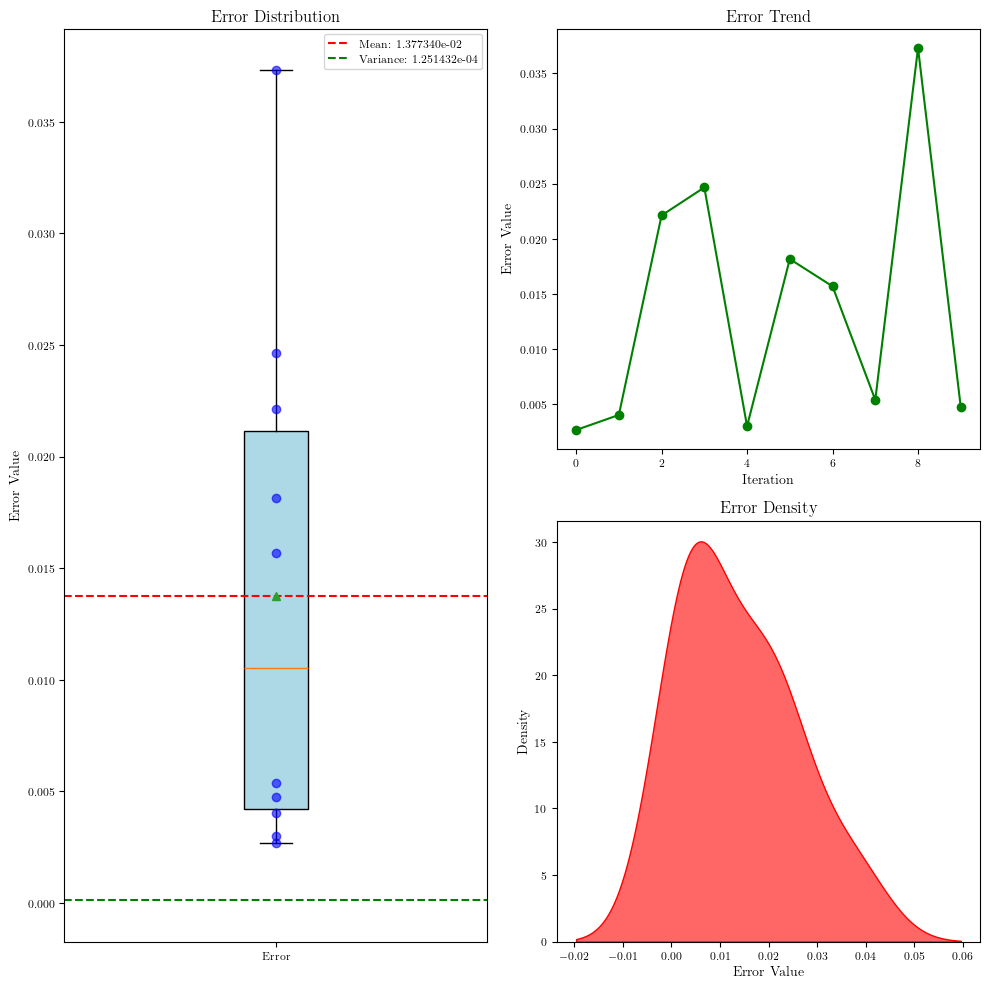

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 1.351164e-03
Variance MAE: 1.102935e-06


/tmp/ipykernel_2695632/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


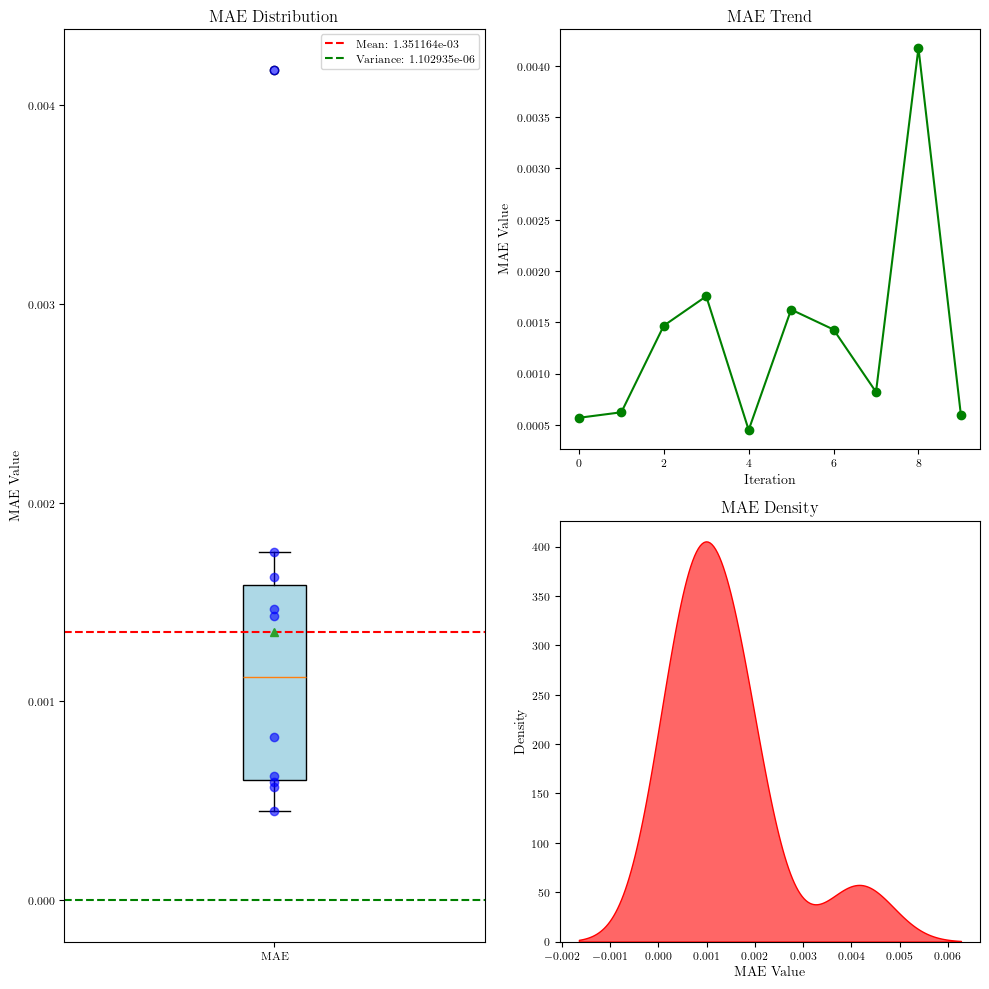

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 1.188276e-04
Variance MSE: 2.457740e-08


/tmp/ipykernel_2695632/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


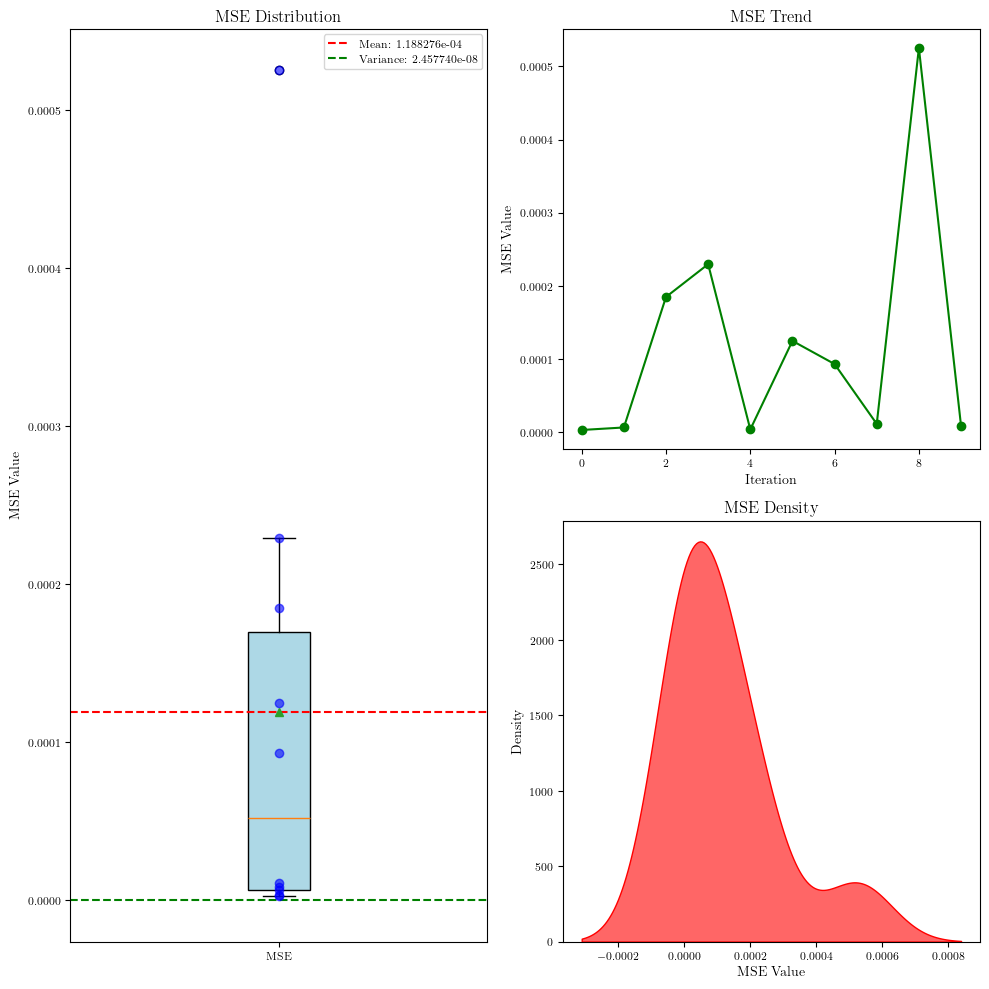

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

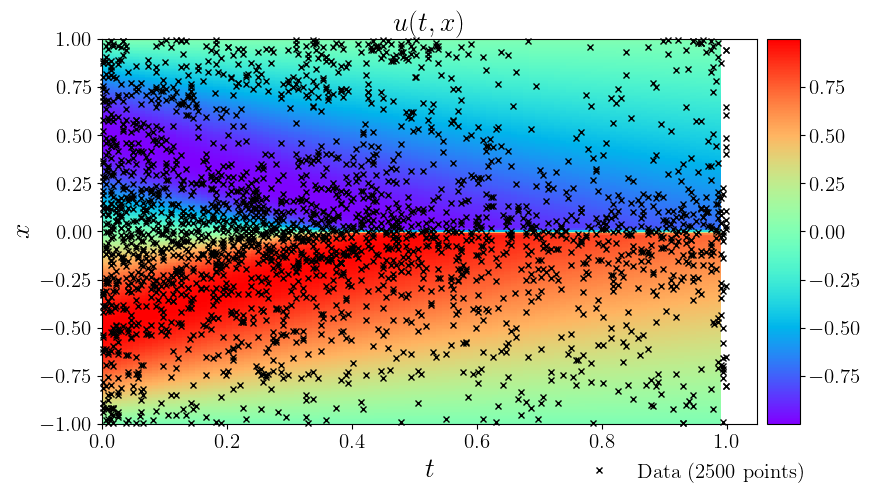

In [14]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [15]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

53327
[6.0001534e-01 5.7925147e-01 5.5952275e-01 ... 5.6655817e-06 5.6655817e-06
 5.6655817e-06]


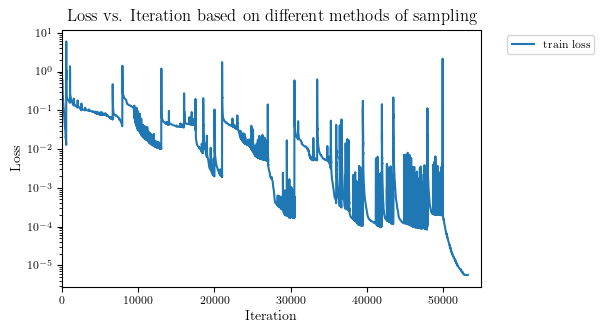

In [16]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

53327
[1.3411124  1.3215016  1.3025525  ... 0.00472709 0.00472709 0.00472709]


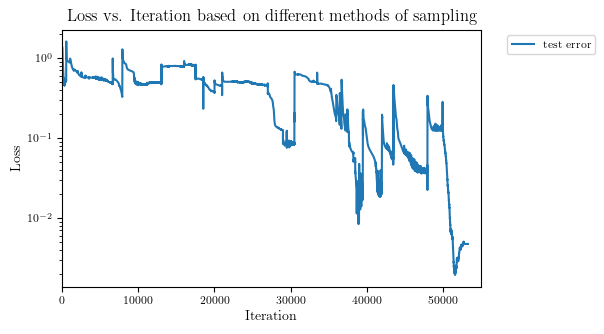

In [17]:
print(len(testerror))
print(testerror)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(testerror, label='test error')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


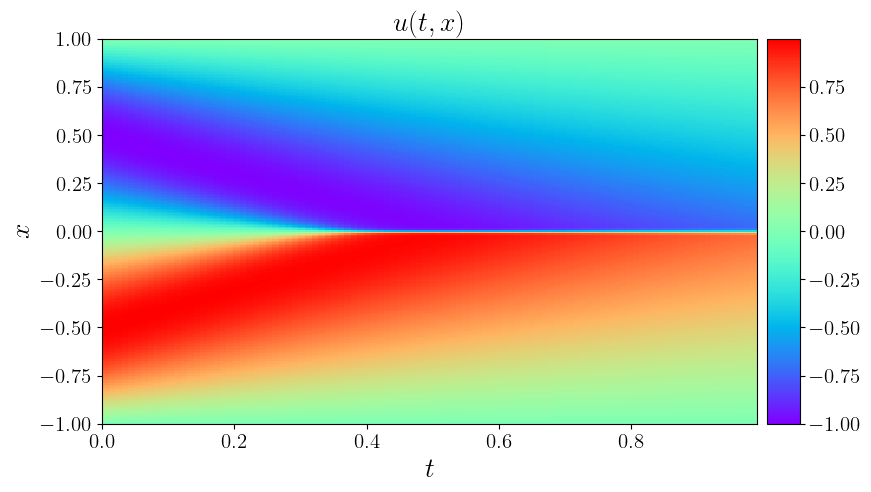

In [18]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_pred, f_pred = model.predict(X_star)    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

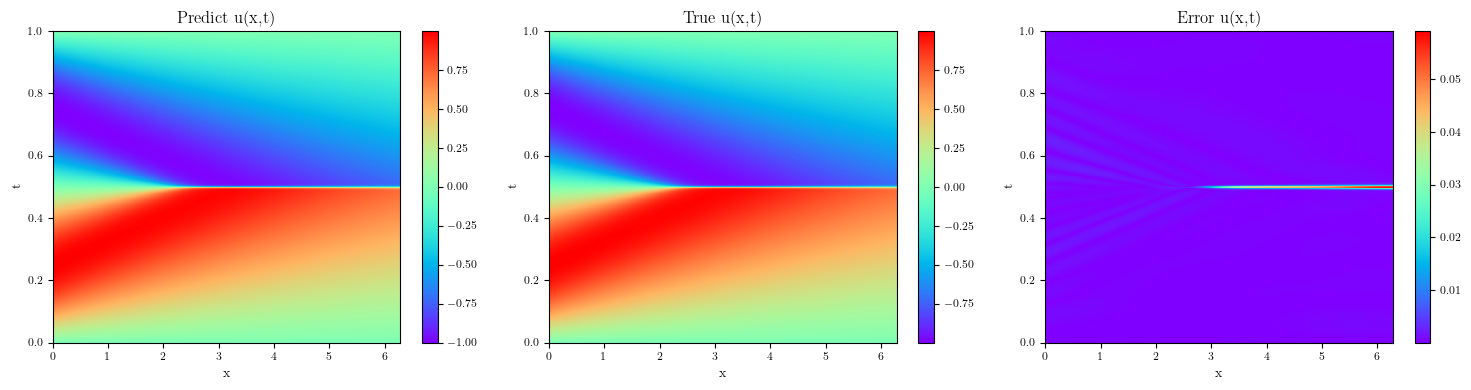

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [20]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

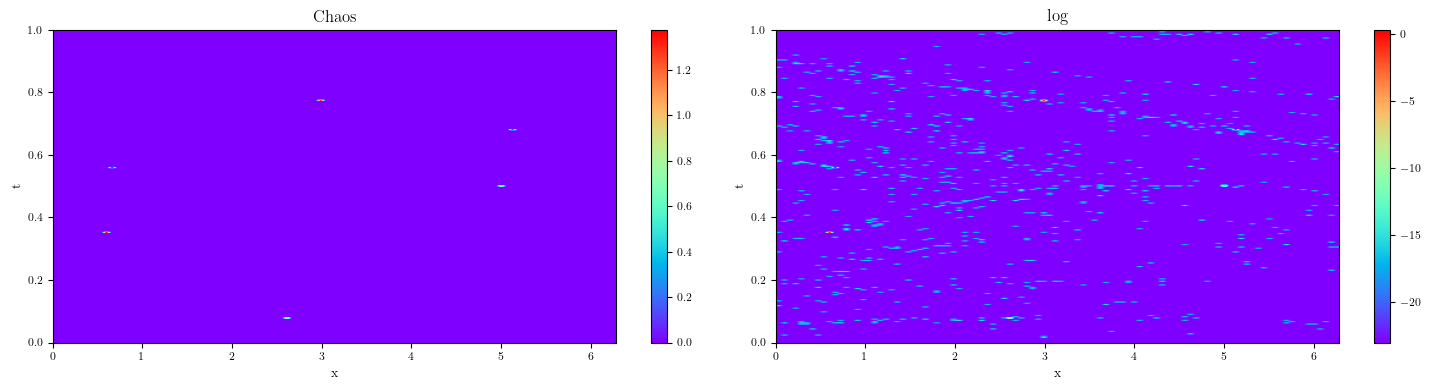

In [21]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()